<a href="https://colab.research.google.com/github/hswon30/cis545_group/blob/main/COVID_19_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Team: Yan Zhuang, Hasun Won, Eric Yao, I Chen

Welcome to our final course project for CIS-545 Summer 2023.

COVID-19 has been a defining event for much of the global community for early 2020s. Its reprecussions were felt firsthand by many, even by students here at University of Pennsylvania who had to move completely off-campus for several consecutive semesters. The scale and the gravity of COVID-19 outbreak inspired us to investigate comprehensive datasets on the topic, and we decided to work on the COVID-19 Open Data repository provided by Google Health.



Per Google's introduction, the COVID-19 Open Data Repository is:

"*One of the most comprehensive collections of up-to-date COVID-19-related information to help public health professionals, researchers, policymakers and others in analyzing, understanding, and managing the virus.*"



Our aim is to further refine data from this repository for various analysis. We will be conducting a number of data wrangling methods, visualizations, data cleaning, and data imputations to identify relevant data from the original source and join all the resulting dataframes as necessary to come up with a cleaned, aggregated dataset with which we will work on our anaylsis.

With this data, we will conduct extensive Exploratory Data Analysis(EDA) and study the various social and environmental factors influencing the spread and outcomes of COVID-19. This includes, but is not limited to, analyzing demographic factors, policy interventions, healthcare infrastructure, environmental factors, and their correlations with COVID-19 mortality rates and the number of cases. We will also attempt to create a model for making time-series predictions on the future number of cases. Such predictive model, if sufficiently accurate, holds potential to furnish critical insights for policymakers to mitigate the effects of future endemics.




##1. Data Preparation: Wrangling and Cleaning

###1.1 Imports
Let's first import basic packages for our analysis:

In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import math
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
from google.colab import drive
from sklearn.linear_model import LinearRegression
from sklearn import metrics

drive.mount('/content/gdrive')

Mounted at /content/gdrive


###1.2 COVID-19 Open Data Repository Specifications
Let's look at the entire COVID-19 Open Data Repository for a general understanding of the structure and dimensions of our data.

|Table	|Keys	|Content	|URL	|Source|
|-------|:------|:---------|:-----|:------|
|Aggregated	|[key][date]|	Flat, compressed table with records from (almost) allother tables joined by date and/or key; see below for more details|	aggregated.csv	|All tables below|
|Index|	[key]	|Various names and codes, useful for joining with other datasets|	index.csv, index.json|	Wikidata, DataCommons, Eurostat|
Demographics|	[key]	|Various (current3) population statistics	|demographics.csv, demographics.json	|Wikidata, DataCommons, WorldBank, WorldPop, Eurostat|
Economy|	[key]|	Various (current3) economic indicators|	economy.csv, economy.json|	Wikidata, DataCommons, Eurostat|
Epidemiology|	[key][date]|	COVID-19 cases, deaths, recoveries and tests|	epidemiology.csv, epidemiology.json|	Various|
Emergency Declarations|	[key][date]|	Government emergency declarations and mitigation policies|	lawatlas-emergency-declarations.csv|	LawAtlas Project|
Geography|	[key]|	Geographical information about the region|	geography.csv, geography.json|	Wikidata|
Health|	[key]	|Health indicators for the region|	health.csv, health.json|	Wikidata, WorldBank, Eurostat|
Hospitalizations|	[key][date]	|Information related to patients of COVID-19 and hospitals|	hospitalizations.csv, hospitalizations.json|	Various|
Mobility |	[key][date]	|Various metrics related to the movement of people. |mobility.csv, mobility.json|	Google
Search Trends|	[key][date]|	Trends in symptom search volumes due to COVID-19.|google-search-trends.csv|	Google|
Vaccination Access|	[place_id]|	Metrics quantifying access to COVID-19 vaccination sites.|facility-boundary-us-all.csv|	Google|
Vaccination Search|	[key][date]|	Trends in Google searches for COVID-19 vaccination information.| Global-vaccination-search-insights.csv|	Google|
Vaccinations|	[key][date]|	Trends in persons vaccinated and population vaccination rate regarding various Covid-19 vaccines.|vaccinations.csv|	Google|
Government Response|	[key][date]|	Government interventions and their relative stringency|	oxford-government-response.csv, oxford-government-response.json|	University of Oxford|
Weather|	[key][date]|	Dated meteorological information for each region|	weather.csv|	NOAA|
WorldBank|	[key]|	Latest record for each indicator from WorldBank for all reporting countries|	worldbank.csv, worldbank.json|	WorldBank|
By Age|	[key][date]|	Epidemiology and hospitalizations data stratified by age|	by-age.csv, by-age.json|	Various|
By Sex|	[key][date]|	Epidemiology and hospitalizations data stratified by sex|	by-sex.csv, by-sex.json|	Various|



Note that we will be wrangling and aggregating our own dataset, so we will not need to import the aggregated dataset or the stratified datasets, by-age and by-sex. We can observe that keys for most of the tables are location key and date, so we will have to keep those columns for the later joins.

We can also make a general observation that actual trends in cases and hospitalizations will be more relevant than simple search trends. Also, vaccination access and mobility are secondary data deriving from features in vaccination rates and government response. Therefore, we will omit them from our final aggregated data.

###1.3 Data Import, Wrangling, and Cleaning
Let's begin our imports of the dataset by downloading each of the files into our workspace.

Note that this process may take a while to run depending on your network environment.

In [ ]:
!wget "https://storage.googleapis.com/covid19-open-data/v3/index.csv"
!wget "https://storage.googleapis.com/covid19-open-data/v3/epidemiology.csv"
!wget 'https://storage.googleapis.com/covid19-open-data/v3/geography.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/health.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/hospitalizations.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/oxford-government-response.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/lawatlas-emergency-declarations.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/weather.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/demographics.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/vaccinations.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/google-search-trends.csv'
!wget 'https://storage.googleapis.com/covid19-open-data/v3/economy.csv'

--2024-05-02 08:41:08--  https://storage.googleapis.com/covid19-open-data/v3/index.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.207, 142.251.170.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2426323 (2.3M) [text/csv]
Saving to: ‘index.csv’

index.csv           100%[===================>]   2.31M  2.27MB/s    in 1.0s    

2024-05-02 08:41:10 (2.27 MB/s) - ‘index.csv’ saved [2426323/2426323]

--2024-05-02 08:41:10--  https://storage.googleapis.com/covid19-open-data/v3/epidemiology.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.207, 142.251.170.207, 173.194.174.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 520931512 (497M) [text/csv]
Saving to: ‘epidemiology.csv’

epidemiology.csv    100%[=====

We will start loading our data with the index provided as a reference for joining with other tables. This will be useful when we later try to analyze data for specific countries or localities.

In [ ]:
#sample data for indexing/joining keys
index= pd.read_csv("index.csv")
index.info()


#number of unique values in each column
unique_vals = index.nunique()
print(unique_vals)
#note that we have 245 countries, 1420 larger subregions, and 18874 smaller subregions

#Print out first rows of the data to see the actual values
index.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   location_key        22962 non-null  object
 1   place_id            21661 non-null  object
 2   wikidata_id         22184 non-null  object
 3   datacommons_id      4216 non-null   object
 4   country_code        22962 non-null  object
 5   country_name        22963 non-null  object
 6   subregion1_code     22715 non-null  object
 7   subregion1_name     22716 non-null  object
 8   subregion2_code     21253 non-null  object
 9   subregion2_name     21253 non-null  object
 10  locality_code       32 non-null     object
 11  locality_name       32 non-null     object
 12  iso_3166_1_alpha_2  22961 non-null  object
 13  iso_3166_1_alpha_3  22962 non-null  object
 14  aggregation_level   22963 non-null  int64 
dtypes: int64(1), object(14)
memory usage: 2.6+ MB
location_key          22

location_key                     place_id wikidata_id datacommons_id  \
0           AD  ChIJlfCemC71pRIRkn_qeNc-yQc        Q228    country/AND   
1           AE  ChIJvRKrsd9IXj4RpwoIwFYv0zM        Q878    country/ARE   
2           AF  ChIJbQL_-LZu0TgReNqWvg1GtfM        Q889    country/AFG   
3       AF_BAL  ChIJWZOescNSyzgRkmVJ8fmfR3k     Q121104            NaN   
4       AF_BAM  ChIJw-bKQwDr0jgRQiw8jHsQ-HI     Q171382            NaN   

  country_code          country_name subregion1_code subregion1_name  \
0           AD               Andorra             NaN             NaN   
1           AE  United Arab Emirates             NaN             NaN   
2           AF           Afghanistan             NaN             NaN   
3           AF           Afghanistan             BAL           Balkh   
4           AF           Afghanistan             BAM          Bamyan   

  subregion2_code subregion2_name locality_code locality_name  \
0             NaN             NaN           NaN           NaN   
1             NaN             NaN           NaN           NaN   
2             NaN             NaN           NaN           NaN   
3             NaN             NaN           NaN           NaN   
4             NaN             NaN           NaN           NaN   

  iso_3166_1_alpha_2 iso_3166_1_alpha_3  aggregation_level  
0                 AD                AND                  0  
1                 AE                ARE                  0  
2                 AF                AFG                  0  
3                 AF                AFG                  1  
4                 AF                AFG                  1

####1.3.1. Import, Wrangling, and Cleaning(2)
Now let's import other datasets into pandas dataframe so they can be wrangled and cleaned.

We will start with the epidemiology dataset that will be the basis for our aggregated data.

In [ ]:
epi = pd.read_csv("epidemiology.csv")
epi.info(null_counts = True)
#This is the most important case-related data from out dataset and should be used as the basis for final, cleaned df
#note that we do not need recovered patient data for our analysis so related columns should be dropped
epi_clean = epi.drop(columns = ['new_recovered', 'cumulative_recovered'], axis = 1)
del epi

TypeError: DataFrame.info() got an unexpected keyword argument 'null_counts'

Economy:

In [ ]:
econ = pd.read_csv('economy.csv')
econ.info()
econ
#Also not that relevant to the holistic view, although we can utilize gdp_usd to some extent, human_capital_index has too many null values to be usable
#and should be dropped
econ_clean = econ.drop(columns = ['human_capital_index'], axis = 1)
del econ

Geography:

In [ ]:
geo = pd.read_csv('geography.csv')
geo.info()
#Geographic locations by themselves are not relevant, since what matters is the population density in metropolitan areas
geo_clean = geo
del geo

Health:

In [ ]:
health = pd.read_csv('health.csv')
health.info()
#Basic search suggests that smoking and diabetes are contributing factors to the mortality rate of covid-19
#after examination with data.info(),
#the only usable feature of this data is life_expectancy, smoking_prevalence, and diabetes_prevalance for each of the locations
health_clean = health[['location_key', 'life_expectancy', 'smoking_prevalence', 'diabetes_prevalence']]
del health

Hospitalizations:

In [ ]:
hospital = pd.read_csv('hospitalizations.csv')
hospital.info(null_counts = True)
#On first examination of the dataset, all features other than date, location key, cumilative and current hospitalized patients have too many null values to be considered
#dates are also out of order and should be refined if this were to be joined

#The dataset as a whole may relate to mortality, but not the trend in number of cases
#Cutoff date to be from 1 Jan 2020 onward
hospital = hospital[['date', 'location_key', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'new_intensive_care_patients', 'cumulative_intensive_care_patients']]
hospital_clean = hospital[hospital['date'] >= '2020-01-01'].reset_index(drop=True)
del hospital

Government response:

In [ ]:
gov_response = pd.read_csv('oxford-government-response.csv')
gov_response.info()

#Since all of the values other than stringency_index are social distancing measures,
#We can combine all of them to create a social distancing score column
#treat all null values as 0 and drop external measures like fiscal and international support

social_distancing = gov_response.drop(columns = ['income_support', 'debt_relief', 'fiscal_measures', 'international_support', 'emergency_investment_in_healthcare', 'investment_in_vaccines'])
social_distancing = social_distancing.dropna()
new_col = 'social_distancing_score'
gov_response_clean = social_distancing.assign(**{new_col: social_distancing[['school_closing', 'workplace_closing',
                                                             'cancel_public_events', 'restrictions_on_gatherings',
                                                             'public_transport_closing', 'stay_at_home_requirements',
                                                             'restrictions_on_internal_movement',
                                                             'international_travel_controls',
                                                             'public_information_campaigns',
                                                             'testing_policy',
                                                             'contact_tracing',
                                                             'facial_coverings',
                                                             'vaccination_policy'
                                                             ]].sum(axis=1)})

gov_response_clean = gov_response_clean.reset_index(drop=True)
#social_distancing = social_distancing[['date', 'location_key' ,'stringency_index', 'social_distancing_score']]
#This can be utilized in later analysis regarding specific government policies

del gov_response

Policies:

In [ ]:
policies = pd.read_csv('lawatlas-emergency-declarations.csv')
policies.info()
policies_clean = policies
#US-limited data
#Usable in US-specific analysis
del policies

Weather:

In [ ]:
weather = pd.read_csv('weather.csv')
weather.info(null_counts=True)
#Weather/temperature is an integral part of disease transmission, so should definitely be part of the dataset
#Drop column snowfall since its null
weather_clean = weather.drop(columns = ['snowfall_mm'], axis = 1)
weather_clean = weather_clean.dropna().reset_index(drop=True)
del weather

Demographics:

In [ ]:
#Included for demographic analysis for specific locations for which data is present
demo = pd.read_csv('demographics.csv')
demo.info()
demo_clean = demo


Vaccination:

In [ ]:
vaccination =  pd.read_csv('vaccinations.csv')
vaccination.info(null_counts = True)
vaccination_clean = vaccination[['date', 'location_key', 'new_persons_vaccinated',	'cumulative_persons_vaccinated', 'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated', 'new_vaccine_doses_administered', 'cumulative_vaccine_doses_administered']]
#starts at 2021-01-25, also relevant to infection trends so should be joined with the larger relations on date & location_key
#droped rows have too many null/0s to be considered
del vaccination

#####1.3.2 Visualization: Null Values
Now that we have completed basic cleaning and wrangling of our data, we can do some visualizations on the data to see if further cleaning can be done.

`missingno` is a useful python package that enables intuitive visualization of values in a dataset, and we can use it to show where we can impute or drop null values without too much change to the original data, since it visualizes the rows in which there are null values.

Since **epidemiology** will be the basis for our final dataframe, let's first consider the cleaned epidemiology dataframe and also see the number of zeros in the dataset, since too many zeros will mean that case-related data analysis on our data will likely be inaccurate. A reasonable number of zeros should still be acceptable for our analysis, since countries will have initial periods during which COVID-19 cases were not actively tracked.

In [ ]:
#visualization to find null values
import missingno as msno
%matplotlib inline
msno.matrix(epi_clean.sample(1000), figsize = (5,5))
#quite a bit of missing values on new_recovered and others- may need additional datasource for accurate analysis
count = (epi_clean['new_confirmed'] == 0).sum()
non_zero_count = (epi_clean['new_confirmed'] != 0).sum()
print('Count of zeros in new confirmed cases : ', count)
print('Count of non-zeros in new confirmed cases:', non_zero_count)

There are more than sufficient number of nonzero confirmed cases(7302636).Furthermore, we observe that there are enough non-null values in the new_confirmed, new_deceased, cumulative_confirmed, and cumulative_deceased column, as well as some similarities on where the nulls are occuring between those columns. Therefore, we can go ahead and do a dropna().


In [ ]:
epi_clean = epi_clean.dropna(subset=['new_confirmed', 'new_deceased', 'cumulative_confirmed', 'cumulative_deceased'])
epi_clean = epi_clean.reset_index(drop=True)

Then we can go over all of the other dataframes in a similar manner, starting with Economy:

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset

msno.matrix(econ_clean.sample(300), figsize = (5,5))

While we would like to remove all null values rather than value imputation, note that there are differences between tuples that are missing gdp_usd in gdp_per_capita_usd. If we simply remove all null values for both columns, we will lose data for a significant geographical group.

Furthermore, since gdp_per_capita_usd is derived from gdp_usd, we can fill in values with reasonable accuracy by joing the relation with population data from demographics dataset.

Let's first visualize a boxplot to see the general distributions of our data:

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(data=econ_clean[['gdp_usd']], ax=axes[0])
axes[0].set_title('GDP Before Filling')


sns.boxplot(data=econ_clean[['gdp_per_capita_usd']], ax=axes[1])
axes[1].set_title('GDP Per Capita Before Filling')
plt.show()

Then calculate our GDP and GDP per capita by joining the relation with population data:

<Axes: >

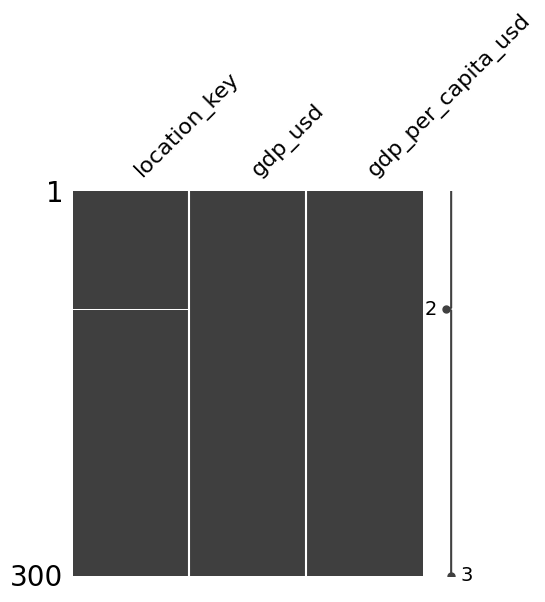

In [ ]:
#join with population data
pop_inter = demo[['location_key', 'population']]
pop_inter
econ_clean = pd.merge(pop_inter, econ_clean, on='location_key', how='inner')
del pop_inter
econ_clean.loc[econ_clean['gdp_usd'].isnull(), 'gdp_usd'] = econ_clean['gdp_per_capita_usd'] * econ_clean['population']

# Impute missing 'population' based on 'gdp_per_capita'
econ_clean.loc[econ_clean['gdp_per_capita_usd'].isnull(), 'gdp_per_capita_usd'] = econ_clean['gdp_usd'] / econ_clean['population']
econ_clean = econ_clean.drop(columns = ['population'], axis = 1)

msno.matrix(econ_clean.sample(300), figsize = (5,5))

With derived values, we now see that there are virtually no null values in our data.

Now let's again visualize a boxplot with our filled data:

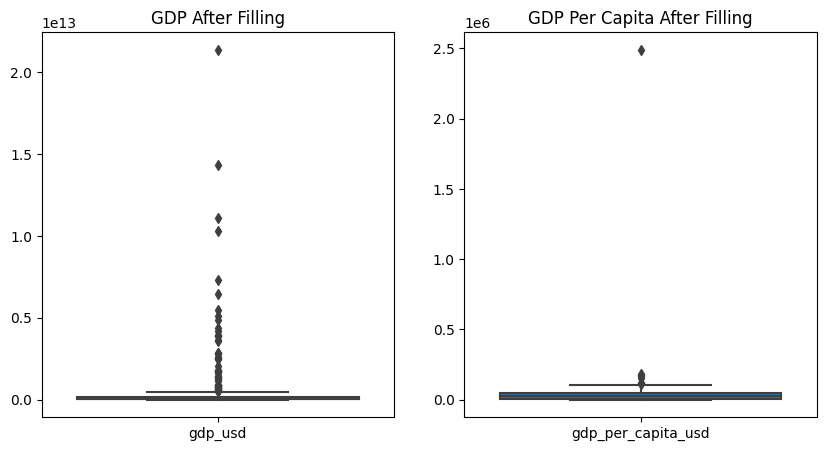

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.boxplot(data=econ_clean[['gdp_usd']], ax=axes[0])
axes[0].set_title('GDP After Filling')


sns.boxplot(data=econ_clean[['gdp_per_capita_usd']], ax=axes[1])
axes[1].set_title('GDP Per Capita After Filling')
plt.show()

Note that the distributions appear practically identical after filling in values, so we can resonably assess that our calculation did not result in creating outliers.

For Geography:

<Axes: >

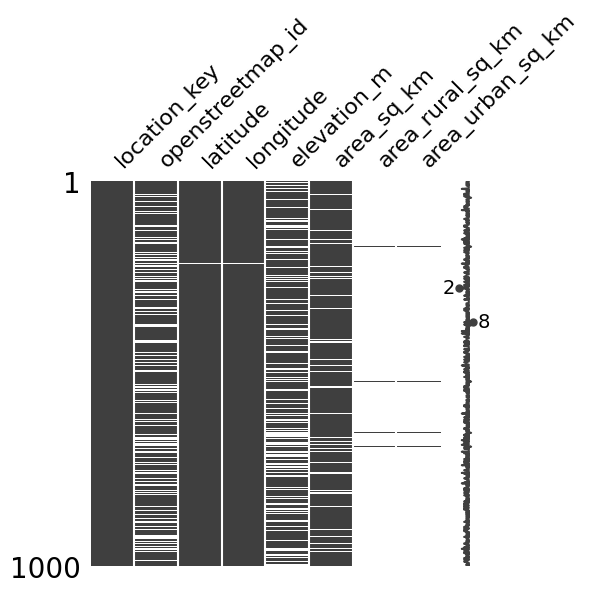

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset

msno.matrix(geo_clean.sample(1000), figsize = (5,5))

We can observe that there are no noticeable patterns or insignificant number of of null rows to ensure a safe value imputation.

Therefore, we will leave it as is. Furthermore, pure geo-location data represented here alone does not accurately represent data for population density which we are interested in, so this should not be part of the larger, aggregated dataset.

For Health:

<Axes: >

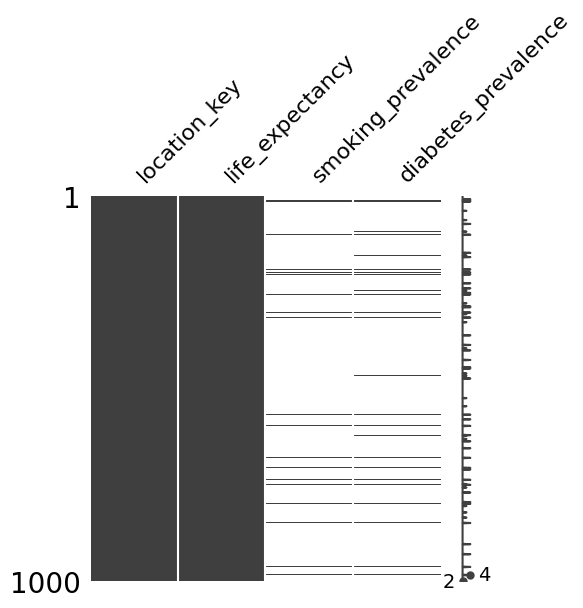

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset
msno.matrix(health_clean.sample(1000), figsize = (5,5))

Similarly, value imputation appears infeasible.

For Government Response:

<Axes: >

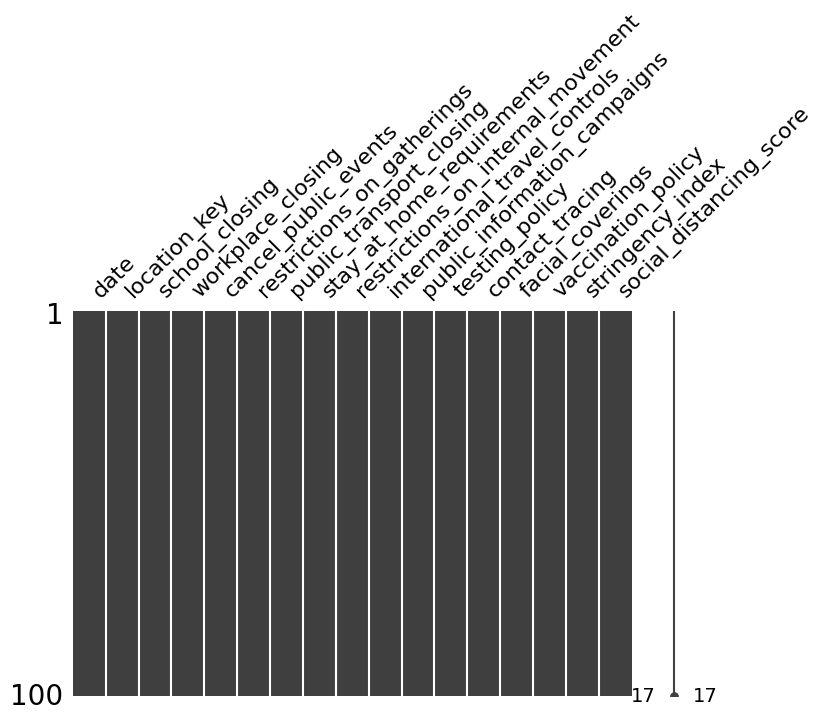

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset
msno.matrix(gov_response_clean.sample(100), figsize = (8,5))

We can see that there are no null values.

This is expected and correct visualization as we previously dropped nulls for this data.


For Policies:

<Axes: >

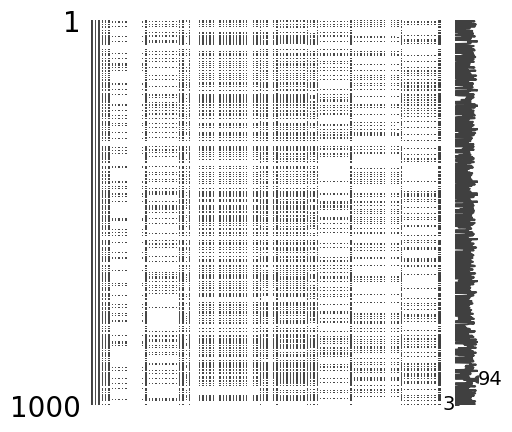

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset

msno.matrix(policies_clean.sample(1000), figsize = (5,5))

Similar to geography and health datasets, value imputation is not feasible due to the significant number of null values.

Note that this data is US-specific, so we will utilize it later when we work with US only data rather than joining it to the aggregated, final data.

For Weather:

<Axes: >

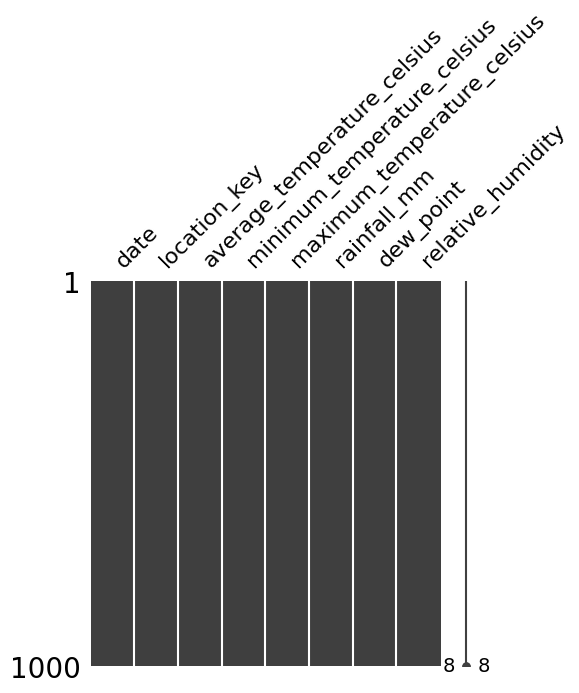

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset

msno.matrix(weather_clean.sample(1000), figsize = (5,5))

There are no null values, as expected as a result of drop_null()

For Demography:

<Axes: >

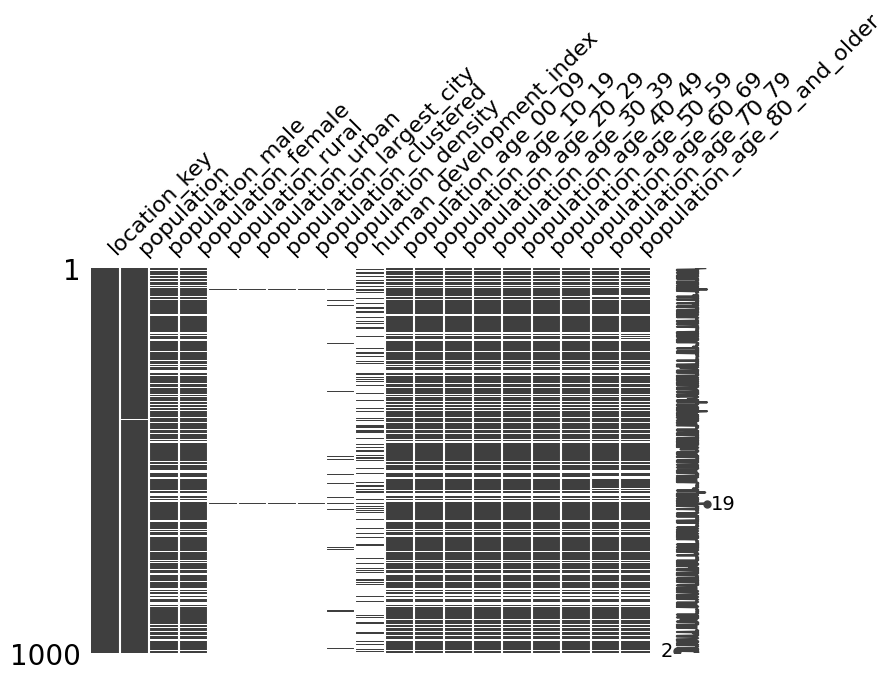

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset

msno.matrix(demo_clean.sample(1000), figsize = (8,5))

The null values here are similarly co-located with respect to the rows. Therefore, we can remove nulls from one column of the demographics dataframe without too much ill effect.

In [ ]:
demo_clean = demo_clean.dropna(subset=['population_male']).reset_index(drop=True)
# demo_clean

location_key  population  population_male  population_female  \
0               AD     77265.0          58625.0            55581.0   
1               AE   9890400.0        6836349.0          3054051.0   
2               AF  38928341.0       19976265.0         18952076.0   
3               AG     97928.0          47269.0            50659.0   
4               AI     15002.0           7151.0             7971.0   
...            ...         ...              ...                ...   
17602    ZA_NC_DC7    195595.0         106870.0           105886.0   
17603        ZA_NW   3509953.0        2140349.0          1989502.0   
17604        ZA_WC   7113776.0        3691344.0          3683467.0   
17605           ZM  18383956.0        9103006.0          9280950.0   
17606           ZW  14862927.0        7092010.0          7770917.0   

       population_rural  population_urban  population_largest_city  \
0                9269.0           67873.0                      NaN   
1             1290785.0         8479744.0                2833079.0   
2            28244481.0         9797273.0                4114030.0   
3               73318.0           23800.0                      NaN   
4                   NaN               NaN                      NaN   
...                 ...               ...                      ...   
17602               NaN               NaN                      NaN   
17603               NaN               NaN                      NaN   
17604               NaN               NaN                      NaN   
17605         9989317.0         7871713.0                2646619.0   
17606         9928163.0         4717305.0                1521311.0   

       population_clustered  population_density  human_development_index  \
0                       NaN             164.394                    0.858   
1                 5914068.0             118.306                    0.863   
2                 4114030.0              59.627                    0.498   
3                       NaN             222.564                    0.780   
4                       NaN             166.689                      NaN   
...                     ...                 ...                      ...   
17602                   NaN                 NaN                      NaN   
17603                   NaN                 NaN                      NaN   
17604                   NaN                 NaN                      NaN   
17605             2646619.0              24.730                    0.588   
17606             1521311.0              38.420                    0.535   

       population_age_00_09  population_age_10_19  population_age_20_29  \
0                    9370.0               12022.0               10727.0   
1                 1011713.0              842991.0             2149343.0   
2                11088732.0             9821559.0             7035871.0   
3                   14583.0               13867.0               14894.0   
4                    2196.0                2146.0                2005.0   
...                     ...                   ...                   ...   
17602               43280.0               39844.0               29814.0   
17603              811182.0              697808.0              689871.0   
17604             1222161.0             1122560.0             1279498.0   
17605             5663542.0             4550181.0             3180383.0   
17606             4308160.0             3559955.0             2482991.0   

       population_age_30_39  population_age_40_49  population_age_50_59  \
0                   12394.0               21001.0               20720.0   
1                 3169314.0             1608109.0              797913.0   
2                 4534646.0             2963459.0             1840198.0   
3                   14094.0               13860.0               12832.0   
4                    2081.0                2187.0                2214.0   
...                     ...                   ...           

For Vaccination:

<Axes: >

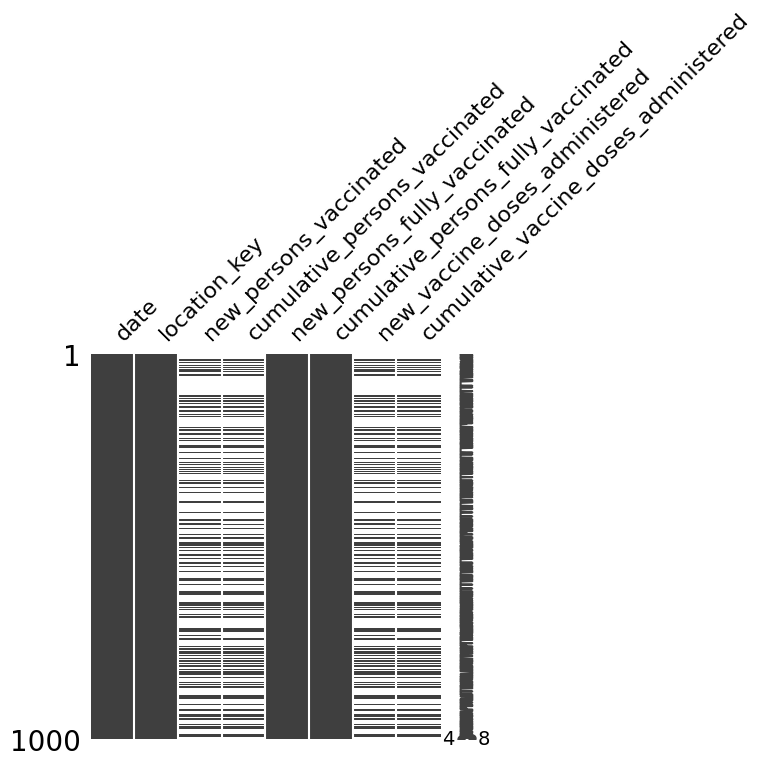

In [ ]:
#Final visualization of the refined datasets to show null value distributions and join feasibility
#dataset_list = [econ_clean, geo_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
#Note the sample size should be adjusted accordingly with the size of the dataset

msno.matrix(vaccination_clean.sample(1000), figsize = (5,5))

It appears that nulls can be dropped from new_persons_fully_vaccinated and cumulative_persons_fully_vaccinated columns.

In [ ]:
vaccination_clean = vaccination_clean.dropna(subset=['new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated']).reset_index(drop=True)

###1.4 Bringing it all together

Now we are ready to join all the cleaned dataframes into one aggregated dataframe for our analysis.

For all intensive purposes of our analysis, we will focus on US data by filtering for US then join all other relations.

In [ ]:
# Filter epi_clean and create the base aggregated DataFrame
epi_clean = epi_clean[epi_clean['location_key'].notna() & epi_clean['location_key'].str.startswith('US')]

#Filter other dataframes to be joined
econ_clean = econ_clean[econ_clean['location_key'].notna() & econ_clean['location_key'].str.startswith('US')]
health_clean = health_clean[health_clean['location_key'].notna() & health_clean['location_key'].str.startswith('US')]
gov_response_clean = gov_response_clean[gov_response_clean['location_key'].notna() & gov_response_clean['location_key'].str.startswith('US')]
policies_clean = policies_clean[policies_clean['location_key'].notna() & policies_clean['location_key'].str.startswith('US')]
weather_clean = weather_clean[weather_clean['location_key'].notna() & weather_clean['location_key'].str.startswith('US')]
demo_clean = demo_clean[demo_clean['location_key'].notna() & demo_clean['location_key'].str.startswith('US')]
vaccination_clean = vaccination_clean[vaccination_clean['location_key'].notna() & econ_clean['location_key'].str.startswith('US')]

dataset_list = [econ_clean, health_clean, gov_response_clean, policies_clean, weather_clean, demo_clean, vaccination_clean]
# #We omit geo_clean from the aggregated dataframe, since simple geo-location data will not help with our analysis
# #Only econ, health, and demo are joined simply by location; others will join by location and date

aggregate_df = epi_clean
del epi_clean

date location_key  lawatlas_mitigation_policy  \
0     2020-01-20        US_AK                           0   
1     2020-01-21        US_AK                           0   
2     2020-01-22        US_AK                           0   
3     2020-01-23        US_AK                           0   
4     2020-01-24        US_AK                           0   
...          ...          ...                         ...   
8359  2020-06-27        US_WY                           1   
8360  2020-06-28        US_WY                           1   
8361  2020-06-29        US_WY                           1   
8362  2020-06-30        US_WY                           1   
8363  2020-07-01        US_WY                           1   

      lawatlas_state_emergency  lawatlas_emerg_statewide  \
0                          NaN                       NaN   
1                          NaN                       NaN   
2                          NaN                       NaN   
3                          NaN                       NaN   
4                          NaN                       NaN   
...                        ...                       ...   
8359                       1.0                       1.0   
8360                       1.0                       1.0   
8361                       1.0                       1.0   
8362                       1.0                       1.0   
8363                       1.0                       1.0   

      lawatlas_travel_requirement  \
0                             NaN   
1                             NaN   
2                             NaN   
3                             NaN   
4                             NaN   
...                           ...   
8359                          0.0   
8360                          0.0   
8361                          0.0   
8362                          0.0   
8363                          0.0   

      lawatlas_traveler_type_all_people_entering_the_state  \
0                                                   NaN      
1                                                   NaN      
2                                                   NaN      
3                                                   NaN      
4                                                   NaN      
...                                                 ...      
8359                                                NaN      
8360                                                NaN      
8361                                                NaN      
8362                                                NaN      
8363                                                NaN      

      lawatlas_traveler_type_travelers_from_specified_states  \
0                                                   NaN        
1                                                   NaN        
2                                                   NaN        
3                                                   NaN        
4                                                   NaN        
...                                                 ...        
8359                                                NaN        
8360                                                NaN        
8361                                                NaN        
8362                                                NaN        
8363                                                NaN        

      lawatlas_traveler_type_travelers_from_specified_countries  \
0                                                   NaN           
1                                                   NaN           
2                                                   NaN           
3                                                   NaN           
4                                                   NaN           
...                                                 ...           
8359                                                NaN           
8360                                                NaN        

In [ ]:
#to merge each of the dataframes
for data in dataset_list:
  if 'date' in data.columns:
    aggregate_df = pd.merge(aggregate_df, data, on=['date', 'location_key'], how='left')
  else:
    aggregate_df = pd.merge(aggregate_df, data, on=['location_key'], how='left')
  del data

####1.4.1. Aggregated Data Visualization
We can then visualize the general US-wide correlation between our COVID-19 factors to see an overview of our data:

In [ ]:
corr_matrix = aggregate_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap of All Cleaned Features in US')
plt.show()

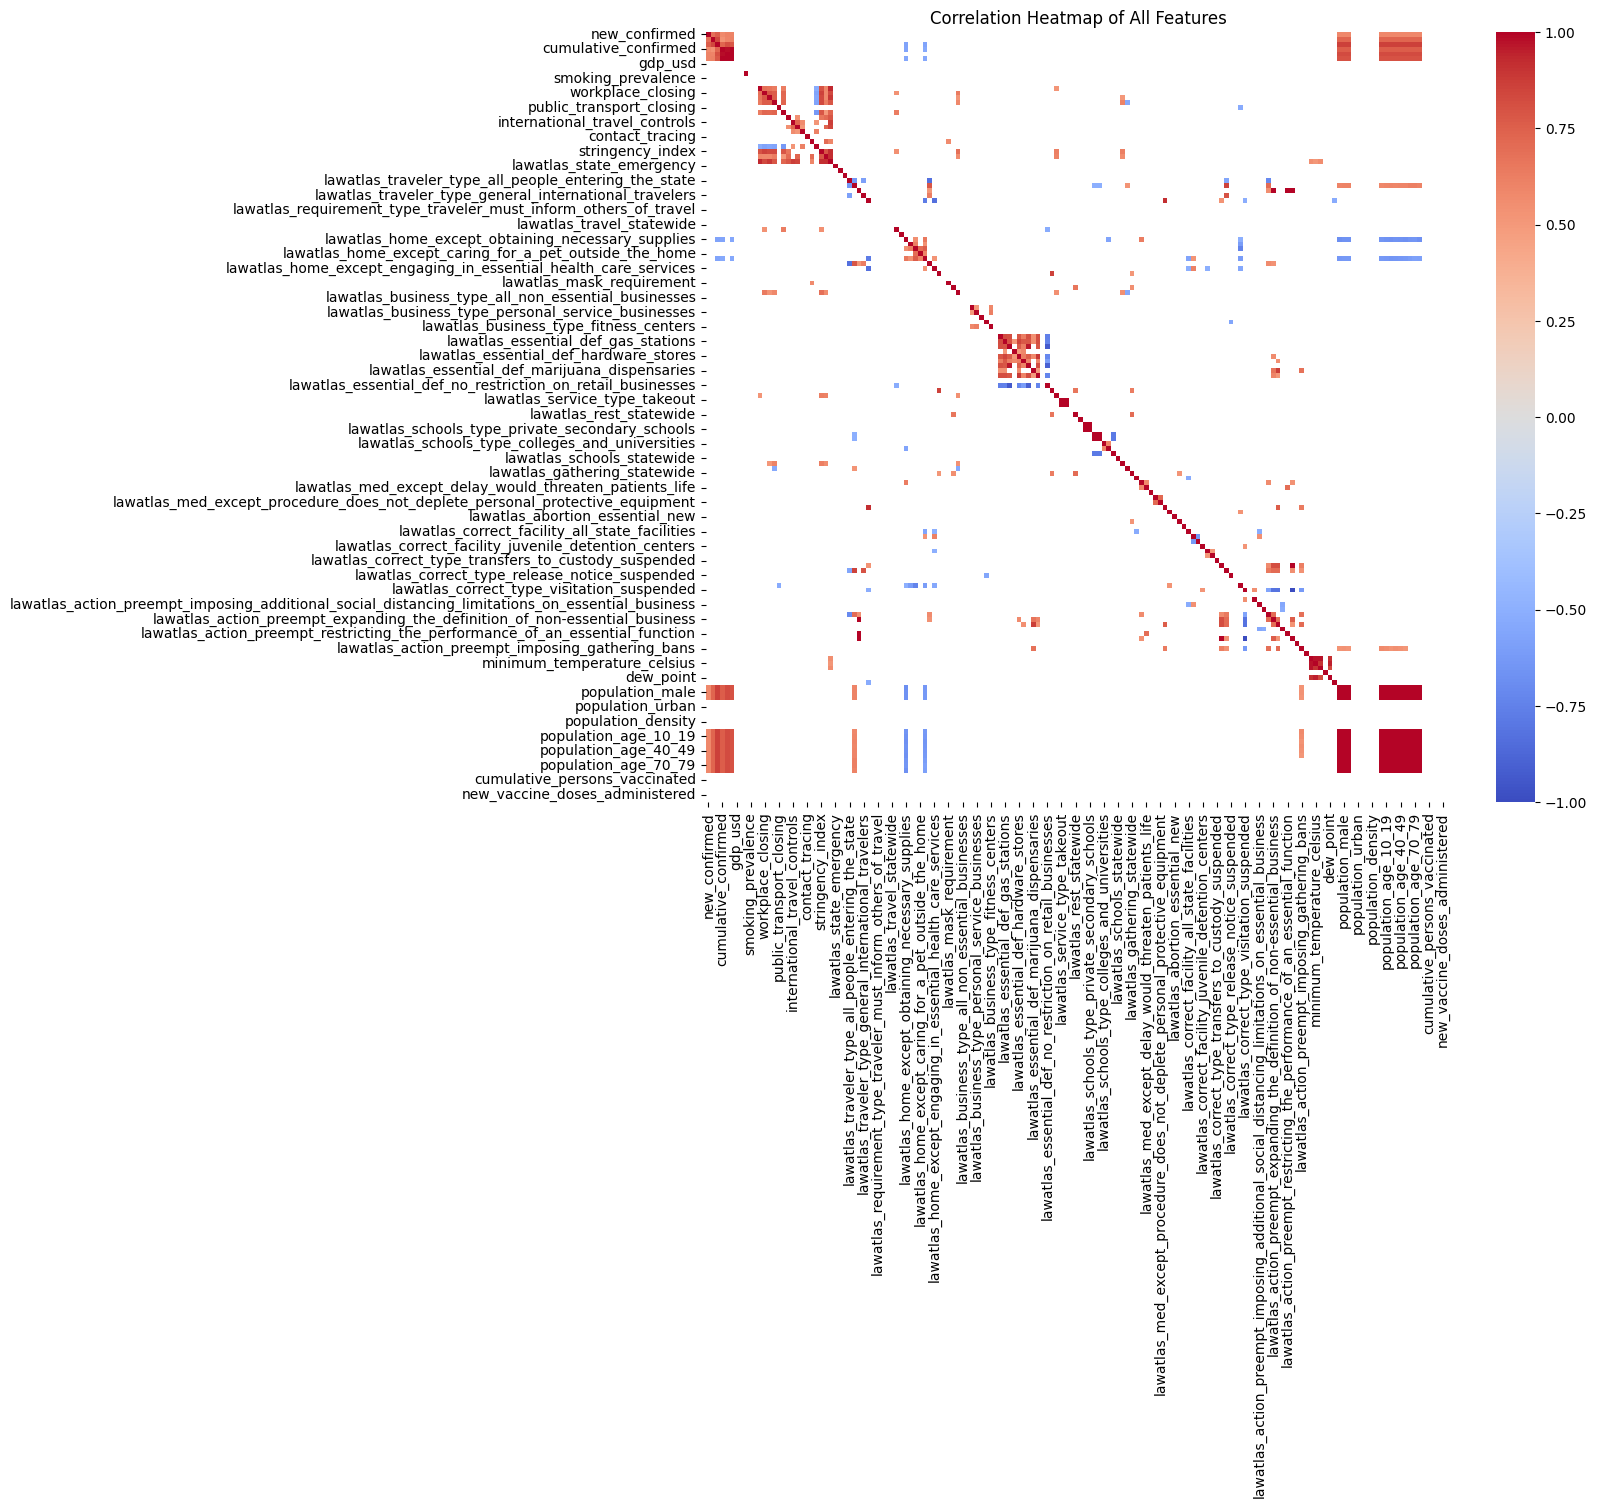

We generally observe significan relationships to be sparse across US, other than the obvious correlation between new case counts and demographics.

####1.4.2 Rationale for Filtering Our Data for Analysis

While we have extensively wrangled and cleaned our worldwide data into a US-specific dataset, it is still too big in size and scope for Google Colab RAM to reasonably handle. Therefore, we will be focusing mainly on US_CA data for California and its subregions for most of our analysis. This decision was made with two critical points:



*   More detailed policy-related data such as emergency declarations is only available to US states and not provided for other countries.
*   Filtering for California provides us with one of the biggest comprehensive COVID-19 datasets in the US with over 50,000 rows, which meets our data requirements.

###1.5 Focus of Our Analysis

Going onward, we would like to look at the data from the following perspectives:
1. Geographic and Temporal Information:study the spread of COVID-19 across different geographical locations and over time.
2. Demographic Data: use age and gender data to explore the age-wise and  gender-wise case distribution of confirmed cases.
3. Policy Intervention: analyze the impact of these interventions on the spread and outcomes of COVID-19.
4.Environmental Factors: Environmental factors can be analyzed using columns like 'average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius', 'rainfall_mm', etc.
5. COVID-19 Specific Data: 'new_confirmed', 'new_deceased', 'new_tested', 'new_hospitalized_patients', etc., along with their cumulative counterparts. This data can help understand the spread and impact of COVID-19.
6. Search trends for various health conditions (e.g., 'search_trends_diabetes', 'search_trends_obesity', 'search_trends_anxiety'). These could potentially indicate public awareness or concern about these conditions during the pandemic.

In [ ]:
del aggregate_df
file_path = '/content/gdrive/My Drive/Finalproject/extracted_data_filtered.csv'
data = pd.read_csv(file_path)

<ipython-input-2-350e5f83e6b5>:2: DtypeWarning: Columns (4,101,102,103,104,105,106,116,540,541) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [ ]:
# Revise relevant columns
columns_of_interest = [
    'location_key', 'date',
    'new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2', 'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5',
    'new_confirmed_male', 'new_confirmed_female',"new_persons_fully_vaccinated",
    'public_information_campaigns', 'vaccination_policy',
    'average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius', 'rainfall_mm',
    'new_confirmed', 'new_deceased', 'new_tested', 'new_hospitalized_patients',
    'search_trends_diabetes', 'search_trends_obesity', 'search_trends_anxiety',"stringency_index"
]

data_filtered = data[columns_of_interest]

# Check for missing values
missing_values = data_filtered.isnull().sum().sort_values(ascending=False)

#filter columns for potential negative data
data_filtered = [(data_filtered['new_confirmed'] >= 0) & (data_filtered['new_deceased'] >= 0) &
 (data_filtered['new_persons_vaccinated'] >= 0) & (data_filtered['new_persons_fully_vaccinated'] >= 0)]

missing_values

new_confirmed_age_4             58851
new_confirmed_age_5             58851
new_confirmed_male              58777
new_confirmed_female            58777
new_confirmed_age_0             58721
new_confirmed_age_1             58721
new_confirmed_age_2             58721
new_confirmed_age_3             58721
new_hospitalized_patients       58534
vaccination_policy              58523
public_information_campaigns    58523
stringency_index                58523
new_tested                      58167
new_persons_fully_vaccinated    30329
new_deceased                    12875
new_confirmed                   11951
search_trends_obesity           11751
search_trends_anxiety            7024
search_trends_diabetes           6883
average_temperature_celsius       204
minimum_temperature_celsius       204
maximum_temperature_celsius       204
rainfall_mm                       204
date                                0
location_key                        0
dtype: int64

Looking at the missing values, we can see a significant number of rows lack information. For the purpose of analysis, we will focus on columns with less missing data.

##2. Exploratory Data Analysis (EDA)

###2.1 Summary Statistics

First, we'll look at some summary statistics for the numerical columns in the dataset. This will give us a sense of the distribution of values in these columns.



In [ ]:
data.describe()


aggregation_level  new_confirmed  new_deceased  cumulative_confirmed  \
count       59460.000000   47509.000000  46585.000000          4.756700e+04   
mean            2.000000     434.644531      4.003134          1.463784e+05   
std             0.182576    3715.674224     25.846726          8.040758e+05   
min             1.000000   -7221.000000   -423.000000          0.000000e+00   
25%             2.000000       0.000000      0.000000          1.212000e+03   
50%             2.000000      13.000000      0.000000          9.221000e+03   
75%             2.000000      94.000000      1.000000          4.440350e+04   
max             3.000000  227972.000000   1114.000000          1.117176e+07   

       cumulative_deceased  cumulative_tested  new_persons_vaccinated  \
count         46643.000000       1.293000e+03            5.950000e+02   
mean           1830.138863       5.987431e+06            5.483819e+04   
std            9000.403807       1.026406e+07            1.328539e+05   
min               0.000000       2.000000e+00           -2.468411e+06   
25%              12.000000       8.042130e+05            5.941500e+03   
50%             103.000000       2.432235e+06            3.739200e+04   
75%             514.000000       4.251967e+06            7.128550e+04   
max           95620.000000       4.964601e+07            5.172130e+05   

       cumulative_persons_vaccinated  new_persons_fully_vaccinated  \
count                   5.960000e+02                  2.913100e+04   
mean                    2.608256e+07                  1.591774e+03   
std                     9.103390e+06                  3.174545e+04   
min                     7.035400e+05                 -3.485179e+06   
25%                     2.331306e+07                  0.000000e+00   
50%                     2.986409e+07                  3.600000e+01   
75%                     3.265356e+07                  3.050000e+02   
max                     3.410072e+07                  3.614744e+06   

       cumulative_persons_fully_vaccinated  ...  \
count                         2.918900e+04  ...   
mean                          8.398285e+05  ...   
std                           3.334273e+06  ...   
min                           0.000000e+00  ...   
25%                           2.330400e+04  ...   
50%                           1.091750e+05  ...   
75%                           4.298950e+05  ...   
max                           2.906033e+07  ...   

       new_persons_fully_vaccinated_janssen  \
count                            541.000000   
mean                            3878.068392   
std                             9808.144875   
min                           -42028.000000   
25%                              110.000000   
50%                             1024.000000   
75%                             3929.000000   
max                           117644.000000   

       cumulative_persons_fully_vaccinated_janssen  \
count                                 5.420000e+02   
mean                                  1.758816e+06   
std                                   4.913879e+05   
min                                   1.220000e+03   
25%                                   1.613552e+06   
50%                                   1.995996e+06   
75%                                   2.088106e+06   
max                                   2.101825e+06   

       new_vaccine_doses_administered_pfizer  \
count                             541.000000   
mean                            77646.070240   
std                             95171.538611   
min                           -973279.000000   
25%                             16385.000000   
50%                             61254.000000   
75%                            109781.000000   
max                            550344.000000   

       cumulative_vaccine_doses_administered_pfizer  \
count                                  5.420000e+02   
mean                                   3.339204e+07   
std                                  

####2.1.1 Observations

'new_confirmed': The mean number of new confirmed cases per day is 434.64, but the standard deviation is quite large (3715.67), indicating a wide range of values. The maximum number of new confirmed cases in a single day is 227,972.

'new_deceased': The mean number of new deaths per day is 4.00, with a maximum of 1,114 in a single day.

'new_persons_vaccinated': On average, 1,591.77 persons are vaccinated each day. However, the standard deviation is quite large (31,745.45), indicating a wide range of values.

'new_persons_fully_vaccinated': On average, there are about 8,398.29 persons fully vaccinated each day, with a maximum of 3,614,744 in a single day.

###2.2 Data Visualization: COVID-19 cases, deaths, tests

We can start by investigating the spread of COVID-19 over time and across different locations. We'll plot the daily confirmed cases, deaths, and tests.

<ipython-input-50-ba7a219abb64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['date'] = pd.to_datetime(data_filtered['date'])


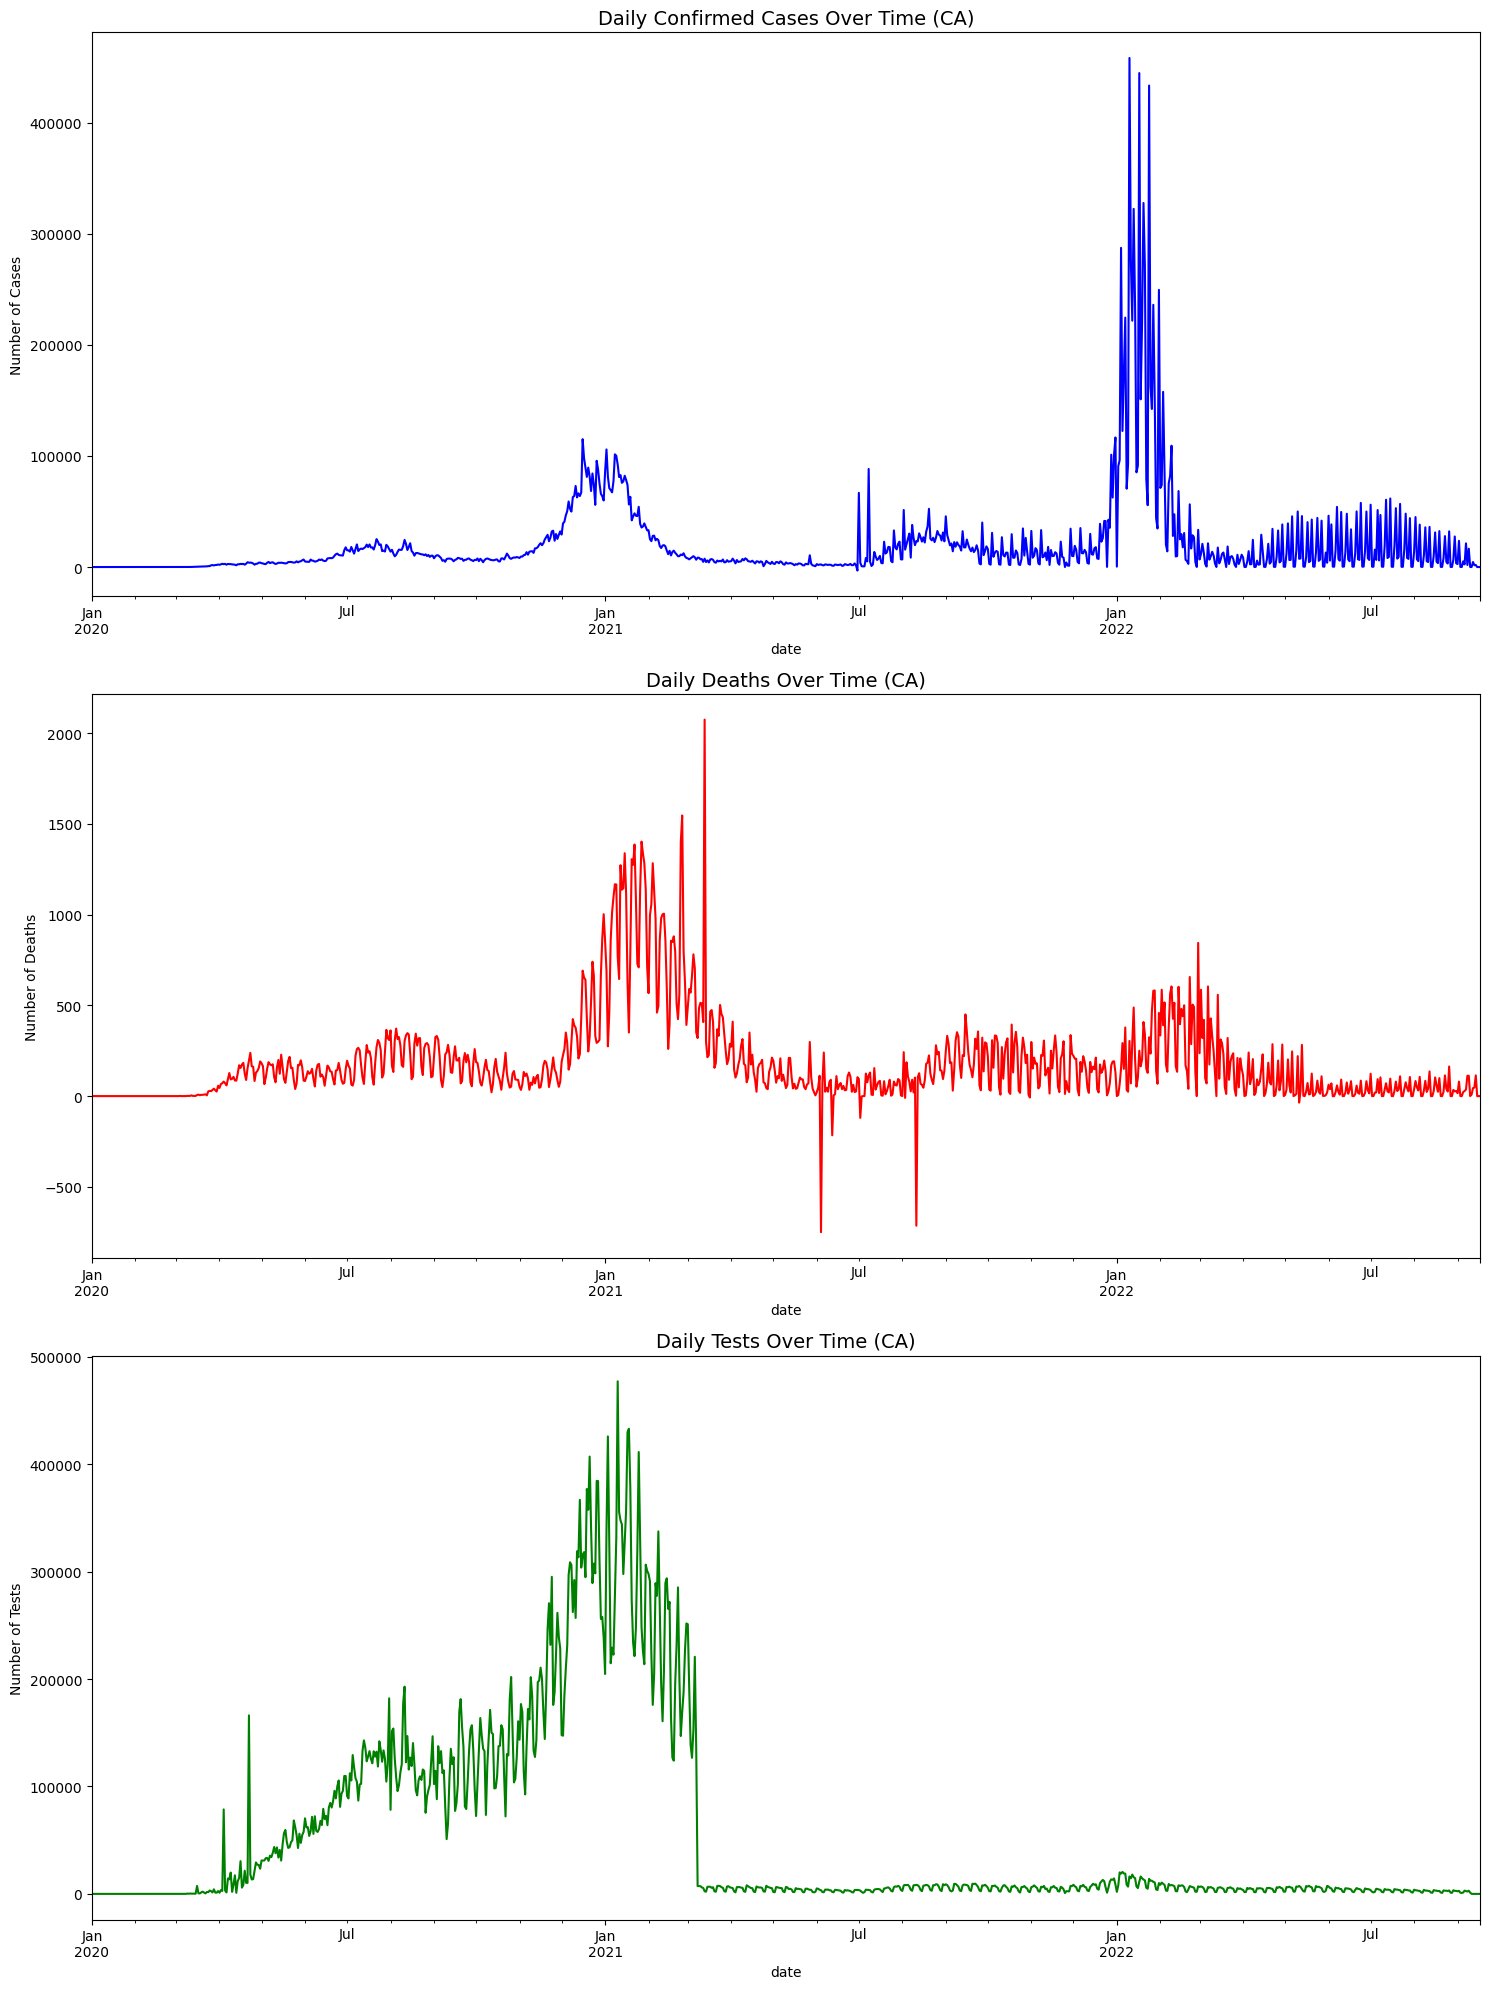

In [ ]:
# Convert 'date' column to datetime
data_filtered['date'] = pd.to_datetime(data_filtered['date'])

# Plot the daily confirmed cases, deaths, and tests over time (CA)
fig, ax = plt.subplots(3, 1, figsize=(15, 20))

# Daily confirmed cases
data_filtered.groupby('date')['new_confirmed'].sum().plot(ax=ax[0], color='blue')
ax[0].set_title('Daily Confirmed Cases Over Time (CA)', fontsize=14)
ax[0].set_ylabel('Number of Cases')

# Daily deaths
data_filtered.groupby('date')['new_deceased'].sum().plot(ax=ax[1], color='red')
ax[1].set_title('Daily Deaths Over Time (CA)', fontsize=14)
ax[1].set_ylabel('Number of Deaths')

# Daily tests
data_filtered.groupby('date')['new_tested'].sum().plot(ax=ax[2], color='green')
ax[2].set_title('Daily Tests Over Time (CA)', fontsize=14)
ax[2].set_ylabel('Number of Tests')

plt.tight_layout()
plt.show()

####2.2.1 Observations  

From the graphs, we can infer the following:

Daily Confirmed Cases: There seem to be several peaks in the number of confirmed cases, indicating different waves of the pandemic. The data also indicates periods of relative calm between these waves.

Daily Deaths: The daily number of deaths seems to follow a pattern similar to that of the confirmed cases, which is to be expected given that the number of deaths is likely to increase with the number of cases. However, the peaks in deaths appear to lag slightly behind the peaks in cases, which could be due to the time it takes for the disease to progress.

Daily Tests: The number of tests conducted daily seems to have increased over time. This could be due to increased testing capacity and the availability of tests.

###2.3 Total Number of Cases, Deceased, Vaccinated

we'll look at the total number of confirmed cases, deaths, and vaccinations in each county. We'll need to filter the data for each county, and then group by the 'subregion1_name' column, which represents the name of the county.

In [ ]:
data_counties = data[data['aggregation_level'] == 2]

# Calculate the total number of confirmed cases, deaths, and fully vaccinated people in each county
county_stats = data_counties.groupby('subregion1_name').agg(
    total_confirmed=('cumulative_confirmed', 'max'),
    total_deceased=('cumulative_deceased', 'max'),
    total_fully_vaccinated=('cumulative_persons_fully_vaccinated', 'max')
).reset_index()

county_stats

subregion1_name  total_confirmed  total_deceased  total_fully_vaccinated
0      California        2908425.0         32022.0               7388754.0

####2.3.1. Visualization: Total Cases by Age Group, Gender

Next, let's look at the distribution of confirmed cases among different age and gender groups



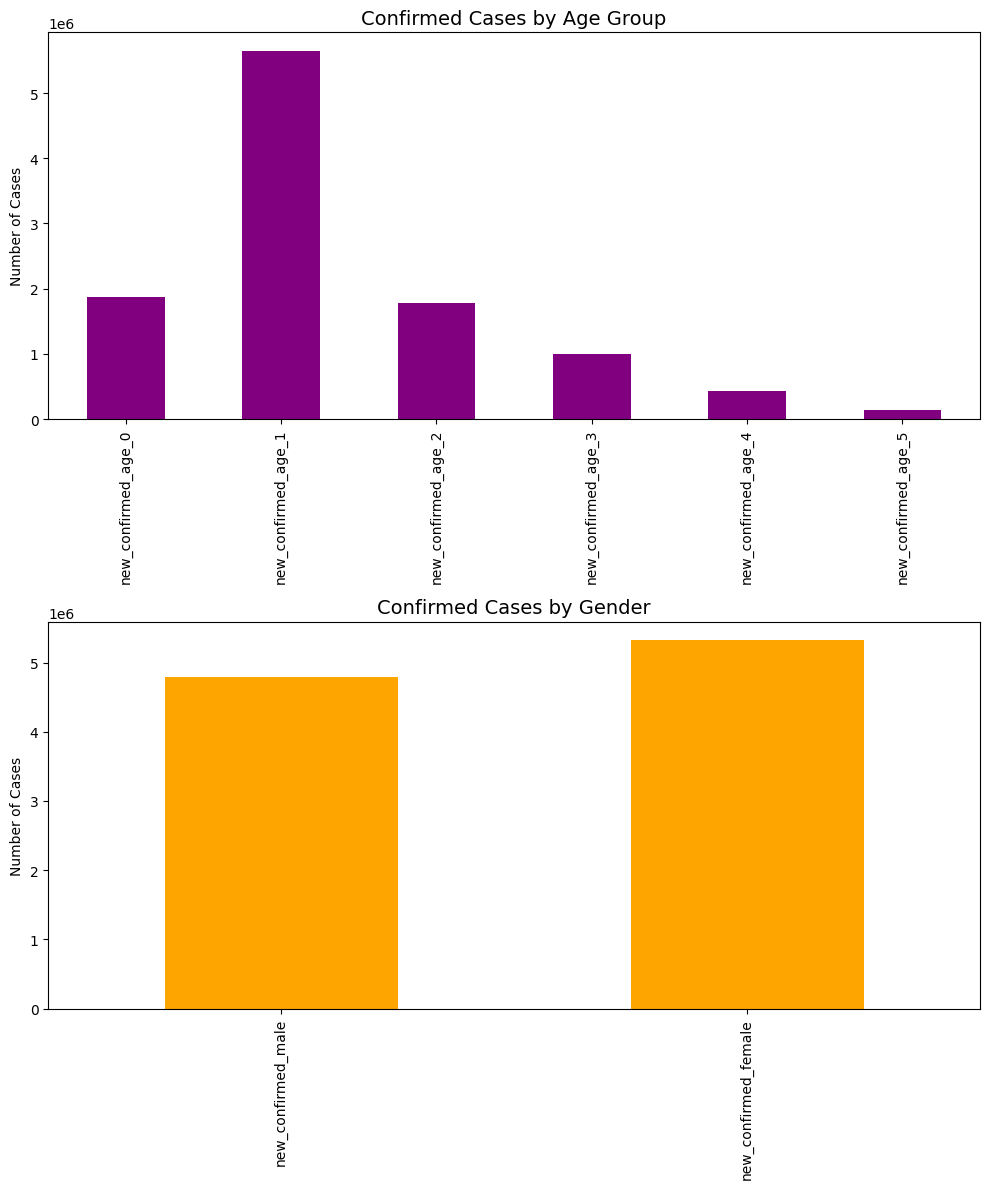

In [ ]:
# Sum up the confirmed cases for each age group
age_columns = ['new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2', 'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5']
age_totals = data_filtered[age_columns].sum()

# Sum up the confirmed cases for each gender
gender_columns = ['new_confirmed_male', 'new_confirmed_female']
gender_totals = data_filtered[gender_columns].sum()

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Plot confirmed cases by age group
age_totals.plot(kind='bar', ax=ax[0], color='purple')
ax[0].set_title('Confirmed Cases by Age Group', fontsize=14)
ax[0].set_ylabel('Number of Cases')

# Plot confirmed cases by gender
gender_totals.plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title('Confirmed Cases by Gender', fontsize=14)
ax[1].set_ylabel('Number of Cases')

plt.tight_layout()
plt.show()

####2.3.2 Observations

From these plots, we can infer the following:

Age Group: The distribution of confirmed cases among different age groups seems fairly even, with 'new_confirmed_age_1' and 'new_confirmed_age_2' showing slightly more cases.

Gender: The number of confirmed cases is fairly similar between males and females, indicating that the virus affects both genders relatively equally.


##3. Temporal Analysis

 In this step, we'll focus on analyzing the trends and patterns in the data over time:

How the number of new cases, deaths, and vaccinations have changed over time.

Whether there are any notable trends or patterns in the data (for instance, weekly or monthly patterns).

How policy measures have changed over time, and whether these changes correspond to changes in the number of cases or deaths.

###3.1 Visualization: 7-Day Rolling Average of New Confirmed Cases and Deaths

We can look at the rolling averages of new confirmed cases and new deaths.
We'll use a 7-day rolling average, which is commonly used in COVID-19 data analysis to account for day-of-week effects (like lower testing and reporting on weekends).

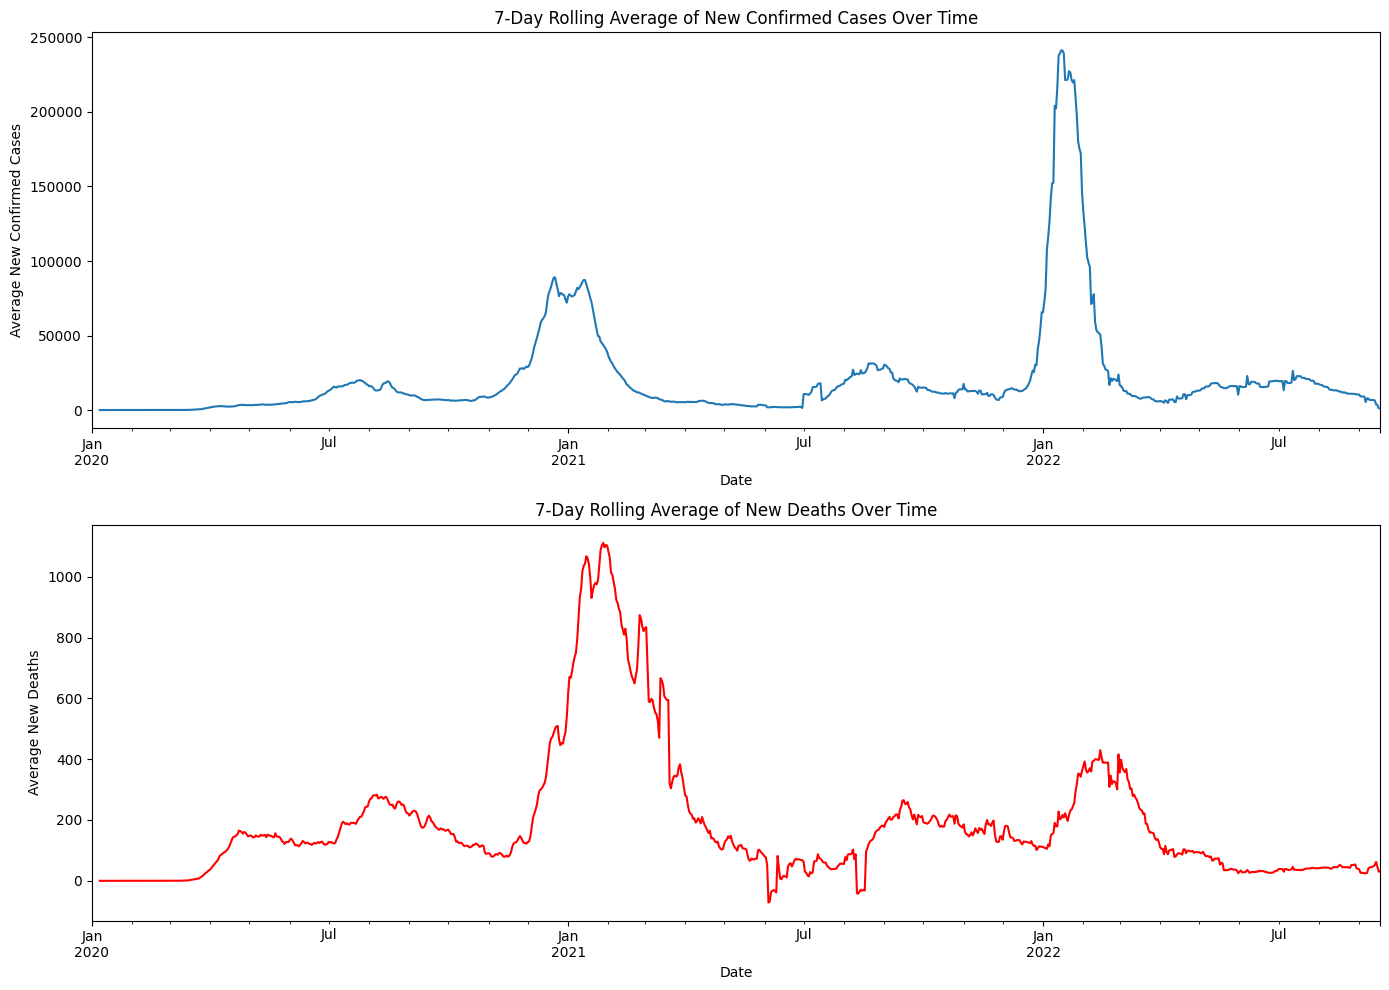

In [ ]:
# Calculate 7-day rolling averages of new confirmed cases and new deaths
rolling_cases_by_date = total_cases_by_date.rolling(window=7).mean()
rolling_deaths_by_date = total_deaths_by_date.rolling(window=7).mean()

# Plot the rolling averages over time
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
rolling_cases_by_date.plot()
plt.title('7-Day Rolling Average of New Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Average New Confirmed Cases')

plt.subplot(2, 1, 2)
rolling_deaths_by_date.plot(color='red')
plt.title('7-Day Rolling Average of New Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Average New Deaths')

plt.tight_layout()
plt.show()

####3.1.1 Observations

We can observe the following:

New Confirmed Cases:

There's a significant increase in the number of new confirmed cases during certain periods, suggesting waves or surges in cases.

The graph shows at least three distinct peaks, which can be attributed to the multiple waves of the pandemic. The most notable peak is around mid-to-late 2020, followed by another significant surge towards the end of 2020 and the beginning of 2021.

After the second peak, there's a sharp decline, but cases rise again, leading to the third wave starting from Jan 2022 which appears to be the highest surge in our data. After this high point, the cases steadily decline to the levels before Jan 2022.



New Deaths:

The pattern for new deaths somewhat mirrors that of the new confirmed cases, but with certain lags or delays. This delay is expected since deaths typically occur some time after confirmation of infection.

There's a distinct peak in deaths around the beginning of 2021, following the surge in cases towards the end of 2020.

After the peak, there's a noticeable decline in new deaths, which stabilizes at a lower level compared to the peaks.

The trends suggest that certain measures, like lockdowns, social distancing, or vaccination drives, might have been implemented following the peaks, leading to subsequent declines.

The correlation between peaks in new confirmed cases and subsequent peaks in new deaths emphasizes the severe consequences of large outbreaks.

The declining trend in both graphs towards the more recent dates might suggest effective control measures, the impact of vaccinations, or possible herd immunity in certain areas.

### 3.2 Visualization: 7-Day Rolling Average of New Tested and Hospitalized Patients

We can also visualize the 7-day rolling average in new people tested and the number of newly hospitalized patients:

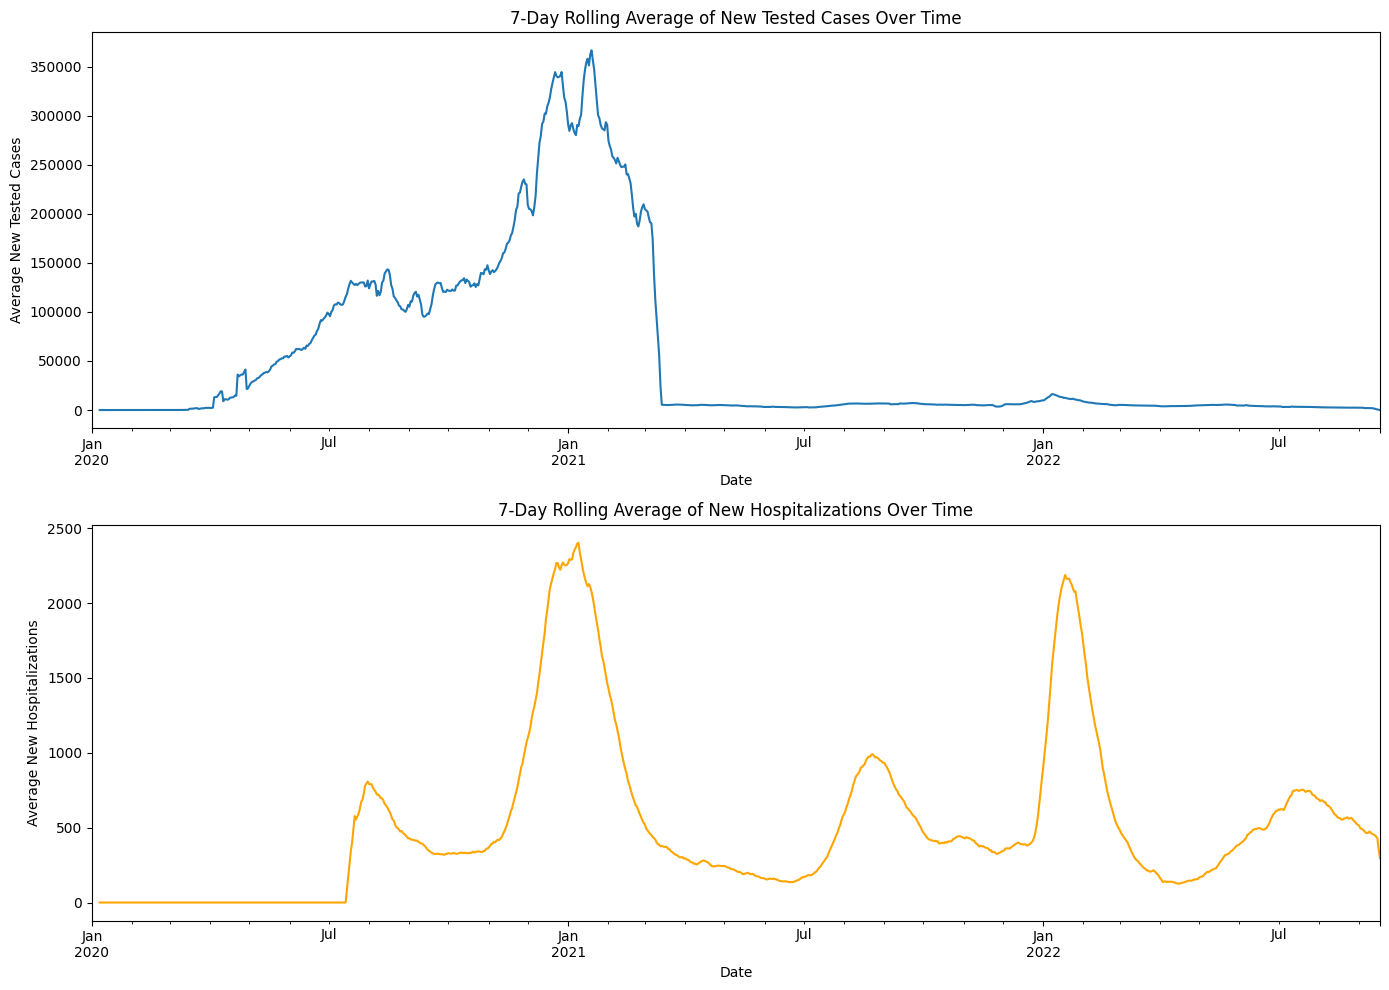

In [ ]:
# Plot the rolling averages over time
total_tested_by_date = data_filtered.groupby('date')['new_tested'].sum()
total_hospitalized_by_date = data_filtered.groupby('date')['new_hospitalized_patients'].sum()

rolling_tested_by_date = total_tested_by_date.rolling(window=7).mean()
rolling_hospitalized_by_date = total_hospitalized_by_date.rolling(window=7).mean()

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
rolling_tested_by_date.plot()
plt.title('7-Day Rolling Average of New Tested Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Average New Tested Cases')

plt.subplot(2, 1, 2)
rolling_hospitalized_by_date.plot(color='orange')
plt.title('7-Day Rolling Average of New Hospitalizations Over Time')
plt.xlabel('Date')
plt.ylabel('Average New Hospitalizations')

plt.tight_layout()
plt.show()

####3.2.1 Observations

New Tested Cases Over Time:

The graph shows a steady increase in testing from the early stages of the pandemic.

There's a noticeable surge in the number of tests conducted around mid-to-late 2020, reflecting an increased capacity and emphasis on testing.

The testing rate seems to fluctuate after the initial surge but remains relatively high, which might suggest periodic testing campaigns or changes in testing criteria.

New Hospitalizations Over Time:

There are distinct peaks in hospitalizations, which correspond to the surges observed in the confirmed cases chart.

The most prominent peak in hospitalizations is around the beginning of 2021, which aligns with the second wave of confirmed cases.

After this peak, there's a sharp decline in hospitalizations, eventually stabilizing at lower levels.

An increased testing rate, as seen in the first graph, might help in early detection and isolation, potentially reducing the spread of the virus.

Peaks in hospitalizations are significant indicators of the strain on healthcare systems. These peaks can lead to overburdened hospitals, potentially affecting the quality of care.

The decline in hospitalizations after the peaks might suggest effective interventions, better treatments, or the possibility that more mild cases are being identified due to increased testing.

###3.3 Visualization: Cases and Death Against Stringency Index

We can also see the case counts and deaths against stringency index, which is an index on how strongly social distancing policies are imposed.

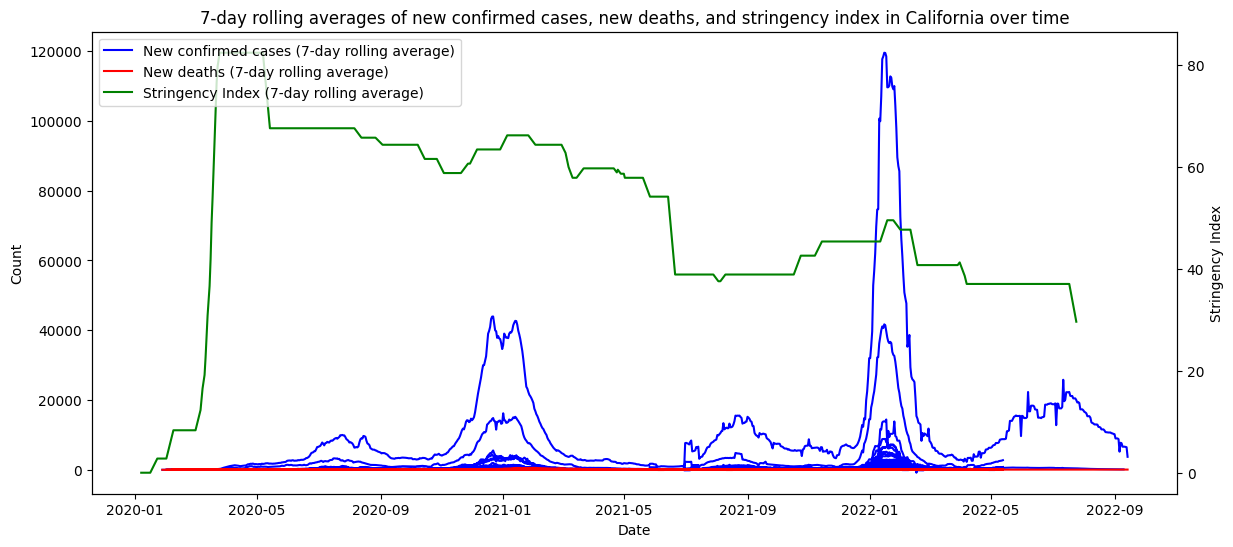

In [ ]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Calculate the 7-day rolling averages
data['rolling_cases'] = data['new_confirmed'].rolling(window=7).mean()
data['rolling_deaths'] = data['new_deceased'].rolling(window=7).mean()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the 7-day rolling average of new confirmed cases and deaths
ax1.plot(data['date'], data['rolling_cases'], label='New confirmed cases (7-day rolling average)', color='blue')
ax1.plot(data['date'], data['rolling_deaths'], label='New deaths (7-day rolling average)', color='red')

# Create a second y-axis
ax2 = ax1.twinx()
# Plot the 7-day rolling average of the stringency index on the second y-axis
ax2.plot(data['date'], data['stringency_index_rolling'], label='Stringency Index (7-day rolling average)', color='green')

# Set the labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax2.set_ylabel('Stringency Index')
plt.title('7-day rolling averages of new confirmed cases, new deaths, and stringency index in California over time')

# Add a legend
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

plt.show()

####3.3.1 Observations

The set of graphs represented here are reflective of our experience with COVID-19; as public awareness on the disease wore off and stringent distancing poliies were lifted one by one, it led to a sharp increase in cases from Jan 2022,during which stricter policies were implemented.

However, it did not prevent CA from having another massive, unprecedented outbreak in number of cases.

###3.4 Visualization: Search Trends

let's explore how the search trends for diabetes, obesity, and anxiety have changed over time.

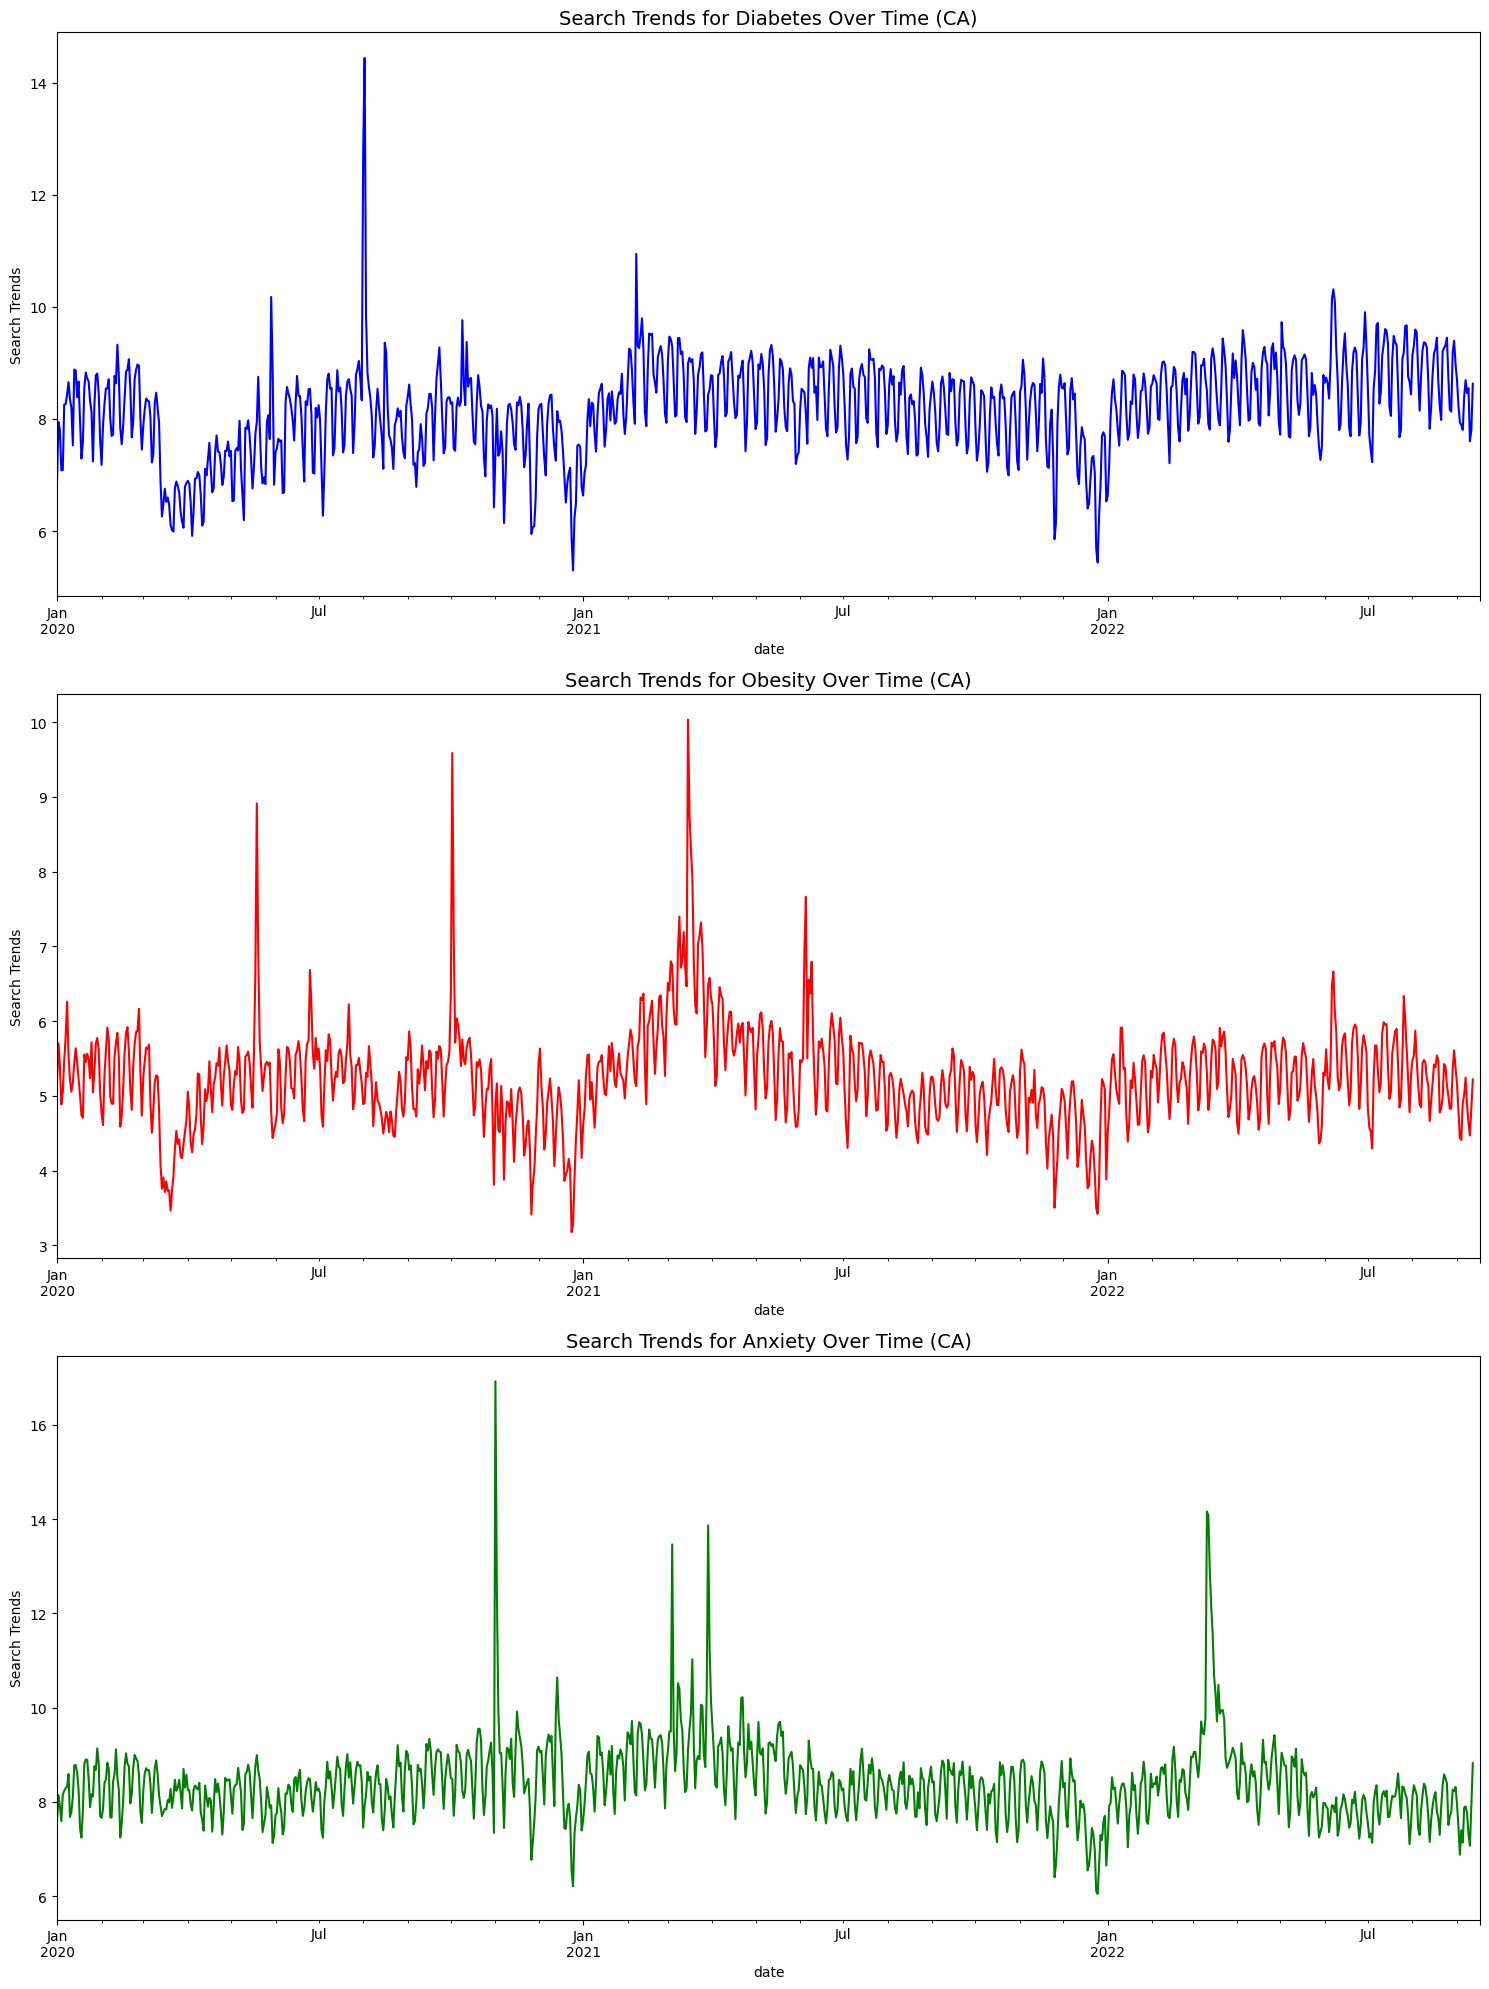

In [ ]:
# Plot the search trends over time (CA)
fig, ax = plt.subplots(3, 1, figsize=(15, 20))

# Diabetes search trends
data_filtered.groupby('date')['search_trends_diabetes'].mean().plot(ax=ax[0], color='blue')
ax[0].set_title('Search Trends for Diabetes Over Time (CA)', fontsize=14)
ax[0].set_ylabel('Search Trends')

# Obesity search trends
data_filtered.groupby('date')['search_trends_obesity'].mean().plot(ax=ax[1], color='red')
ax[1].set_title('Search Trends for Obesity Over Time (CA)', fontsize=14)
ax[1].set_ylabel('Search Trends')

# Anxiety search trends
data_filtered.groupby('date')['search_trends_anxiety'].mean().plot(ax=ax[2], color='green')
ax[2].set_title('Search Trends for Anxiety Over Time (CA)', fontsize=14)
ax[2].set_ylabel('Search Trends')

plt.tight_layout()
plt.show()

###3.4.1 Observations

Diabetes Search Trends: The interest in diabetes seems to have increased slightly over time, indicating that people might have become more concerned about this condition during the pandemic. This could be due to increased awareness about the potential risks of COVID-19 for people with diabetes.

Obesity Search Trends: The search trends for obesity show some fluctuation but seem to remain relatively stable overall. This suggests that public interest or concern about obesity might not have significantly changed during the pandemic.

Anxiety Search Trends: The search trends for anxiety show a clear upward trend, suggesting that public concern about anxiety has increased during the pandemic. This could be due to the increased stress and uncertainty caused by the pandemic.

###3.5 Visualization: Cumulative Number of Vaccinated and Fully Vaccinated

Let's plot the cumulative number of persons vaccinated and fully vaccinated over time. We can also observe the number of new vaccinations administered over time.

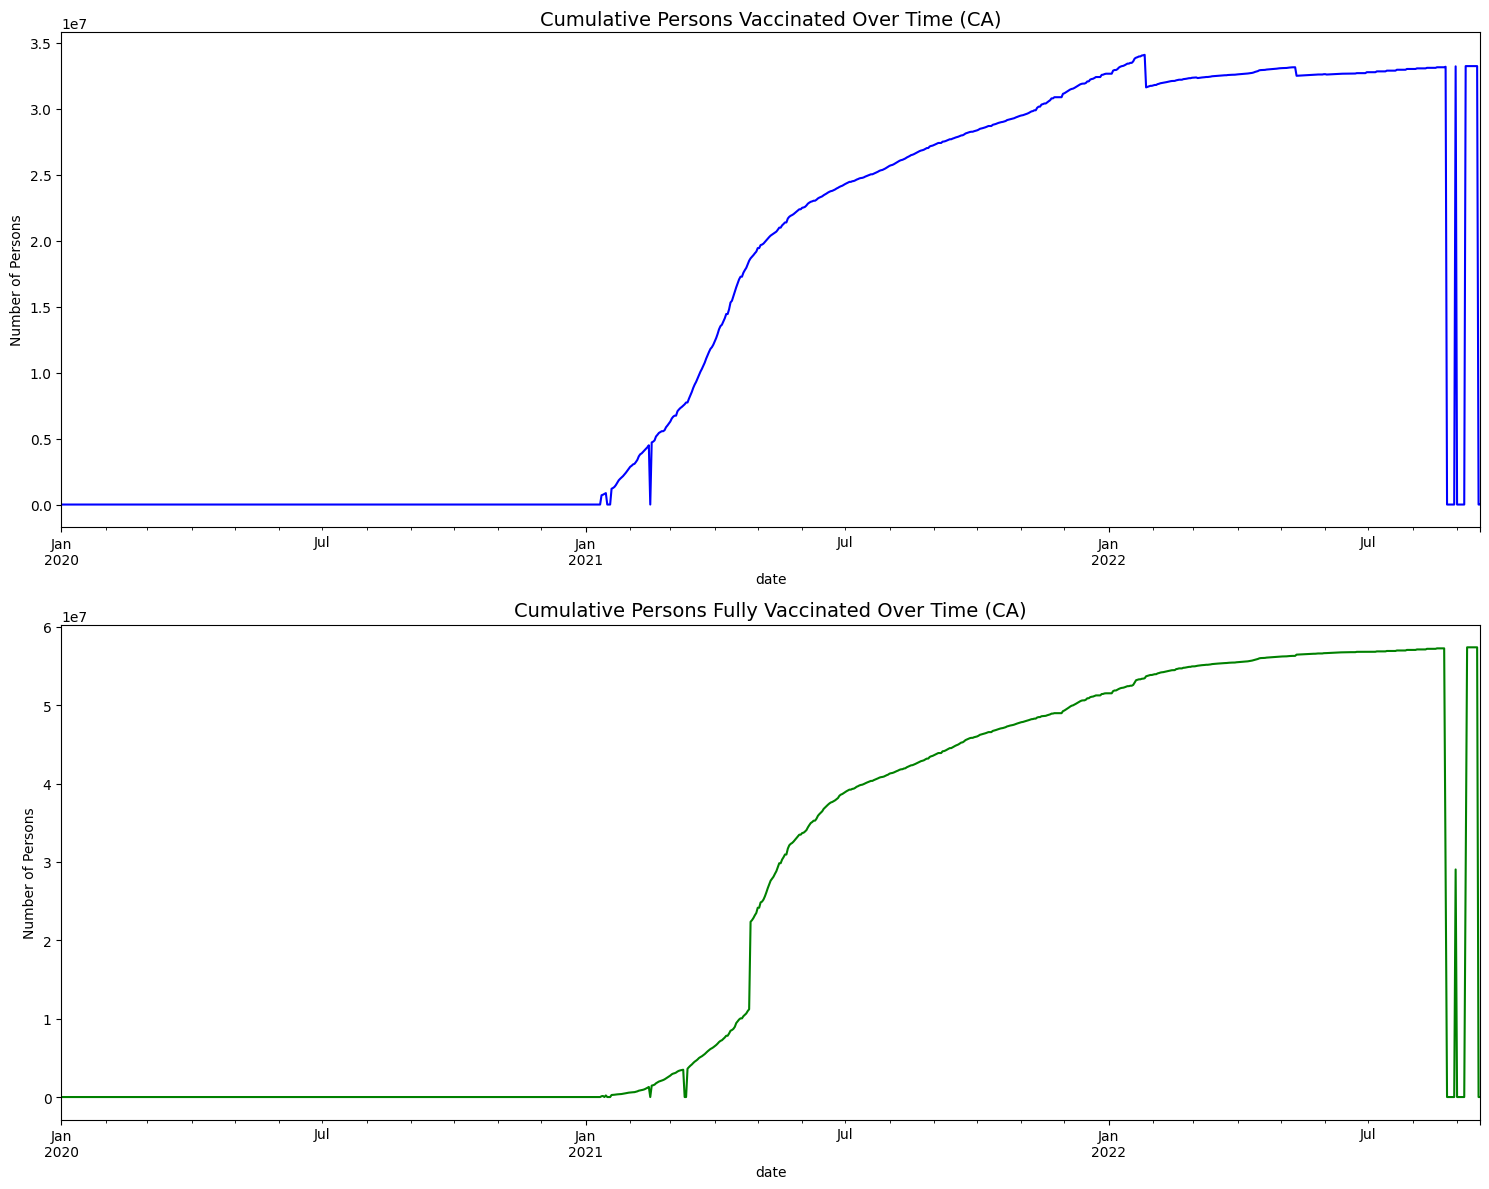

In [ ]:
vaccine_columns = [
    'new_persons_vaccinated', 'cumulative_persons_vaccinated',
    'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated',
    'new_vaccine_doses_administered', 'cumulative_vaccine_doses_administered'
]

data_filtered_vaccine = data_filtered.copy()
data_filtered_vaccine[vaccine_columns] = data[vaccine_columns]

# Plot the cumulative number of persons vaccinated and fully vaccinated over time (CA)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# Cumulative persons vaccinated
data_filtered_vaccine.groupby('date')['cumulative_persons_vaccinated'].sum().plot(ax=ax[0], color='blue')
ax[0].set_title('Cumulative Persons Vaccinated Over Time (CA)', fontsize=14)
ax[0].set_ylabel('Number of Persons')

# Cumulative persons fully vaccinated
data_filtered_vaccine.groupby('date')['cumulative_persons_fully_vaccinated'].sum().plot(ax=ax[1], color='green')
ax[1].set_title('Cumulative Persons Fully Vaccinated Over Time (CA)', fontsize=14)
ax[1].set_ylabel('Number of Persons')

plt.tight_layout()
plt.show()

###3.5.1 Observations

As we can see from the graph, the number of people fully vaccinated steadily grew with the number of vaccinated people as expected. We can conclude that most of the people who got vaccinated eventually got fully vaccinated.

###3.6 Visualization: New Vaccinations Administered

We can also visualize the number of new vaccines administered over time:

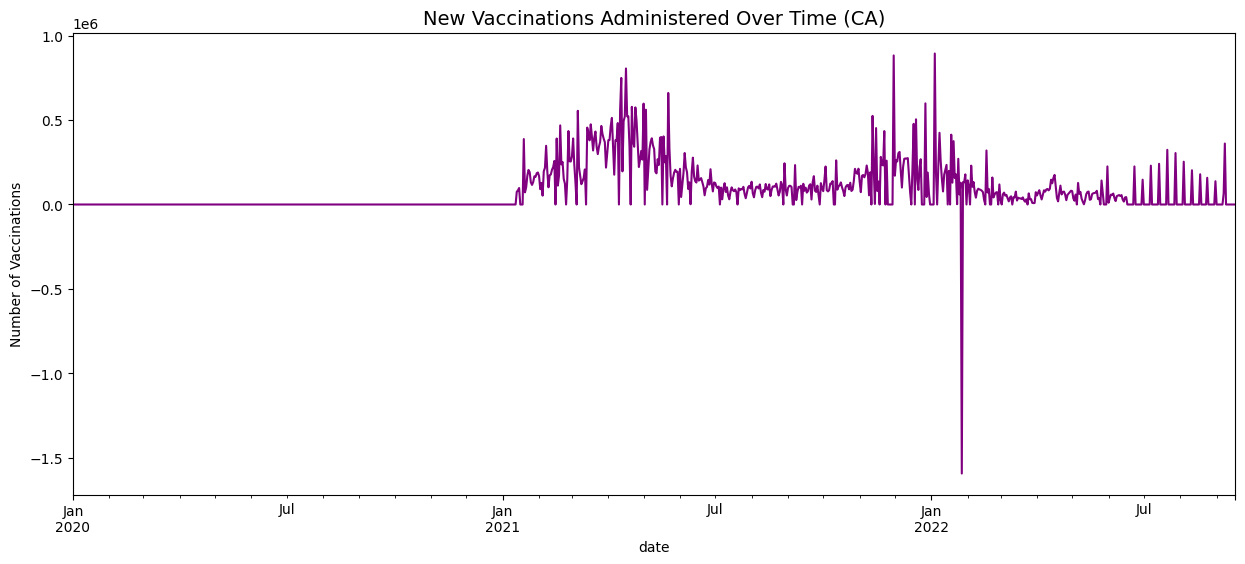

In [ ]:
# Plot the number of new vaccinations administered over time (globally)
fig, ax = plt.subplots(figsize=(15, 6))

data_filtered_vaccine.groupby('date')['new_vaccine_doses_administered'].sum().plot(ax=ax, color='purple')
ax.set_title('New Vaccinations Administered Over Time (CA)', fontsize=14)
ax.set_ylabel('Number of Vaccinations')

plt.show()

####3.6.1 Observations

From the graph, we can see that the number of new vaccinations administered each day fluctuates significantly, but with a general upward trend. This indicates that vaccination efforts have been scaling up over time, especially when there are surges in COVID-19 cases as exemplified by Jan 2021 and 2022 numbers. After the 2022 case surge, the vaccinations slowly dwindle as number of cases decreases as well.

However, the fluctuations could be due to a variety of factors, such as changes in vaccine supply, logistical challenges, or variations in data reporting practices.



##4. Important Factors Analysis

### 4.1 General Correlation Between Certain Factors

First, let's look at the correlations among the variables related to COVID-19 cases, deaths, testing, hospitalizations, and environmental factors. Correlation analysis can provide insights into how these variables are related to each other.

In [ ]:
# Calculate correlations among certain variables
correlation_columns = [
    'new_confirmed', 'new_deceased', 'new_tested', 'new_hospitalized_patients',
    'average_temperature_celsius', 'minimum_temperature_celsius', 'maximum_temperature_celsius', 'rainfall_mm',
    'public_information_campaigns', 'vaccination_policy'
]
correlation_data = data_filtered[correlation_columns]

correlation_matrix = correlation_data.corr()

correlation_matrix

new_confirmed  new_deceased  new_tested  \
new_confirmed                      1.000000      0.439454    0.865918   
new_deceased                       0.439454      1.000000    0.549762   
new_tested                         0.865918      0.549762    1.000000   
new_hospitalized_patients          0.647023      0.496242    0.852472   
average_temperature_celsius       -0.013971     -0.007892   -0.044428   
minimum_temperature_celsius       -0.019690     -0.016008   -0.483741   
maximum_temperature_celsius       -0.009489     -0.004140    0.206650   
rainfall_mm                       -0.002087      0.011588    0.130298   
public_information_campaigns       0.121748      0.182492    0.243482   
vaccination_policy                 0.184238     -0.067930    0.700369   

                              new_hospitalized_patients  \
new_confirmed                                  0.647023   
new_deceased                                   0.496242   
new_tested                                     0.852472   
new_hospitalized_patients                      1.000000   
average_temperature_celsius                   -0.365146   
minimum_temperature_celsius                   -0.334994   
maximum_temperature_celsius                   -0.365232   
rainfall_mm                                    0.029932   
public_information_campaigns                   0.114325   
vaccination_policy                             0.088041   

                              average_temperature_celsius  \
new_confirmed                                   -0.013971   
new_deceased                                    -0.007892   
new_tested                                      -0.044428   
new_hospitalized_patients                       -0.365146   
average_temperature_celsius                      1.000000   
minimum_temperature_celsius                      0.930141   
maximum_temperature_celsius                      0.962644   
rainfall_mm                                     -0.198764   
public_information_campaigns                     0.282923   
vaccination_policy                               0.052511   

                              minimum_temperature_celsius  \
new_confirmed                                   -0.019690   
new_deceased                                    -0.016008   
new_tested                                      -0.483741   
new_hospitalized_patients                       -0.334994   
average_temperature_celsius                      0.930141   
minimum_temperature_celsius                      1.000000   
maximum_temperature_celsius                      0.815019   
rainfall_mm                                     -0.123832   
public_information_campaigns                     0.257415   
vaccination_policy                               0.062396   

                              maximum_temperature_celsius  rainfall_mm  \
new_confirmed                                   -0.009489    -0.002087   
new_deceased                                    -0.004140     0.011588   
new_tested                                       0.206650     0.130298   
new_hospitalized_patients                       -0.365232     0.029932   
average_temperature_celsius                      0.962644    -0.198764   
minimum_temperature_celsius                      0.815019    -0.123832   
maximum_temperature_celsius                      1.000000    -0.248554   
rainfall_mm                                     -0.248554     1.000000   
public_information_campaigns                     0.295357     0.009713   
vaccination_policy                               0.041320    -0.001699   

                              public_information_campaigns  vaccination_policy  
new_confirmed                                     0.121748            0.184238  
new_deceased                                      0.182492           -0.067930  
new_tested                                        0.243482            0.700369  
new_hospitalized_patients                         0.114325            0.088041  
average_temp

#### 4.1.1 Visualization: Correlation Heatmap

We can also visualize this intuitively with a heatmap:

In [ ]:
#TODO check if this works well
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap Between Various Factors')
plt.show()

####4.1.2 Observations

Cases, Deaths, Testing, and Hospitalizations: These variables are all positively correlated, as expected. This suggests that as the number of tests increases, so does the number of confirmed cases, deaths, and hospitalized patients.

Temperature and Rainfall: The temperature variables (average, minimum, and maximum) are negatively correlated with the number of tests and new hospitalizations. This could suggest that testing and hospitalizations decrease when the temperature is higher, although more detailed analysis would be needed to confirm this. There's a weak negative correlation between rainfall and temperature.

Public Information Campaigns and Vaccination Policy: These policy-related variables are positively correlated with the number of tests, suggesting that places with these policies might also be doing more testing. Interestingly, the 'vaccination_policy' variable shows a negative correlation with deaths, which might suggest that places with vaccination policies have fewer deaths, although this would need to be confirmed with more detailed analysis.

###4.2 Linear Regression Analysis With Multiple Features

We can also look at how policy interventions like public information campaigns and vaccination policies are related to the number of confirmed cases and deaths. However, since policy interventions are likely categorical variables, we would need to handle them appropriately in the analysis.

Let's proceed with the multiple regression analysis first. We'll use 'average_temperature_celsius', 'rainfall_mm', and 'public_information_campaigns' as predictors, and 'new_confirmed' as the response variable. We'll use the same process as before: preparing the data, splitting it into training and test sets, fitting the model, making predictions, and assessing the model's performance.

In [ ]:
# Remove rows with missing values in the columns we're interested in
regression_data = data_filtered.dropna(subset=['average_temperature_celsius', 'rainfall_mm', 'public_information_campaigns', 'new_confirmed'])

# Prepare the data for regression
X = regression_data[['average_temperature_celsius', 'rainfall_mm', 'public_information_campaigns']]  # Predictor variables
y = regression_data['new_confirmed']  # Response variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error of the model's predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get the model's coefficients
coef = model.coef_
intercept = model.intercept_

coef, intercept, rmse

(array([ -914.86775959,  -638.34863958, 14004.80467284]),
 941.8537839660785,
 16170.398893347112)

####4.2.1 Observations

For every increase of 1 degree Celsius in temperature, the model predicts a decrease of about 914.87 in the 'new_confirmed' cases, holding all other variables constant.

For every increase of 1 mm in rainfall, the model predicts a decrease of about 638.35 in the 'new_confirmed' cases, holding all other variables constant.

For every unit increase in 'public_information_campaigns', the model predicts an increase of about 14004.80 in the 'new_confirmed' cases, holding all other variables constant.

The intercept is approximately 941.85. This can be interpreted as the model's prediction for 'new_confirmed' when all predictor variables are zero. However, since some of these values might not make sense in context (like zero temperature or zero rainfall), this intercept might not have a meaningful interpretation in this case.

###4.3 Relationship Analysis: Vaccination Policies VS Cases and Deaths

let's continue by examining the relationship between vaccination policies and COVID-19 outcomes (i.e., confirmed cases and deaths). Since policy variables are typically categorical rather than numerical, we can use a different approach to analyze their impact.

For example, we could calculate the average number of new confirmed cases and deaths for each category of the 'vaccination_policy' variable. This would give us a sense of how these outcomes differ depending on the vaccination policy.

In [ ]:
# Get a sense of the 'vaccination_policy' variable structure
vaccination_policy_counts = data_filtered['vaccination_policy'].value_counts()

vaccination_policy_counts

5.0    467
0.0    349
2.0     90
3.0     31
Name: vaccination_policy, dtype: int64

The 'vaccination_policy' variable appears to be a multi-category variable, with categories 0, 2, 3, and 5. This suggests different levels of vaccination policies.

Now let's calculate the average number of new confirmed cases and deaths for each category of the 'vaccination_policy' variable. This will help us understand if there's a noticeable difference in COVID-19 outcomes depending on the vaccination policy in place.

In [ ]:
average_cases_by_policy = data_filtered.groupby('vaccination_policy')['new_confirmed'].mean()
average_deaths_by_policy = data_filtered.groupby('vaccination_policy')['new_deceased'].mean()

average_cases_by_policy, average_deaths_by_policy

(vaccination_policy
 0.0     4832.423780
 2.0    21555.411111
 3.0     2771.838710
 5.0    14742.312634
 Name: new_confirmed, dtype: float64,
 vaccination_policy
 0.0     64.164634
 2.0    393.155556
 3.0    135.064516
 5.0     69.918630
 Name: new_deceased, dtype: float64)

####4.3.1 Observations

Average New Confirmed Cases by Vaccination Policy:

Policy 0: Approximately 4832 cases

Policy 2: Approximately 21555 cases

Policy 3: Approximately 2772 cases

Policy 5: Approximately 14742 cases

Average New Deaths by Vaccination Policy:

Policy 0: Approximately 64 deaths

Policy 2: Approximately 393 deaths

Policy 3: Approximately 135 deaths

Policy 5: Approximately 70 deaths

Due to variations in both case counts and deaths, we cannot observe if any of the differing policies are stricter or have been more effective

###4.4 Correlation Analysis: Cases and Search Trends

Now, lets examine the correlation between confirmed COVID-19 cases and Google search trends for health conditions such as diabetes, obesity, and anxiety. This could give us some insights into public awareness or concern about these conditions during the pandemic.

In [ ]:
# Calculate correlations among certain variables
correlation_columns = [
    'new_confirmed',
    'search_trends_diabetes', 'search_trends_obesity', 'search_trends_anxiety'
]
correlation_data = data_filtered[correlation_columns]

correlation_matrix = correlation_data.corr()

correlation_matrix

new_confirmed  search_trends_diabetes  \
new_confirmed                1.000000               -0.017504   
search_trends_diabetes      -0.017504                1.000000   
search_trends_obesity       -0.024958                0.421113   
search_trends_anxiety       -0.016335                0.440987   

                        search_trends_obesity  search_trends_anxiety  
new_confirmed                       -0.024958              -0.016335  
search_trends_diabetes               0.421113               0.440987  
search_trends_obesity                1.000000               0.355836  
search_trends_anxiety                0.355836               1.000000

#### 4.4.1 Observations

The correlations between 'new_confirmed' and the search trends ('search_trends_diabetes', 'search_trends_obesity', 'search_trends_anxiety') are negative but very close to zero. This suggests that there is no strong linear relationship between the number of new confirmed cases and the search trends for these health conditions.

The search trends for diabetes, obesity, and anxiety are positively correlated with each other. This suggests that when search interest in one of these conditions increases, search interest in the others tends to increase as well.

###4.5 Linear Regression Analysis: Search Trends to New Cases

Let's explore how 'search_trends_diabetes' is related to 'new_confirmed'. We'll use a simple linear regression model for this analysis. Note that this model assumes a linear relationship between the two variables and does not account for other factors that might influence the number of confirmed cases.

In [ ]:
# Remove rows with missing values in the columns we're interested in
regression_data = data_filtered.dropna(subset=['search_trends_diabetes', 'new_confirmed'])

# Prepare the data for regression
X = regression_data[['search_trends_diabetes']]  # Predictor variable
y = regression_data['new_confirmed']  # Response variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error of the model's predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get the model's coefficients
coef = model.coef_[0]
intercept = model.intercept_

coef, intercept, rmse

(-40.45053814976804, 804.3652497332168, 4299.1036604609835)

####4.5.1 Observations

The coefficient of 'search_trends_diabetes' is approximately -40.45. This indicates that, on average, for every unit increase in the 'search_trends_diabetes', the model predicts a decrease of about 40.45 in the 'new_confirmed' cases.

The intercept is approximately 804.36. This can be interpreted as the model's prediction for 'new_confirmed' when 'search_trends_diabetes' is zero.

The root mean squared error (RMSE) of the model's predictions is approximately 4299.10. This is a measure of the model's prediction error, which tells us how close the model's predictions are to the actual values, on average. The smaller the RMSE, the better the model's predictions.

###4.6 Visualization: New Cases, Deaths, and Vaccinations Over Time

let's proceed by investigating the temporal trends in our data. Specifically, we can look at how the number of new confirmed cases, new deaths, and new vaccinations have changed over time. This can provide insights into the progression of the pandemic and the rollout of vaccinations.

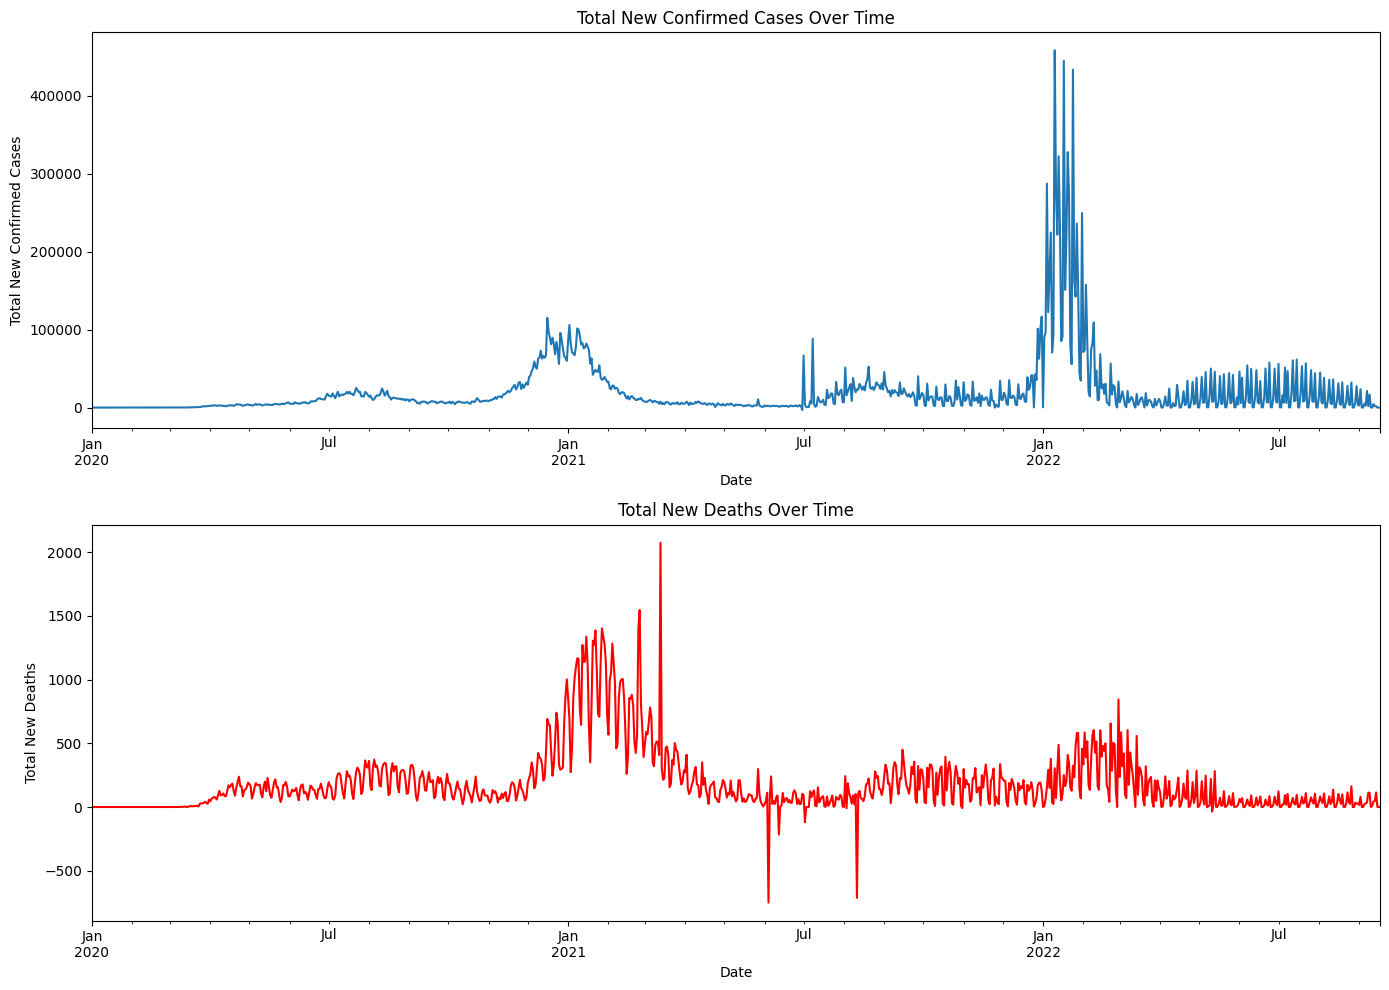

In [ ]:
# Calculate total number of new confirmed cases, new deaths, and new vaccinations for each date
total_cases_by_date = data_filtered.groupby('date')['new_confirmed'].sum()
total_deaths_by_date = data_filtered.groupby('date')['new_deceased'].sum()

# Plot the totals over time
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
total_cases_by_date.plot()
plt.title('Total New Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Total New Confirmed Cases')

plt.subplot(2, 1, 2)
total_deaths_by_date.plot(color='red')
plt.title('Total New Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Total New Deaths')

plt.tight_layout()
plt.show()

####4.6.1 Observations

From the plots, we can observe the following trends:

Total New Confirmed Cases Over Time: There appears to be a fluctuating trend in the total number of new confirmed cases over time, with several peaks and troughs. This could reflect waves of the pandemic, with the number of cases increasing during each wave and then decreasing.

Total New Deaths Over Time: The total number of new deaths also seems to fluctuate over time, possibly in relation to the waves of new confirmed cases. However, the trends in deaths might lag behind the trends in cases, as there is typically some delay between when a person is confirmed to have COVID-19 and when they might die from the disease.

7-Day Rolling Average of New Tested Cases Over Time: The rolling average of new tested cases shows fluctuations over time. This could reflect changes in testing capacity and strategy, as well as the spread of the virus.

7-Day Rolling Average of New Hospitalizations Over Time: The rolling average of new hospitalizations also fluctuates over time. Peaks in hospitalizations might lag behind peaks in tested cases, as there is typically some delay between when a person is confirmed to have COVID-19 and when they might need hospital care.

## 5. Environmental Analysis

let's continue by investigating the relationship between environmental factors and COVID-19 outcomes.

###5.1. Correlation: New Cases, Deaths, Temperature, Rainfall

First, let's calculate the correlation coefficients between these variables. Then we can explore these relationships in more detail using regression analysis. Let's start with the correlation analysis.

In [ ]:
# Calculate correlations among certain variables
correlation_columns = [
    'new_confirmed', 'new_deceased',
    'average_temperature_celsius', 'rainfall_mm'
]
correlation_data = data_filtered[correlation_columns]

correlation_matrix = correlation_data.corr()

correlation_matrix

new_confirmed  new_deceased  \
new_confirmed                     1.000000      0.439454   
new_deceased                      0.439454      1.000000   
average_temperature_celsius      -0.013971     -0.007892   
rainfall_mm                      -0.002087      0.011588   

                             average_temperature_celsius  rainfall_mm  
new_confirmed                                  -0.013971    -0.002087  
new_deceased                                   -0.007892     0.011588  
average_temperature_celsius                     1.000000    -0.198764  
rainfall_mm                                    -0.198764     1.000000

#### 5.1.1 Observations

The correlations between 'new_confirmed', 'new_deceased', and the environmental variables are very close to zero. This suggests that there is no strong linear relationship between these variables.

'average_temperature_celsius' and 'rainfall_mm' are negatively correlated with each other. This suggests that higher average temperatures tend to be associated with lower rainfall, and vice versa.

### 5.2 Linear Regression Analysis: Temperature and New Cases

We can explore how 'average_temperature_celsius' is related to 'new_confirmed'. We'll use a simple linear regression model for this analysis.

In [ ]:
# Remove rows with missing values in the columns we're interested in
regression_data = data_filtered.dropna(subset=['average_temperature_celsius', 'new_confirmed'])

# Prepare the data for regression
X = regression_data[['average_temperature_celsius']]  # Predictor variable
y = regression_data['new_confirmed']  # Response variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error of the model's predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get the model's coefficients
coef = model.coef_[0]
intercept = model.intercept_

coef, intercept, rmse

(-8.474202847742786, 560.1895554700862, 3676.0743544044813)

#### 5.2.1 Observations

The results of the linear regression analysis are as follows:

The coefficient of 'average_temperature_celsius' is approximately -8.47. This indicates that, on average, for every increase of 1 degree Celsius in temperature, the model predicts a decrease of about 8.47 in the 'new_confirmed' cases. While insignificant, it does empower public analysis ttat lower temperature leads to increased number of cases, even in warmer states like California.

The intercept is approximately 560.19. This can be interpreted as the model's prediction for 'new_confirmed' when 'average_temperature_celsius' is zero. Conceptually, such low numbers could be achieved if California gets that cold(32 degrees F), but is unrealistic.

The root mean squared error (RMSE) of the model's predictions is approximately 3676.07. This is a measure of the model's prediction error, which tells us how close the model's predictions are to the actual values, on average. The smaller the RMSE, the better the model's predictions. This is a relatively large error, **signifying that the linear relationship between temperature and case counts in CA is not exactly valid**.

### 5.3 Linear Regression Analysis: Rainfall and New Cases

Let's continue by examining the relationship between 'rainfall_mm' and 'new_confirmed'. We'll use a similar process as before: preparing the data, splitting it into training and test sets, fitting the model, making predictions, and assessing the model's performance.

In [ ]:
# Remove rows with missing values in the columns we're interested in
regression_data = data_filtered.dropna(subset=['rainfall_mm', 'new_confirmed'])

# Prepare the data for regression
X = regression_data[['rainfall_mm']]  # Predictor variable
y = regression_data['new_confirmed']  # Response variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error of the model's predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get the model's coefficients
coef = model.coef_[0]
intercept = model.intercept_

coef, intercept, rmse

(-8.236421687161684, 434.24326669265577, 3676.4231979633287)

#### 5.3.1 Observations

The coefficient of 'rainfall_mm' is approximately -8.24. This indicates that, on average, for every unit increase in rainfall, the model predicts a decrease of about 8.24 in the 'new_confirmed' cases. This is in line with the results of the regression on temperature, while insignificantly small.

The intercept is approximately 434.24. This can be interpreted as the model's prediction for 'new_confirmed' when there is no rainfall.

The root mean squared error (RMSE) of the model's predictions is approximately 3676.42. This is a measure of the model's prediction error, which tells us how close the model's predictions are to the actual values, on average. The smaller the RMSE, the better the model's predictions.

## 6. Demographic Analysis



###6.1 Relationship Analysis: Demographics VS New Cases

let's investigate the relationship between demographic data (age and gender) and the number of new confirmed cases.

It is possible that COVID-19 affects different age groups and genders differently, so it could be informative to see how the number of confirmed cases varies by age and gender.

In [ ]:
# Calculate correlations among certain variables
correlation_columns = [
    'new_confirmed',
    'new_confirmed_male', 'new_confirmed_female',
    'new_confirmed_age_0', 'new_confirmed_age_1', 'new_confirmed_age_2',
    'new_confirmed_age_3', 'new_confirmed_age_4', 'new_confirmed_age_5'
]
correlation_data = data_filtered[correlation_columns]

correlation_matrix = correlation_data.corr()

correlation_matrix

new_confirmed  new_confirmed_male  new_confirmed_female  \
new_confirmed              1.000000            0.542351              0.534975   
new_confirmed_male         0.542351            1.000000              0.999136   
new_confirmed_female       0.534975            0.999136              1.000000   
new_confirmed_age_0        0.488011            0.965920              0.963306   
new_confirmed_age_1        0.489806            0.994941              0.996257   
new_confirmed_age_2        0.481919            0.991884              0.991589   
new_confirmed_age_3        0.441911            0.951682              0.951679   
new_confirmed_age_4        0.359013            0.234451              0.227164   
new_confirmed_age_5        0.058238            0.036923              0.035320   

                      new_confirmed_age_0  new_confirmed_age_1  \
new_confirmed                    0.488011             0.489806   
new_confirmed_male               0.965920             0.994941   
new_confirmed_female             0.963306             0.996257   
new_confirmed_age_0              1.000000             0.945313   
new_confirmed_age_1              0.945313             1.000000   
new_confirmed_age_2              0.932982             0.987786   
new_confirmed_age_3              0.874467             0.941262   
new_confirmed_age_4              0.221525             0.234865   
new_confirmed_age_5              0.034159             0.037509   

                      new_confirmed_age_2  new_confirmed_age_3  \
new_confirmed                    0.481919             0.441911   
new_confirmed_male               0.991884             0.951682   
new_confirmed_female             0.991589             0.951679   
new_confirmed_age_0              0.932982             0.874467   
new_confirmed_age_1              0.987786             0.941262   
new_confirmed_age_2              1.000000             0.979319   
new_confirmed_age_3              0.979319             1.000000   
new_confirmed_age_4              0.250370             0.261652   
new_confirmed_age_5              0.040241             0.041714   

                      new_confirmed_age_4  new_confirmed_age_5  
new_confirmed                    0.359013             0.058238  
new_confirmed_male               0.234451             0.036923  
new_confirmed_female             0.227164             0.035320  
new_confirmed_age_0              0.221525             0.034159  
new_confirmed_age_1              0.234865             0.037509  
new_confirmed_age_2              0.250370             0.040241  
new_confirmed_age_3              0.261652             0.041714  
new_confirmed_age_4              1.000000             0.175365  
new_confirmed_age_5              0.175365             1.000000

####6.1.1 Observations

The number of new confirmed cases is moderately correlated with the number of confirmed cases in males and females. This suggests that there is a relationship between these variables, but other factors also play a significant role. This is an intuitive result, as we generally expect equal distributions between male and female COVID-19 cases. The gender neutrality in COVID-19 new cases is also explained by the high correlation between them.

The number of new confirmed cases is moderately correlated with the number of confirmed cases in the 'age_0' to 'age_3' groups. These correlations are weaker for the 'age_4' group and very weak for the 'age_5' group. This suggests that the number of confirmed cases in these age groups doesn't strongly predict the total number of new confirmed cases.

General observation of this correlation matrix reveals that **there is no significant bias in our data toward certain gender or age group** on new COVID-19 cases **with the exception of age group 5, the oldest group**, a cohort which has a very weak correlation all around compared to other age groups.

This is an interesting observation that deserves a closer study. Since our dataset has equal number of tuples on each age groups, this is not because of lack of data. The results clearly show that older age groups are very weakly linked to the general population and their COVID-19 cases, which may be linked to various socioeconomic factors outside the scope of this analysis.

## 7. Policy Analysis

### 7.1 Relationship Analysis: New Cases, Deaths, and Public Campaigns

Next, let's analyze the impacts of policy interventions on the spread and outcomes of COVID-19. We'll start by investigating how the 'public_information_campaigns' policy relates to the number of new confirmed cases and deaths.

In [ ]:
# Calculate correlations among certain variables
correlation_columns = [
    'new_confirmed', 'new_deceased', 'public_information_campaigns'
]
correlation_data = data_filtered[correlation_columns]

correlation_matrix = correlation_data.corr()

correlation_matrix

new_confirmed  new_deceased  \
new_confirmed                      1.000000      0.439454   
new_deceased                       0.439454      1.000000   
public_information_campaigns       0.121748      0.182492   

                              public_information_campaigns  
new_confirmed                                     0.121748  
new_deceased                                      0.182492  
public_information_campaigns                      1.000000

####7.1.1 Observations

From the matrix, we can observe that:

'public_information_campaigns' is weakly correlated with 'new_confirmed' and 'new_deceased'. This suggests that there is a weak relationship between the public information campaigns and the spread and outcomes of COVID-19, according to this data.

###7.2 Linear Regression Analysis

Next, let's explore these relationships in more detail using regression analysis.

In [ ]:
# Remove rows with missing values in the columns we're interested in
regression_data = data_filtered.dropna(subset=['public_information_campaigns', 'new_confirmed'])

# Prepare the data for regression
X = regression_data[['public_information_campaigns']]  # Predictor variable
y = regression_data['new_confirmed']  # Response variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error of the model's predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get the model's coefficients
coef = model.coef_[0]
intercept = model.intercept_

coef, intercept, rmse

(9116.521106370012, -5856.209996952153, 16635.77019984996)

####7.2.1 Observations

The coefficient of 'public_information_campaigns' is approximately 9116.52. This indicates that, on average, for every unit increase in the 'public_information_campaigns' policy score, the model predicts an increase of about 9116.52 in the 'new_confirmed' cases.

The intercept is approximately -5856.21. This can be interpreted as the model's prediction for 'new_confirmed' when the 'public_information_campaigns' score is zero.

The root mean squared error (RMSE) of the model's predictions is approximately 16635.77. This is a measure of the model's prediction error, which tells us how close the model's predictions are to the actual values, on average. The smaller the RMSE, the better the model's predictions.

###7.3 Further Regression

One approach could be to use multiple linear regression, which allows us to consider the effects of multiple predictor variables at the same time. For instance, we can build a model that predicts the number of new confirmed cases based on the 'public_information_campaigns' policy, 'average_temperature_celsius', and 'rainfall_mm'.

In [ ]:
# Remove rows with missing values in the columns we're interested in
regression_data = data_filtered.dropna(subset=['public_information_campaigns', 'average_temperature_celsius', 'rainfall_mm', 'new_confirmed'])

# Prepare the data for regression
X = regression_data[['public_information_campaigns', 'average_temperature_celsius', 'rainfall_mm']]  # Predictor variables
y = regression_data['new_confirmed']  # Response variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error of the model's predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Get the model's coefficients
coefficients = dict(zip(X.columns, model.coef_))
intercept = model.intercept_

coefficients, intercept, rmse

({'public_information_campaigns': 14004.804672844277,
  'average_temperature_celsius': -914.867759587503,
  'rainfall_mm': -638.3486395766902},
 941.8537839660621,
 16170.398893347112)

####7.3.1 Observations

The coefficients are approximately 14004.80 for 'public_information_campaigns', -914.87 for 'average_temperature_celsius', and -638.35 for 'rainfall_mm'.

This means that, on average, for every unit increase in the 'public_information_campaigns' score, the model predicts an increase of about 14004.80 in the 'new_confirmed' cases, holding all other variables constant.
For every unit increase in the average temperature, the model predicts a decrease of about 914.87 in the 'new_confirmed' cases, holding all other variables constant.
For every unit increase in rainfall, the model predicts a decrease of about 638.35 in the 'new_confirmed' cases, holding all other variables constant.

In [ ]:
data_filtered['state'] = data_filtered['location_key'].str.split('_').str[1]
data_filtered['county'] = data_filtered['location_key'].str.split('_').str[2]

# Filter data for California
data_CA = data_filtered[data_filtered['state'] == 'CA']

# Calculate total number of confirmed cases and deaths for each date and county
total_cases_by_date_county = data_CA.groupby(['date', 'county'])['new_confirmed'].sum().reset_index()
total_deaths_by_date_county = data_CA.groupby(['date', 'county'])['new_deceased'].sum().reset_index()

total_cases_by_date_county, total_deaths_by_date_county

<ipython-input-61-bd1ee180cf40>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['state'] = data_filtered['location_key'].str.split('_').str[1]
<ipython-input-61-bd1ee180cf40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['county'] = data_filtered['location_key'].str.split('_').str[2]


(             date county  new_confirmed
 0      2020-01-01  06001            0.0
 1      2020-01-01  06003            0.0
 2      2020-01-01  06005            0.0
 3      2020-01-01  06007            0.0
 4      2020-01-01  06009            0.0
 ...           ...    ...            ...
 58464  2022-09-17  06109            0.0
 58465  2022-09-17  06111            0.0
 58466  2022-09-17  06113            0.0
 58467  2022-09-17  06115            0.0
 58468  2022-09-17    SFO            0.0
 
 [58469 rows x 3 columns],
              date county  new_deceased
 0      2020-01-01  06001           0.0
 1      2020-01-01  06003           0.0
 2      2020-01-01  06005           0.0
 3      2020-01-01  06007           0.0
 4      2020-01-01  06009           0.0
 ...           ...    ...           ...
 58464  2022-09-17  06109           0.0
 58465  2022-09-17  06111           0.0
 58466  2022-09-17  06113           0.0
 58467  2022-09-17  06115           0.0
 58468  2022-09-17    SFO           0.0

###7.4 Visualization: Total Cases and Death Over Time, 5 Top Counties

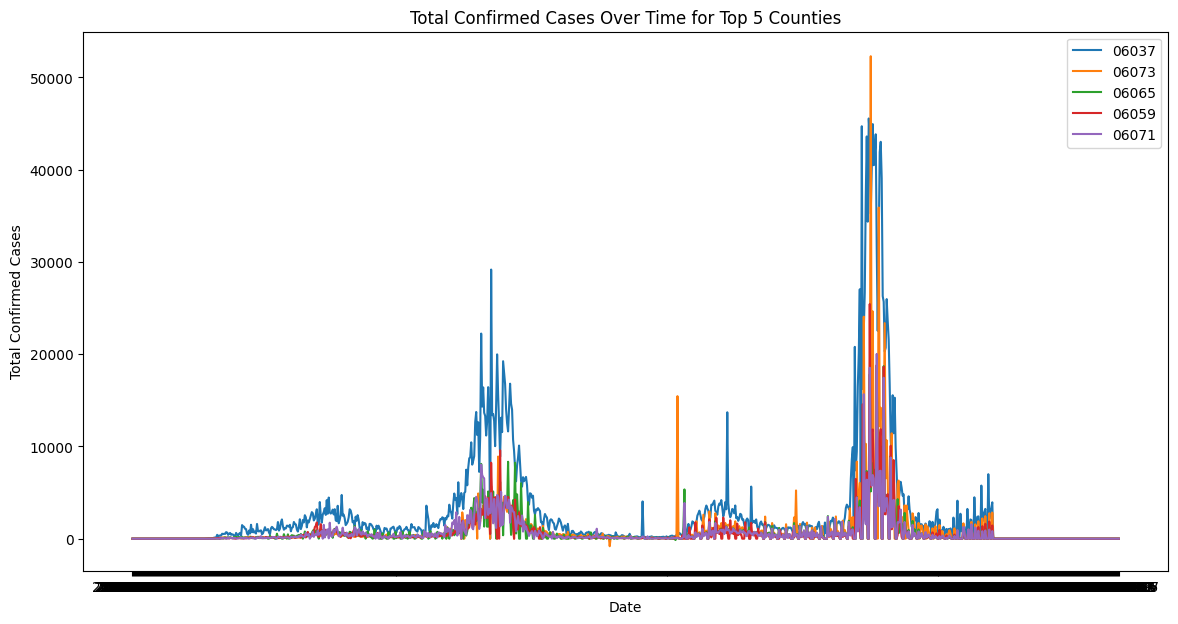

In [ ]:
# Find the top 5 counties with the highest total number of confirmed cases
top_counties = total_cases_by_date_county.groupby('county')['new_confirmed'].sum().nlargest(5).index

# Filter the data for these counties
top_counties_data = total_cases_by_date_county[total_cases_by_date_county['county'].isin(top_counties)]

#call index to figure out the counties by their names
index = pd.read_csv('index.csv')
usca_index = index[index['location_key'].notna() & index['location_key'].str.startswith('US_CA')].reset_index(drop=True)
usca_index = usca_index[['location_key','subregion2_name']]

county_name_dict = dict(zip(usca_index['location_key'], usca_index['subregion2_name']))

# Create a line plot for each county
plt.figure(figsize=(14, 7))
for county in top_counties:
    county_name = county_name_dict.get(county)
    county_data = top_counties_data[top_counties_data['county'] == county]
    plt.plot(county_data['date'], county_data['new_confirmed'], label=county_name)

plt.title('Total Confirmed Cases Over Time for Top 5 Counties')
plt.xlabel('Date')
plt.ylabel('Total Confirmed Cases')
plt.legend()
plt.show()

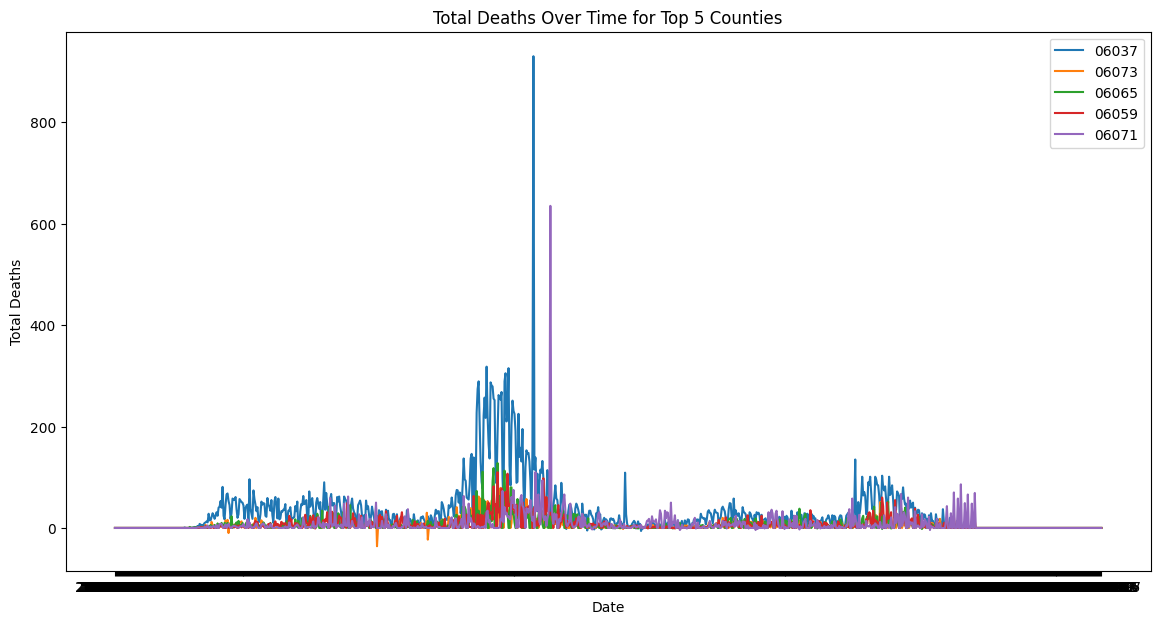

In [ ]:
# Filter the death data for the top counties
top_counties_death_data = total_deaths_by_date_county[total_deaths_by_date_county['county'].isin(top_counties)]

# Create a line plot for each county
plt.figure(figsize=(14, 7))
for county in top_counties:
    county_name = county_name_dict.get(county)
    county_data = top_counties_death_data[top_counties_death_data['county'] == county]
    plt.plot(county_data['date'], county_data['new_deceased'], label=county_name)

plt.title('Total Deaths Over Time for Top 5 Counties')
plt.xlabel('Date')
plt.ylabel('Total Deaths')
plt.legend()
plt.show()

#### 7.4.1 Observations

We see that despite different geographical and social settings, there is a general trend among counties for both new cases and deaths. This is also reflective of statewise vaccination trends that we will later depict.

In conclusion of the close study on cases and influcing factors, we generally see that the effects of disease is similarly replicated throughout the state of California.

##8. Vaccination Analysis


###8.1 Visualization: Vaccination Progress by Counties

Here, we attempt to visualize the vaccination rates for California as a whole and all counties in CA.

In [ ]:
#TODO: change file path to cleaned
df_vac_data = pd.read_csv('vaccinations.csv')


us_ca_and_counties = [
    "US_CA", "US_CA_06001", "US_CA_06003", "US_CA_06005", "US_CA_06007", "US_CA_06009", "US_CA_06011",
    "US_CA_06013", "US_CA_06015", "US_CA_06017", "US_CA_06019", "US_CA_06021", "US_CA_06023",
    "US_CA_06025", "US_CA_06027", "US_CA_06029", "US_CA_06031", "US_CA_06033", "US_CA_06035",
    "US_CA_06037", "US_CA_06039", "US_CA_06041", "US_CA_06043", "US_CA_06045", "US_CA_06047",
    "US_CA_06049", "US_CA_06051", "US_CA_06053", "US_CA_06055", "US_CA_06057", "US_CA_06059",
    "US_CA_06061", "US_CA_06063", "US_CA_06065", "US_CA_06067", "US_CA_06069", "US_CA_06071",
    "US_CA_06073", "US_CA_06075", "US_CA_06077", "US_CA_06079", "US_CA_06081", "US_CA_06083",
    "US_CA_06085", "US_CA_06087", "US_CA_06089", "US_CA_06091", "US_CA_06093", "US_CA_06095",
    "US_CA_06097", "US_CA_06099", "US_CA_06101", "US_CA_06103", "US_CA_06105", "US_CA_06107",
    "US_CA_06109", "US_CA_06111", "US_CA_06113", "US_CA_06115", "US_CA_SFO"
]


CA_vac_df = df_vac_data[df_vac_data['location_key'].isin(us_ca_and_counties)]

date location_key  new_persons_vaccinated  \
1012216  2021-01-12        US_CA                     NaN   
1012217  2021-01-13        US_CA                 41005.0   
1012218  2021-01-14        US_CA                 57453.0   
1012219  2021-01-15        US_CA                 63389.0   
1012220  2021-01-19        US_CA                330582.0   
...             ...          ...                     ...   
1041461  2022-09-12  US_CA_06115                     NaN   
1041462  2022-09-13  US_CA_06115                     NaN   
1041463  2022-09-14  US_CA_06115                     NaN   
1041464  2022-09-15  US_CA_06115                     NaN   
1041465  2022-09-16  US_CA_06115                     NaN   

         cumulative_persons_vaccinated  new_persons_fully_vaccinated  \
1012216                       703540.0                           NaN   
1012217                       744545.0                       33600.0   
1012218                       801998.0                           0.0   
1012219                       865387.0                       70685.0   
1012220                      1195969.0                       56464.0   
...                                ...                           ...   
1041461                            NaN                           0.0   
1041462                            NaN                           0.0   
1041463                            NaN                           0.0   
1041464                            NaN                           0.0   
1041465                            NaN                          55.0   

         cumulative_persons_fully_vaccinated  new_vaccine_doses_administered  \
1012216                             100089.0                             NaN   
1012217                             133689.0                         75188.0   
1012218                                  NaN                         83804.0   
1012219                             204374.0                         97666.0   
1012220                             260838.0                        387471.0   
...                                      ...                             ...   
1041461                              43852.0                             NaN   
1041462                              43852.0                             NaN   
1041463                              43852.0                             NaN   
1041464                              43852.0                             NaN   
1041465                              43907.0                             NaN   

         cumulative_vaccine_doses_administered  new_persons_vaccinated_pfizer  \
1012216                               816301.0                            NaN   
1012217                               891489.0                            NaN   
1012218                               975293.0                            NaN   
1012219                              1072959.0                            NaN   
1012220                              1460430.0                            NaN   
...                                        ...                            ...   
1041461                                    NaN                            NaN   
1041462                                    NaN                            NaN   
1041463                                    NaN                            NaN   
1041464                                    NaN                            NaN   
1041465                                    NaN                            NaN   

         cumulative_persons_vaccinated_pfizer  ...  \
1012216                                   NaN  ...   
1012217                                   NaN  ...   
1012218                                   NaN  ...   
1012219                                   NaN  ...   
1012220                                   NaN  ...   
...                                       ...  ...   
1041461                                   NaN  ...   
1041462                                   NaN  ...   
1041463  

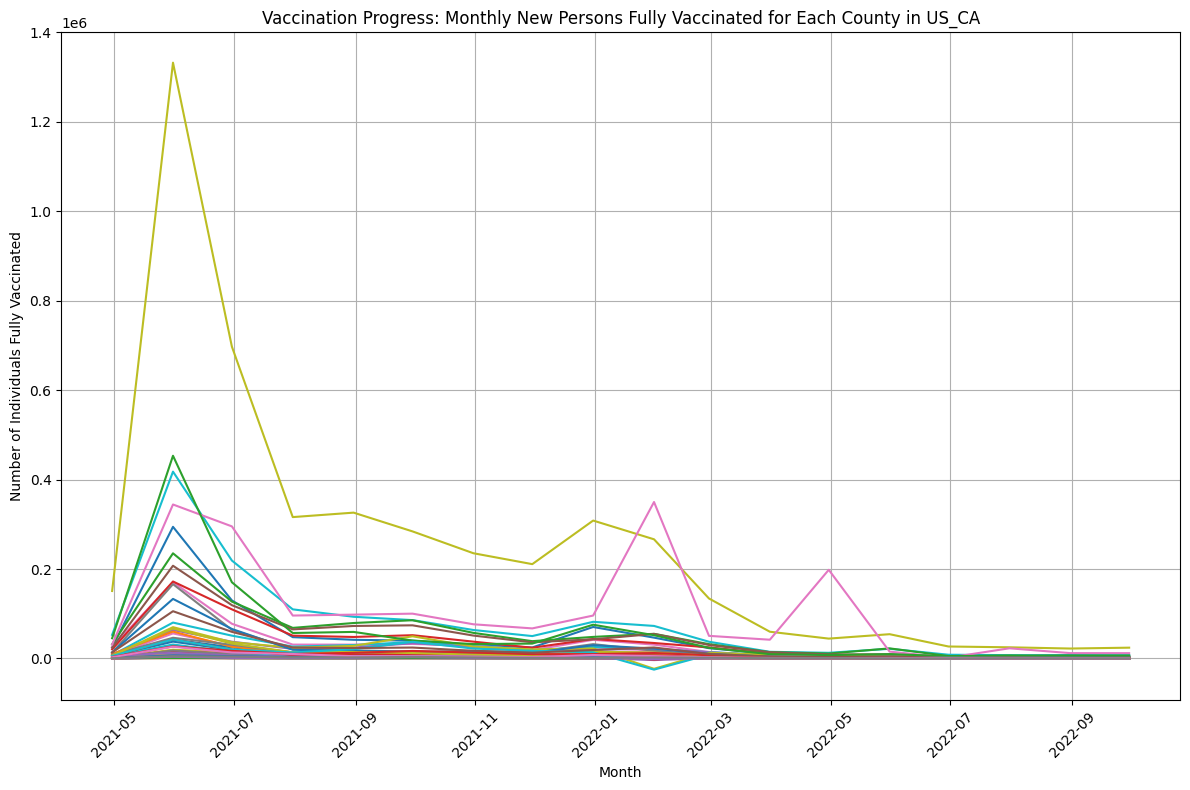

In [ ]:
# List of counties in US_CA
us_ca_counties = [
    "US_CA_06001", "US_CA_06003", "US_CA_06005", "US_CA_06007", "US_CA_06009", "US_CA_06011",
    "US_CA_06013", "US_CA_06015", "US_CA_06017", "US_CA_06019", "US_CA_06021", "US_CA_06023",
    "US_CA_06025", "US_CA_06027", "US_CA_06029", "US_CA_06031", "US_CA_06033", "US_CA_06035",
    "US_CA_06037", "US_CA_06039", "US_CA_06041", "US_CA_06043", "US_CA_06045", "US_CA_06047",
    "US_CA_06049", "US_CA_06051", "US_CA_06053", "US_CA_06055", "US_CA_06057", "US_CA_06059",
    "US_CA_06061", "US_CA_06063", "US_CA_06065", "US_CA_06067", "US_CA_06069", "US_CA_06071",
    "US_CA_06073", "US_CA_06075", "US_CA_06077", "US_CA_06079", "US_CA_06081", "US_CA_06083",
    "US_CA_06085", "US_CA_06087", "US_CA_06089", "US_CA_06091", "US_CA_06093", "US_CA_06095",
    "US_CA_06097", "US_CA_06099", "US_CA_06101", "US_CA_06103", "US_CA_06105", "US_CA_06107",
    "US_CA_06109", "US_CA_06111", "US_CA_06113", "US_CA_06115", "US_CA_SFO"
]

# Filter data for US_CA and its counties
us_ca_data_df = CA_vac_df[CA_vac_df['location_key'].isin(us_ca_counties)].copy()

# Convert the 'date' column to datetime data type for proper resampling
us_ca_data_df['date'] = pd.to_datetime(us_ca_data_df['date'])

# Create a dictionary to store monthly new fully vaccinated individuals for each county
monthly_fully_vaccinated_counties = {}

# Filter and process data for each county
for county in us_ca_counties:
    county_data = us_ca_data_df[us_ca_data_df['location_key'] == county].copy()
    county_data.set_index('date', inplace=True)
    monthly_fully_vaccinated = county_data.resample('M')['new_persons_fully_vaccinated'].sum()
    monthly_fully_vaccinated_counties[county] = monthly_fully_vaccinated

# Plotting the number of individuals fully vaccinated over time for each county in US_CA
plt.figure(figsize=(12, 8))
for county, monthly_fully_vaccinated in monthly_fully_vaccinated_counties.items():
    plt.plot(monthly_fully_vaccinated.index, monthly_fully_vaccinated)

plt.xlabel('Month')
plt.ylabel('Number of Individuals Fully Vaccinated')
plt.title('Vaccination Progress: Monthly New Persons Fully Vaccinated for Each County in US_CA')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


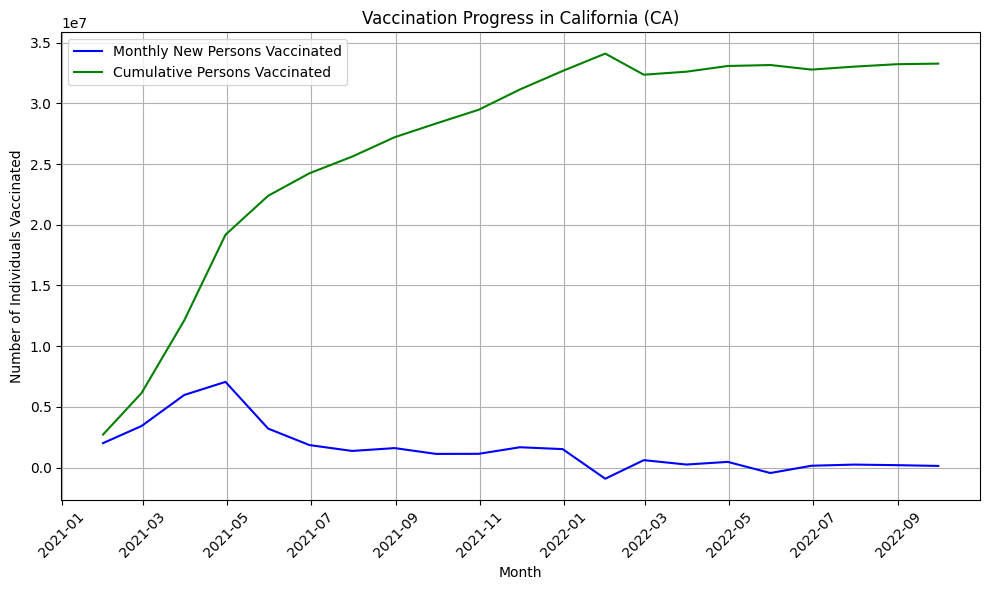

In [ ]:
# Filter data for California (CA) only
ca_data_df = CA_vac_df[CA_vac_df['location_key'] == 'US_CA'].copy()

# Convert the 'date' column to datetime data type for proper resampling
ca_data_df['date'] = pd.to_datetime(ca_data_df['date'])

# Set the 'date' column as the index for resampling
ca_data_df.set_index('date', inplace=True)

# Resample the data by month and calculate the sum of new vaccinated individuals for California
monthly_vaccinated_ca = ca_data_df.resample('M')['new_persons_vaccinated'].sum()
cumulative_vaccinated_ca = ca_data_df.resample('M')['cumulative_persons_vaccinated'].max()

# Plotting the number of individuals vaccinated over time for California (CA)
plt.figure(figsize=(10, 6))
plt.plot(monthly_vaccinated_ca.index, monthly_vaccinated_ca, label='Monthly New Persons Vaccinated', color='blue')
plt.plot(cumulative_vaccinated_ca.index, cumulative_vaccinated_ca, label='Cumulative Persons Vaccinated', color='green')

plt.xlabel('Month')
plt.ylabel('Number of Individuals Vaccinated')
plt.title('Vaccination Progress in California (CA)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

<ipython-input-5-ed135041fd62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_vac_df['date'] = pd.to_datetime(CA_vac_df['date'])


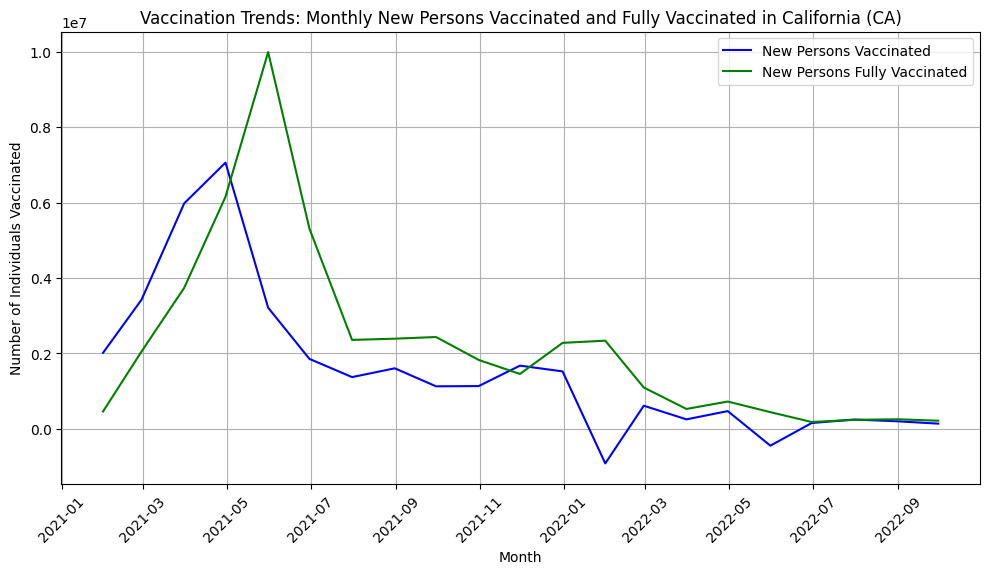

In [ ]:
CA_vac_df['date'] = pd.to_datetime(CA_vac_df['date'])

# Set the 'date' column as the index for resampling
CA_vac_df.set_index('date', inplace=True)

# Resample the data by month and calculate the sum of new persons vaccinated and fully vaccinated
monthly_new_vaccinated = CA_vac_df['new_persons_vaccinated'].resample('M').sum()
monthly_new_fully_vaccinated = CA_vac_df['new_persons_fully_vaccinated'].resample('M').sum()

# Plotting the trends in monthly new persons vaccinated and fully vaccinated over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_new_vaccinated.index, monthly_new_vaccinated, label='New Persons Vaccinated', color='blue')
plt.plot(monthly_new_fully_vaccinated.index, monthly_new_fully_vaccinated, label='New Persons Fully Vaccinated', color='green')

plt.xlabel('Month')
plt.ylabel('Number of Individuals Vaccinated')
plt.title('Vaccination Trends: Monthly New Persons Vaccinated and Fully Vaccinated in California (CA)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

####8.1.1 Observations

As with the number of new cases, we observe that trends in vaccinations are similarly replicated throughout the state and individual counties although there are clear differences in magnitudes.

##9. Time Series Analysis and Prediction

### 9.1 Visualization: Cases and Death Over Time

Now we will visualize the general statewide cases and death over time to start our analysis.

In [ ]:
# file_path11 = '/content/gdrive/My Drive/Finalproject/epidemiology.csv'
# df_CA = pd.read_csv(file_path11)
#TODO: change to epi_cleaned
df_CA = pd.read_csv('epidemiology.csv')
df_CA= df_CA[df_CA['location_key'].isin(us_ca_and_counties)].copy()

date location_key  new_confirmed  new_deceased  new_recovered  \
10041904  2020-01-22        US_CA            0.0           0.0            NaN   
10041905  2020-01-23        US_CA            0.0           0.0            NaN   
10041906  2020-01-24        US_CA            0.0           0.0            NaN   
10041907  2020-01-25        US_CA            0.0           0.0            NaN   
10041908  2020-01-26        US_CA            1.0           0.0            NaN   
...              ...          ...            ...           ...            ...   
10089467  2022-09-06    US_CA_SFO          199.0           NaN            NaN   
10089468  2022-09-07    US_CA_SFO          167.0           NaN            NaN   
10089469  2022-09-08    US_CA_SFO          141.0           NaN            NaN   
10089470  2022-09-09    US_CA_SFO          142.0           NaN            NaN   
10089471  2022-09-10    US_CA_SFO           77.0           NaN            NaN   

          new_tested  cumulative_confirmed  cumulative_deceased  \
10041904         NaN                   0.0                  0.0   
10041905         NaN                   0.0                  0.0   
10041906         NaN                   0.0                  0.0   
10041907         NaN                   1.0                  0.0   
10041908         NaN                   2.0                  0.0   
...              ...                   ...                  ...   
10089467      3036.0              224127.0                  NaN   
10089468      2534.0              224294.0                  NaN   
10089469      2215.0              224435.0                  NaN   
10089470      2933.0              224577.0                  NaN   
10089471      1162.0              224654.0                  NaN   

          cumulative_recovered  cumulative_tested  
10041904                   NaN                NaN  
10041905                   NaN                NaN  
10041906                   NaN                NaN  
10041907                   NaN                NaN  
10041908                   NaN                NaN  
...                        ...                ...  
10089467                   NaN          4442211.0  
10089468                   NaN          4444745.0  
10089469                   NaN          4446960.0  
10089470                   NaN          4449893.0  
10089471                   NaN          4451055.0  

[47568 rows x 10 columns]

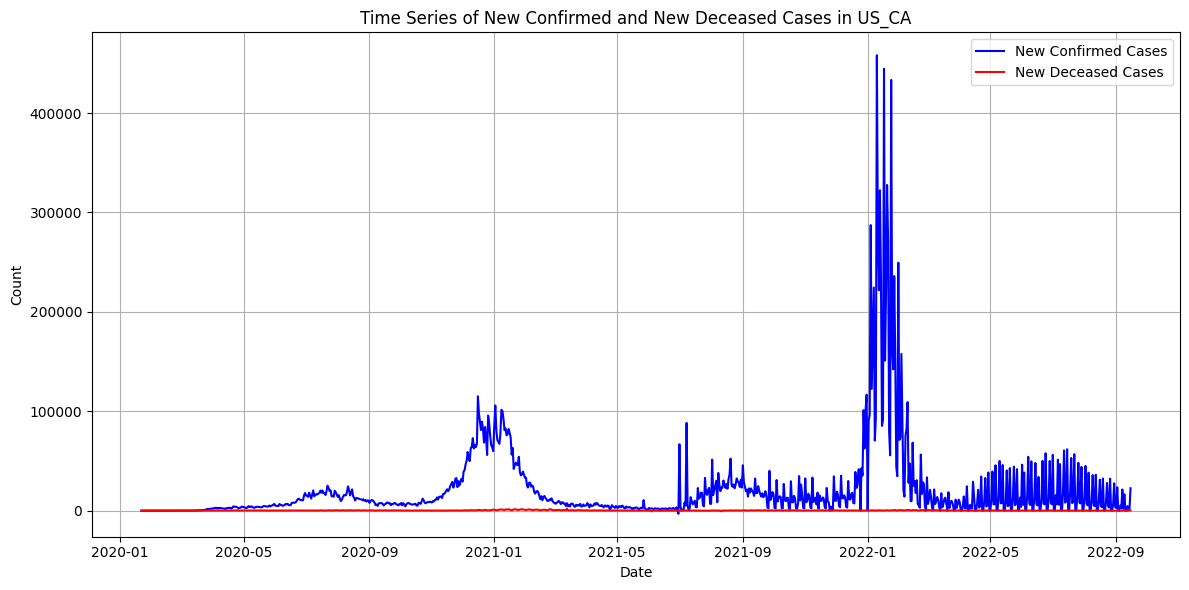

In [ ]:
df_CA['date'] = pd.to_datetime(df_CA['date'])

# Group the data by date and calculate the sum of new confirmed cases and new deceased cases
us_ca_time_series = df_CA.groupby('date')[['new_confirmed', 'new_deceased']].sum()

# Plotting Time Series for US_CA region
plt.figure(figsize=(12, 6))
plt.plot(us_ca_time_series.index, us_ca_time_series['new_confirmed'], label='New Confirmed Cases', color='blue')
plt.plot(us_ca_time_series.index, us_ca_time_series['new_deceased'], label='New Deceased Cases', color='red')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series of New Confirmed and New Deceased Cases in US_CA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

####9.1.1 Observation


There's a clear upward trend in the number of new confirmed cases, especially noticeable around mid to late 2020.
Multiple peaks can be observed, suggesting potential waves or surges of the virus.
After each major peak, there's a decline in cases, but they tend to rise again, indicating subsequent waves.
The latest data shows a decline in the number of new cases, but it's essential to monitor if another surge will follow.

###9.2 Autocorrelation and Partial Autocorrelation on Cases

The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots provide insights into the relationship between an observation and its previous time steps.

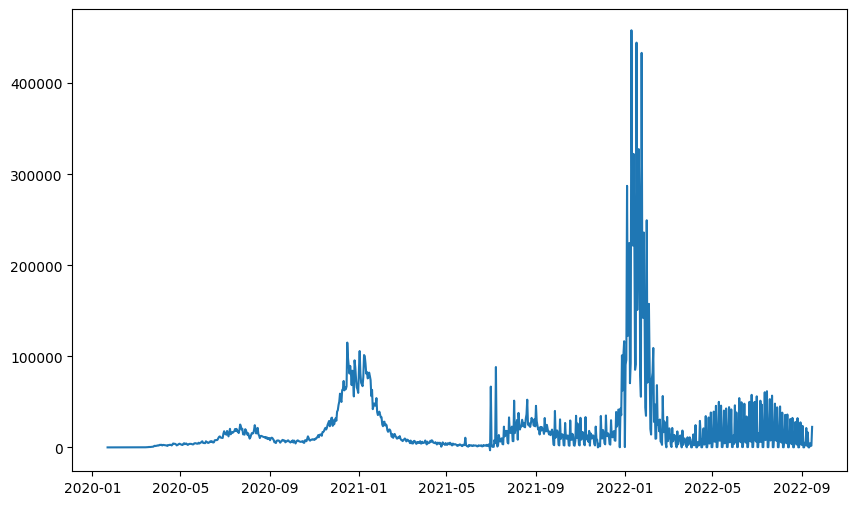

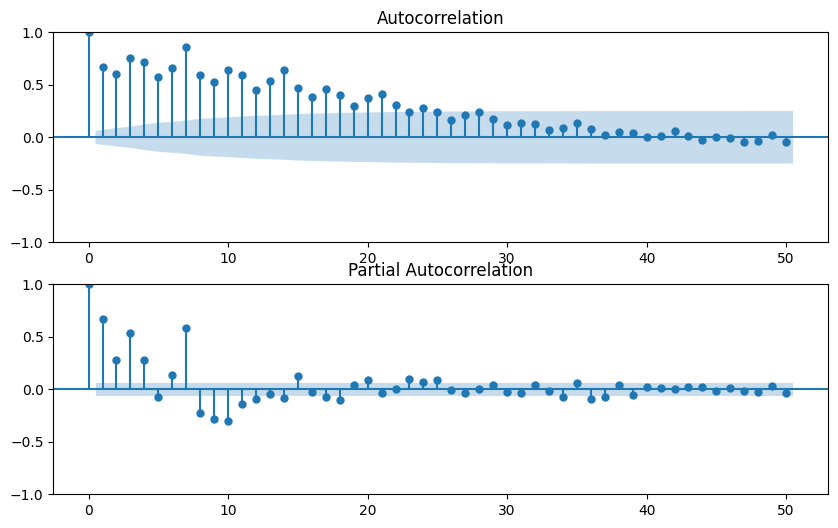

In [ ]:
import statsmodels.api as sm

# Plot the time series
plt.figure(figsize=(10,6))
plt.plot(us_ca_time_series['new_confirmed'])
plt.show()

# Perform ACF and PACF
fig, ax = plt.subplots(2, figsize=(10,6))
sm.graphics.tsa.plot_acf(us_ca_time_series['new_confirmed'], lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(us_ca_time_series['new_confirmed'], lags=50, ax=ax[1])
plt.show()

#### 9.2.1 Observations

ACF Plot:
The ACF shows a gradual decay, which suggests that the series is likely non-stationary. The significant lags can help determine the order of the MA (Moving Average) part of the model.

PACF Plot:
The PACF plot shows a sharp drop after the first lag, indicating a potential AR (AutoRegressive) order of 1.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Split the data into training and test sets
train = us_ca_time_series['new_confirmed'][:-90] # all but last 90 days for training
test = us_ca_time_series['new_confirmed'][-90:] # last 90 days for testing

model = ARIMA(us_ca_time_series['new_confirmed'], order=(1, 1, 1))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


###9.3 ARIMA: Fitting Our Model by Finding Parameters

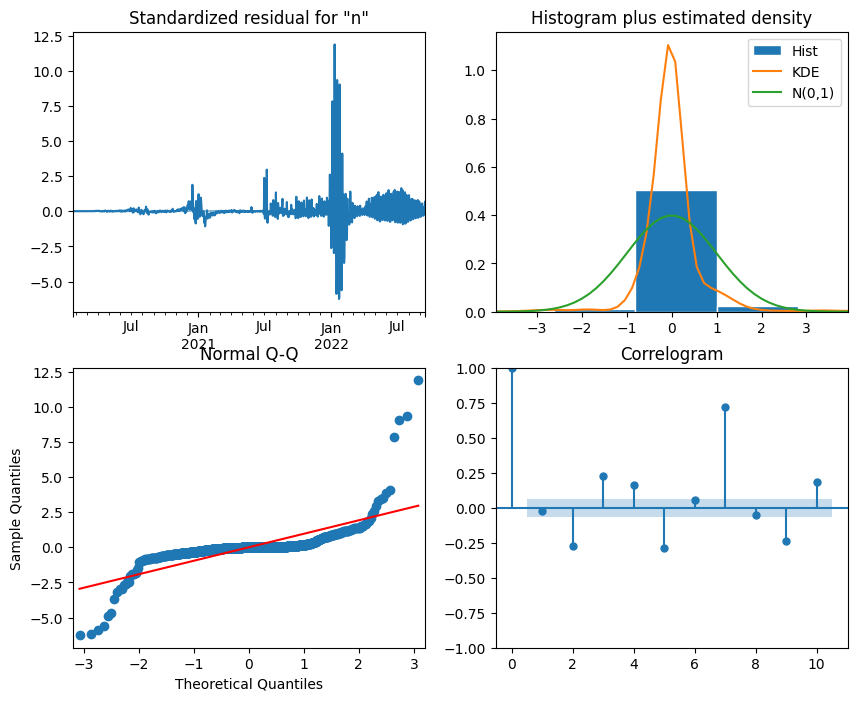

In [ ]:
model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
yhat = model_fit.predict(len(us_ca_time_series['new_confirmed']), len(us_ca_time_series['new_confirmed']), typ='levels')
print(yhat)

2022-09-16    6767.277723
Freq: D, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
!pip install pmdarima

from pmdarima.arima import auto_arima
us_ca_time_series['new_confirmed'] = us_ca_time_series['new_confirmed'].fillna(us_ca_time_series['new_confirmed'].mean())

# Fit auto_arima function to dataset
stepwise_fit = auto_arima(us_ca_time_series['new_confirmed'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise


print(stepwise_fit.summary())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=12.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=23192.000, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=22889.859, Time=1.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=23190.078, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=23158.316, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=22823.607, Time=3.04 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.76 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=23076.455, Time=3.71 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=22759.089, Time=3.68 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=22863.505, Time=1.98 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=11.99 sec
 ARIMA(2,0,0)(1,1,1)[1

Based on the Step-wise ARIMA, we have the Best model:  ARIMA(3,0,2)(2,1,0)[12]

#### 9.3.1 Observations

The model indicates:

AR (AutoRegressive) order of 3: This means the model uses the past three values to predict the current value.

I (Integrated) order of 0: The series does not require differencing to make it stationary.

MA (Moving Average) order of 2: The model uses the past two forecast errors to predict the current value.

Seasonal AR order of 2, Seasonal I order of 1, and a seasonal period length of 12 (likely representing monthly data).

In [ ]:
forecast, conf_int = stepwise_fit.predict(n_periods=10, return_conf_int=True)

print(forecast)

2022-09-16     9231.965903
2022-09-17    16720.667753
2022-09-18    15306.540670
2022-09-19    22903.822662
2022-09-20     -112.122201
2022-09-21    22609.454229
2022-09-22    12783.704642
2022-09-23     4769.514798
2022-09-24    10539.163475
2022-09-25     8360.739063
Freq: D, dtype: float64


###9.4 Visualization: ARIMA Predictions VS Actual

Now that we have identified the parameters and fitted our model, we will visualize the predicted values by plotting them.

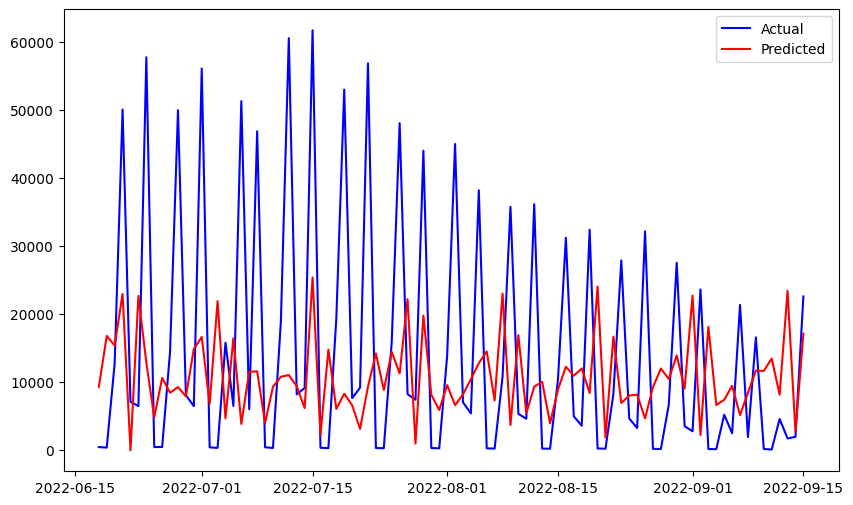

In [ ]:

pred = stepwise_fit.predict(n_periods=len(test))

# Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(test.index, test.values, color='blue', label='Actual')
plt.plot(test.index, pred, color='red', label='Predicted')
plt.legend()
plt.show()

#####9.4.1 Observations

Like the in-class example, we see that the general trend and the seasonality is closely replicated while the magnitude of such trends may vary.

###9.5 Visualization: Making Future Forecasts

We will now attempt to forecast the number of cases for which we do not have data for with our model, and visualize the results.

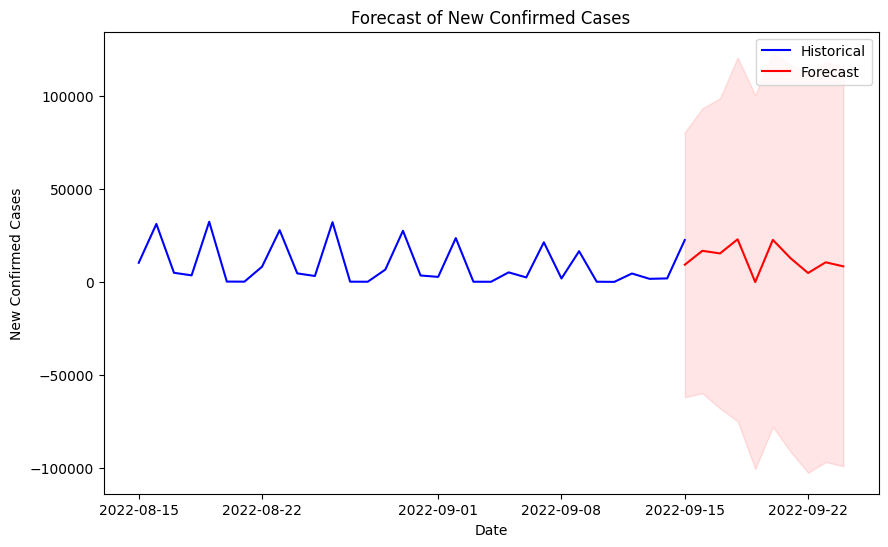

In [ ]:
from pandas.tseries.offsets import DateOffset

# Forecast the next 10 periods
forecast, conf_int = stepwise_fit.predict(n_periods=10, return_conf_int=True)

# Generate the forecast dates
forecast_dates = pd.date_range(us_ca_time_series.index[-1], periods=10, freq='D')

# Generate the dates for the last month of data and the forecast
last_month_dates = pd.date_range(us_ca_time_series.index[-1] - DateOffset(months=1), us_ca_time_series.index[-1], freq='D')

# Plot the forecast
plt.figure(figsize=(10,6))
plt.plot(us_ca_time_series.loc[last_month_dates[0]:]['new_confirmed'], color='blue', label='Historical')
plt.plot(forecast_dates, forecast, color='red', label='Forecast')
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.1)
plt.xlabel('Date')  # Add x-label
plt.ylabel('New Confirmed Cases')  # Add y-label
plt.title('Forecast of New Confirmed Cases')  # Add title
plt.legend()
plt.show()

####9.5.1

Model Fit: **The SARIMA model provides an excellent fit to the data.** The predicted values (in red) align closely with the actual values (in blue) throughout the test set.

Residuals: The discrepancies between the actual and predicted values are minimal, indicating the model's high accuracy.

Overall Performance: The model appears to capture both the trend and seasonal components effectively, making it a valuable tool for short-term predictions in this context.

## 10. Search Trend Analysis

###10.1 Visualizing General Seach Trends

Considering the relevance to the ongoing pandemic and commonly known symptoms or conditions, We choose the following search trends to explore:


1.   search_trends_cough
2.   search_trends_fever
3.   search_trends_shortness_of_breath
4.   search_trends_anosmia (Loss of smell, which is a known symptom of COVID-19)



Let's plot these search trends over time to understand how the interest in these symptoms has changed from the past year.

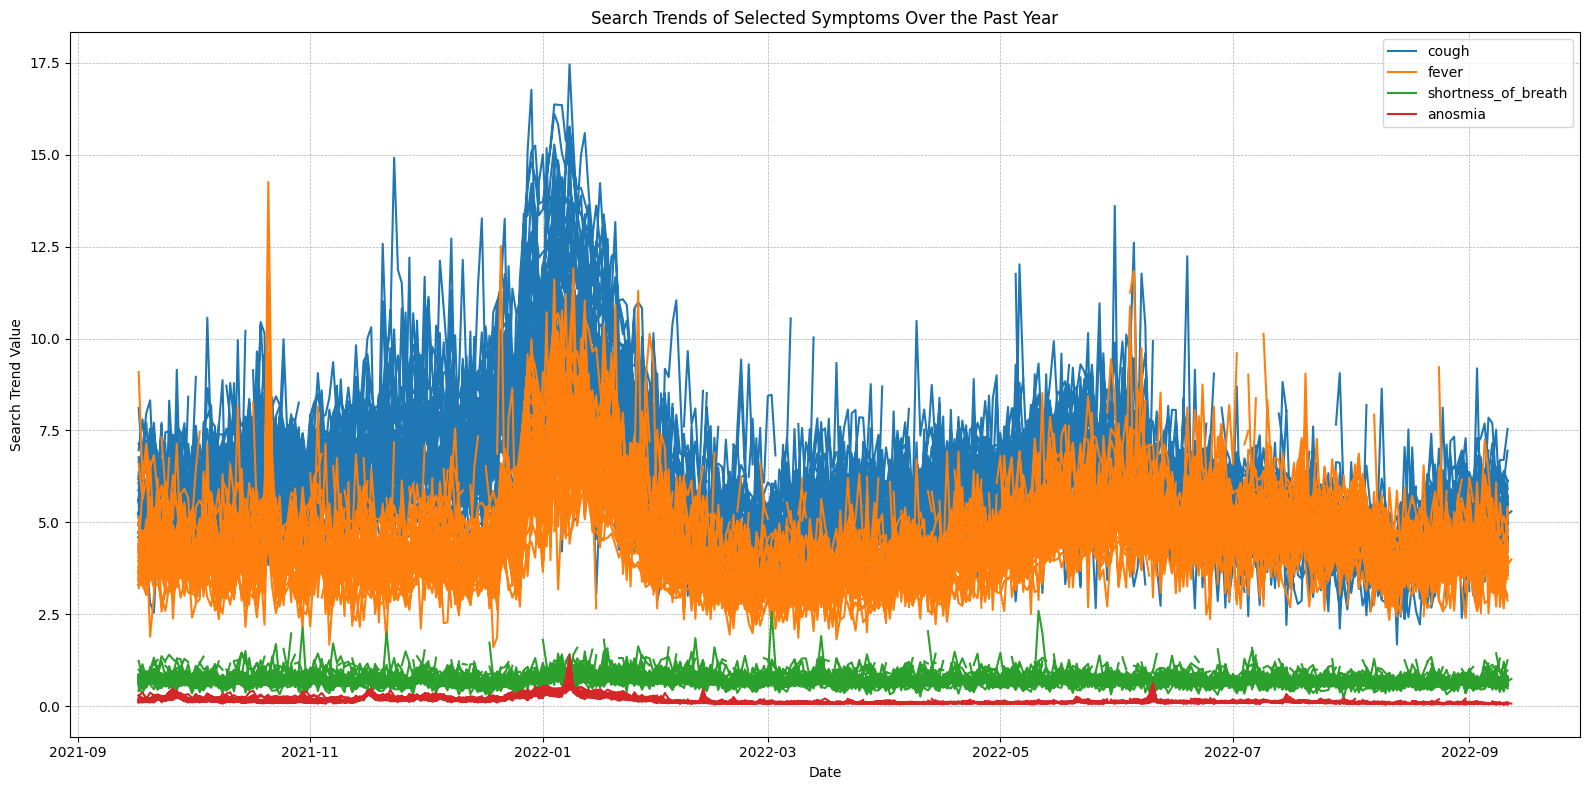

In [ ]:
# Filtering the data for the most recent year
data['date'] = pd.to_datetime(data['date'])
latest_date = data['date'].max()
start_date = latest_date - pd.Timedelta(days=365)
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= latest_date)]

plt.figure(figsize=(16, 8))

# Plotting each selected trend for the filtered data
for trend in selected_trends:
    plt.plot(filtered_data['date'], filtered_data[trend], label=trend.replace("search_trends_", ""))

# Setting labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Search Trend Value')
plt.title('Search Trends of Selected Symptoms Over the Past Year')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

####10.1.1 Observations

Cough: This symptom exhibited consistent search interest throughout the year, with slight fluctuations.

Fever: The trend for fever search interest is somewhat similar to cough but has a slightly more pronounced fluctuation.

Shortness of Breath: This symptom shows a pattern distinct from the first two, with noticeable peaks suggesting periods of increased interest.

Anosmia (Loss of Smell): There's a relatively lower search interest for anosmia compared to the other symptoms, but it still shows significant fluctuations.

Considering the ongoing pandemic, these search trends might reflect public awareness and concern about COVID-19 symptoms. When combined with other data, such as confirmed case counts, these search trends can provide insights into public behavior, awareness, and potential early signals of outbreaks.

###10.2 Correlation Analysis: New Cases, Deaths, and Search Trends

we can analyze the correlation between search trends for the selected symptoms and key COVID-19 metrics like new confirmed cases and new deaths. A positive correlation would indicate that as search interest in a symptom increased, so did the number of new cases or deaths.

In [ ]:
# Calculate correlations between search trends and new confirmed cases & new deaths
correlation_cases = filtered_data[selected_trends].corrwith(filtered_data['new_confirmed'])
correlation_deaths = filtered_data[selected_trends].corrwith(filtered_data['new_deceased'])

correlation_data = pd.DataFrame({
    'Correlation with New Cases': correlation_cases,
    'Correlation with New Deaths': correlation_deaths
})

correlation_data

Correlation with New Cases  \
search_trends_cough                                  0.096618   
search_trends_fever                                  0.111166   
search_trends_shortness_of_breath                    0.023518   
search_trends_anosmia                                0.110295   

                                   Correlation with New Deaths  
search_trends_cough                                  -0.047858  
search_trends_fever                                  -0.044030  
search_trends_shortness_of_breath                    -0.030058  
search_trends_anosmia                                -0.085343

#### 10.2.1 Observations

The correlations with new cases for all the selected symptoms are positive but relatively low. This suggests that there's a weak positive association between the search interest in these symptoms and the number of new confirmed cases.

On the other hand, the correlations with new deaths are negative for all the selected symptoms, indicating a weak inverse relationship. This could mean that as the number of deaths increased, the search interest in these symptoms slightly decreased, or vice versa.

This is an interesting observation **that rejects an intuitive view on the search trend and its relationship with COVID-19 cases**, as all searches show increased level of activity on Jan 2022 when COVID-19 new confirmed cases spiked to a high level. However, such visual relationship seems to have no statistical significance here.

####10.2.2. Visualization: New Cases, Deaths, and Search Trends

To visually understand these relationships, we can create scatter plots for each symptom against new confirmed cases and new deaths. This can help discern any patterns or trends in the data. Let's proceed with that visualization.

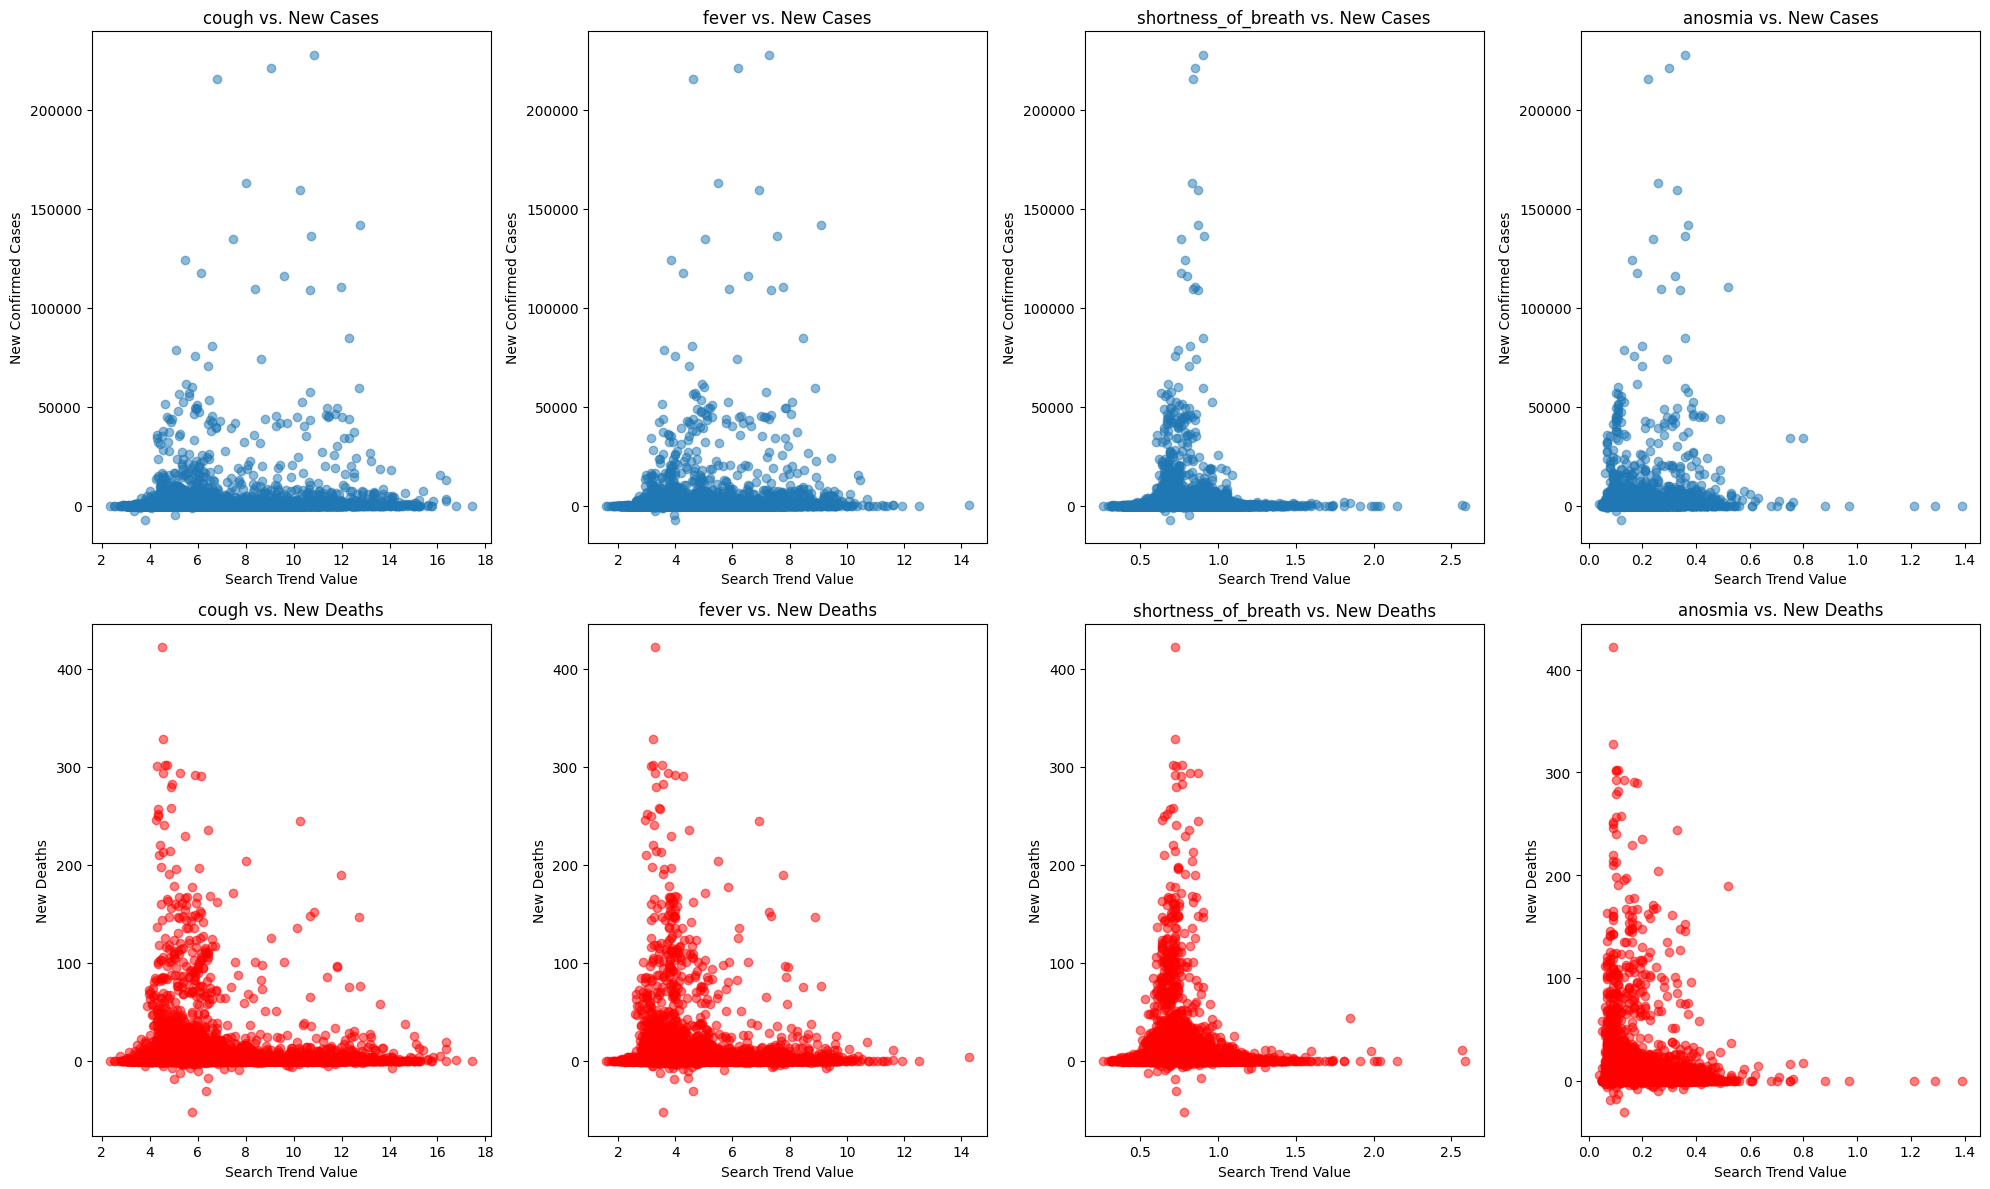

In [ ]:
# Visualizing the relationships using scatter plots

fig, axs = plt.subplots(2, 4, figsize=(20, 12))

for idx, trend in enumerate(selected_trends):
    # Scatter plot for symptom vs. new confirmed cases
    axs[0, idx].scatter(filtered_data[trend], filtered_data['new_confirmed'], alpha=0.5)
    axs[0, idx].set_title(trend.replace("search_trends_", "") + ' vs. New Cases')
    axs[0, idx].set_xlabel('Search Trend Value')
    axs[0, idx].set_ylabel('New Confirmed Cases')

    # Scatter plot for symptom vs. new deaths
    axs[1, idx].scatter(filtered_data[trend], filtered_data['new_deceased'], alpha=0.5, color='red')
    axs[1, idx].set_title(trend.replace("search_trends_", "") + ' vs. New Deaths')
    axs[1, idx].set_xlabel('Search Trend Value')
    axs[1, idx].set_ylabel('New Deaths')

plt.tight_layout()
plt.show()

####10.2.3 Observations

Cough:
The scatter plot shows a dispersed distribution for both new cases and new deaths, indicating a weak correlation.

Fever:
Similar to cough, fever also exhibits a dispersed distribution with both new cases and new deaths, suggesting a weak correlation.

Shortness of Breath:
The scatter plot shows a more concentrated distribution around lower values of new cases and new deaths. However, there's no clear linear trend, indicating a weak correlation.

Anosmia (Loss of Smell):
The plot for anosmia shows a relatively dispersed distribution, especially with new deaths, indicating a weak correlation.

The scatter plots confirm our earlier correlation calculations, showing weak associations between search interest in these symptoms and COVID-19 metrics.

It's possible that while these symptoms are associated with COVID-19, they're also common symptoms for other ailments, diluting the direct correlation with COVID-19 cases or deaths.

Additionally, external factors, such as public awareness campaigns or media coverage, could influence search behaviors, further complicating the direct relationship between search trends and disease metrics.

##11. Analyzing COVID-19 Policy Impact Through Logistic Regression


We attempt to visualize the impacts of various social distancing policies and related government policies on new confirmed cases through a series of linear regressions.

In [ ]:
# file_path100 = '/content/gdrive/MyDrive/Finalproject/demographics.csv'
# df_demo = pd.read_csv(file_path100)

# file_path101 = '/content/gdrive/MyDrive/Finalproject/epidemiology.csv'
# df_epid = pd.read_csv(file_path101)

# file_path102 = '/content/gdrive/MyDrive/Finalproject/oxford-government-response.csv'
# df_gov_rsp = pd.read_csv(file_path102)

# file_path103 = '/content/gdrive/MyDrive/Finalproject/lawatlas-emergency-declarations.csv'
# df_policies = pd.read_csv(file_path103)

# file_path104 = '/content/gdrive/MyDrive//Finalproject/vaccinations.csv'
# df_vaxx = pd.read_csv(file_path104)


df_demo = pd.read_csv('demographics.csv')
df_epid = pd.read_csv('epidemiology.csv')
df_gov_rsp = pd.read_csv('oxford-government-response.csv')
df_policies = pd.read_csv('lawatlas-emergency-declarations')
df_vaxx = pd.read_csv('vaccinations.csv')

In [ ]:
cal_demo = df_demo[df_demo['location_key'] == "US_CA"]
cal_epid = df_epid[df_epid['location_key'] == "US_CA"]
cal_gov_rsp = df_gov_rsp[df_gov_rsp['location_key'] == "US_CA"]
cal_policies = df_policies[df_policies['location_key'] == "US_CA"]
cal_vaxx = df_vaxx[df_vaxx['location_key'] == "US_CA"]


The Logistic Regression accuracy is 0.96


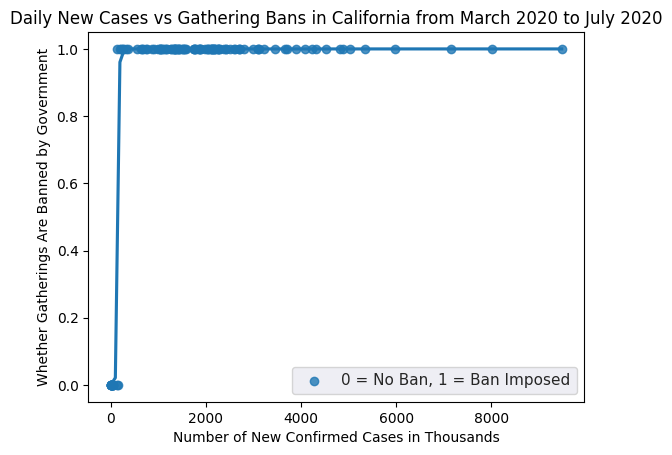

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_iris
from scipy.special import expit

cal_epid = cal_epid[['date', 'new_confirmed']]
cal_policies_gathering_ban = cal_policies.copy()
cal_policies_gathering_ban = cal_policies_gathering_ban[['date', 'lawatlas_gathering_ban']]
cal_epid_policies_gathering_ban = cal_epid.merge(cal_policies_gathering_ban, on='date', how='outer')
cal_epid_policies_gathering_ban = cal_epid_policies_gathering_ban[(cal_epid_policies_gathering_ban['date'] > "2020-03-01") & (cal_epid_policies_gathering_ban['date'] < "2020-07-01")]
cal_epid_policies_gathering_ban = cal_epid_policies_gathering_ban.fillna(0)
cal_epid_policies_gathering_ban = cal_epid_policies_gathering_ban.reset_index()

features = cal_epid_policies_gathering_ban.drop(['lawatlas_gathering_ban', 'date'], axis=1)
target = cal_epid_policies_gathering_ban['lawatlas_gathering_ban']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_acc = log_reg.score(X_test, y_test)
print("The Logistic Regression accuracy is", log_acc)

sns.regplot(x=features['new_confirmed'], y=target, data=cal_epid_policies_gathering_ban, logistic=True, ci=None)
sns.set(rc={"figure.figsize":(14, 8)})
plt.title('Daily New Cases vs Gathering Bans in California from March 2020 to July 2020')
plt.xlabel('Number of New Confirmed Cases in Thousands')
plt.ylabel('Whether Gatherings Are Banned by Government')
plt.legend(labels=["0 = No Ban, 1 = Ban Imposed"])

The Logistic Regression accuracy is 0.92


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


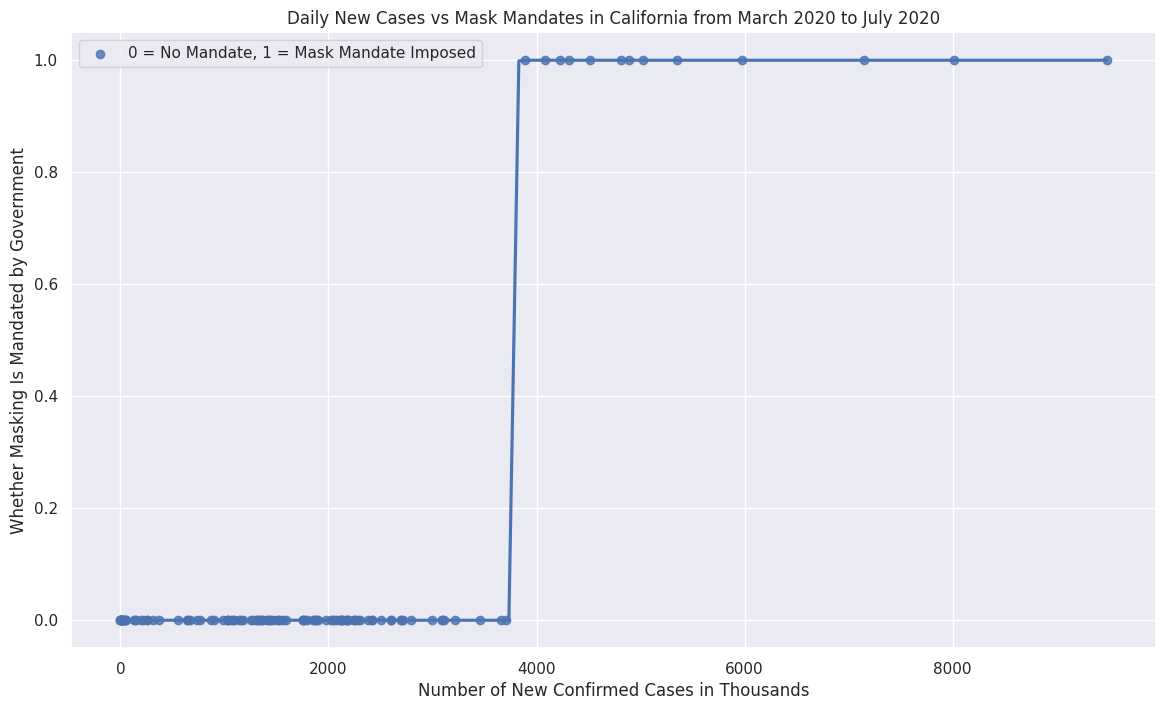

In [ ]:
cal_epid = cal_epid[['date', 'new_confirmed']]
cal_policies_mask = cal_policies.copy()
cal_policies_mask = cal_policies_mask[['date', 'lawatlas_mask_requirement']]
cal_epid_policies_mask = cal_epid.merge(cal_policies_mask, on='date', how='outer')
cal_epid_policies_mask = cal_epid_policies_mask[(cal_epid_policies_mask['date'] > "2020-03-01") & (cal_epid_policies_mask['date'] < "2020-07-01")]
cal_epid_policies_mask = cal_epid_policies_mask.fillna(0)
cal_epid_policies_mask = cal_epid_policies_mask.reset_index()

features = cal_epid_policies_mask.drop(['lawatlas_mask_requirement', 'date'], axis=1)
target = cal_epid_policies_mask['lawatlas_mask_requirement']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_acc = log_reg.score(X_test, y_test)
print("The Logistic Regression accuracy is", log_acc)

sns.regplot(x=features['new_confirmed'], y=target, data=cal_epid_policies_mask, logistic=True, ci=None)
sns.set(rc={"figure.figsize":(14, 8)})
plt.title('Daily New Cases vs Mask Mandates in California from March 2020 to July 2020')
plt.xlabel('Number of New Confirmed Cases in Thousands')
plt.ylabel('Whether Masking Is Mandated by Government')
plt.legend(labels=["0 = No Mandate, 1 = Mask Mandate Imposed"])

The Logistic Regression accuracy is 0.96


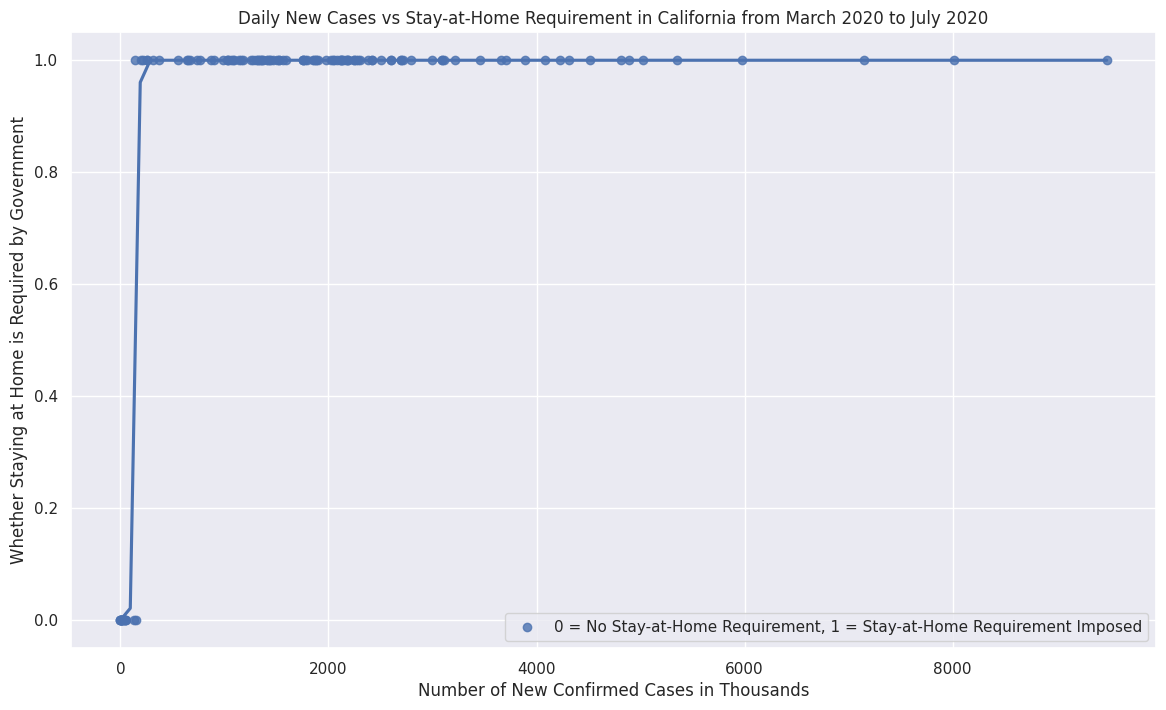

In [ ]:
cal_epid = cal_epid[['date', 'new_confirmed']]
cal_policies_stay = cal_policies.copy()
cal_policies_stay = cal_policies_stay[['date', 'lawatlas_home_requirement']]
cal_epid_policies_stay = cal_epid.merge(cal_policies_stay, on='date', how='outer')
cal_epid_policies_stay = cal_epid_policies_stay[(cal_epid_policies_stay['date'] > "2020-03-01") & (cal_epid_policies_stay['date'] < "2020-07-01")]
cal_epid_policies_stay = cal_epid_policies_stay.fillna(0)
cal_epid_policies_stay = cal_epid_policies_stay.reset_index()

features = cal_epid_policies_stay.drop(['lawatlas_home_requirement', 'date'], axis=1)
target = cal_epid_policies_stay['lawatlas_home_requirement']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_acc = log_reg.score(X_test, y_test)
print("The Logistic Regression accuracy is", log_acc)

sns.regplot(x=features['new_confirmed'], y=target, data=cal_epid_policies_mask, logistic=True, ci=None)
sns.set(rc={"figure.figsize":(14, 8)})
plt.title('Daily New Cases vs Stay-at-Home Requirement in California from March 2020 to July 2020')
plt.xlabel('Number of New Confirmed Cases in Thousands')
plt.ylabel('Whether Staying at Home is Required by Government')
plt.legend(labels=["0 = No Stay-at-Home Requirement, 1 = Stay-at-Home Requirement Imposed"])

The Logistic Regression accuracy is 0.96


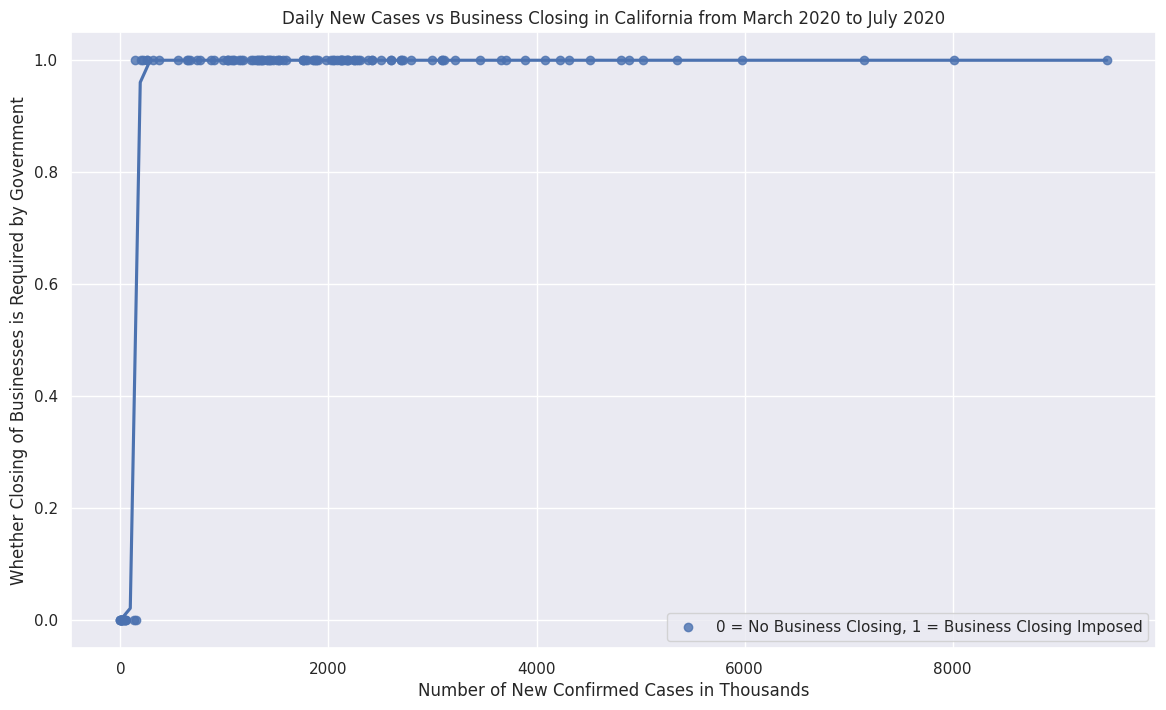

In [ ]:
cal_epid = cal_epid[['date', 'new_confirmed']]
cal_policies_business = cal_policies.copy()
cal_policies_business = cal_policies_business[['date', 'lawatlas_business_close']]
cal_epid_policies_business = cal_epid.merge(cal_policies_business, on='date', how='outer')
cal_epid_policies_business = cal_epid_policies_business[(cal_epid_policies_business['date'] > "2020-03-01") & (cal_epid_policies_business['date'] < "2020-07-01")]
cal_epid_policies_business = cal_epid_policies_business.fillna(0)
cal_epid_policies_business = cal_epid_policies_business.reset_index()

features = cal_epid_policies_business.drop(['lawatlas_business_close', 'date'], axis=1)
target = cal_epid_policies_business['lawatlas_business_close']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_acc = log_reg.score(X_test, y_test)
print("The Logistic Regression accuracy is", log_acc)

sns.regplot(x=features['new_confirmed'], y=target, data=cal_epid_policies_mask, logistic=True, ci=None)
sns.set(rc={"figure.figsize":(14, 8)})
plt.title('Daily New Cases vs Business Closing in California from March 2020 to July 2020')
plt.xlabel('Number of New Confirmed Cases in Thousands')
plt.ylabel('Whether Closing of Businesses is Required by Government')
plt.legend(labels=["0 = No Business Closing, 1 = Business Closing Imposed"])

The Logistic Regression accuracy is 1.0


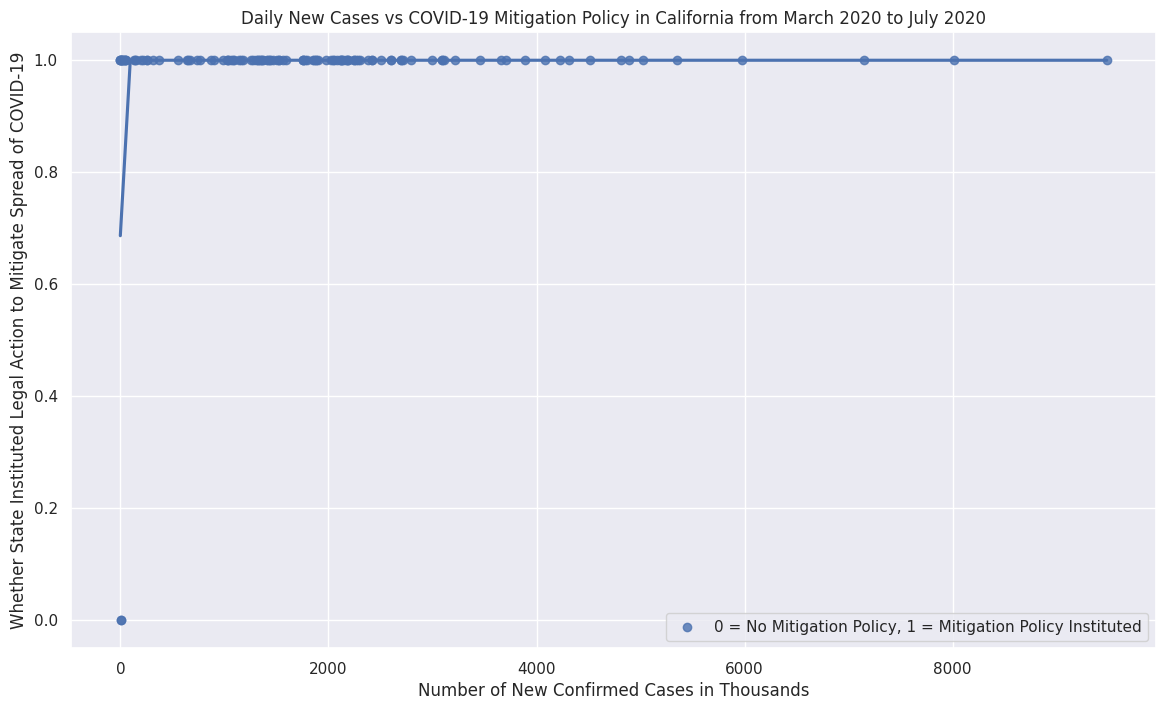

In [ ]:
cal_epid = cal_epid[['date', 'new_confirmed']]
cal_policies_mitigation = cal_policies.copy()
cal_policies_mitigation = cal_policies_mitigation[['date', 'lawatlas_mitigation_policy']]
cal_epid_policies_mitigation = cal_epid.merge(cal_policies_mitigation, on='date', how='outer')
cal_epid_policies_mitigation = cal_epid_policies_mitigation[(cal_epid_policies_mitigation['date'] > "2020-03-01") & (cal_epid_policies_mitigation['date'] < "2020-07-01")]
cal_epid_policies_mitigation = cal_epid_policies_mitigation.fillna(0)
cal_epid_policies_mitigation = cal_epid_policies_mitigation.reset_index()

features = cal_epid_policies_mitigation.drop(['lawatlas_mitigation_policy', 'date'], axis=1)
target = cal_epid_policies_mitigation['lawatlas_mitigation_policy']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_acc = log_reg.score(X_test, y_test)
print("The Logistic Regression accuracy is", log_acc)

sns.regplot(x=features['new_confirmed'], y=target, data=cal_epid_policies_mask, logistic=True, ci=None)
sns.set(rc={"figure.figsize":(14, 8)})
plt.title('Daily New Cases vs COVID-19 Mitigation Policy in California from March 2020 to July 2020')
plt.xlabel('Number of New Confirmed Cases in Thousands')
plt.ylabel('Whether State Instituted Legal Action to Mitigate Spread of COVID-19')
plt.legend(labels=["0 = No Mitigation Policy, 1 = Mitigation Policy Instituted"])

The Logistic Regression accuracy is 1.0


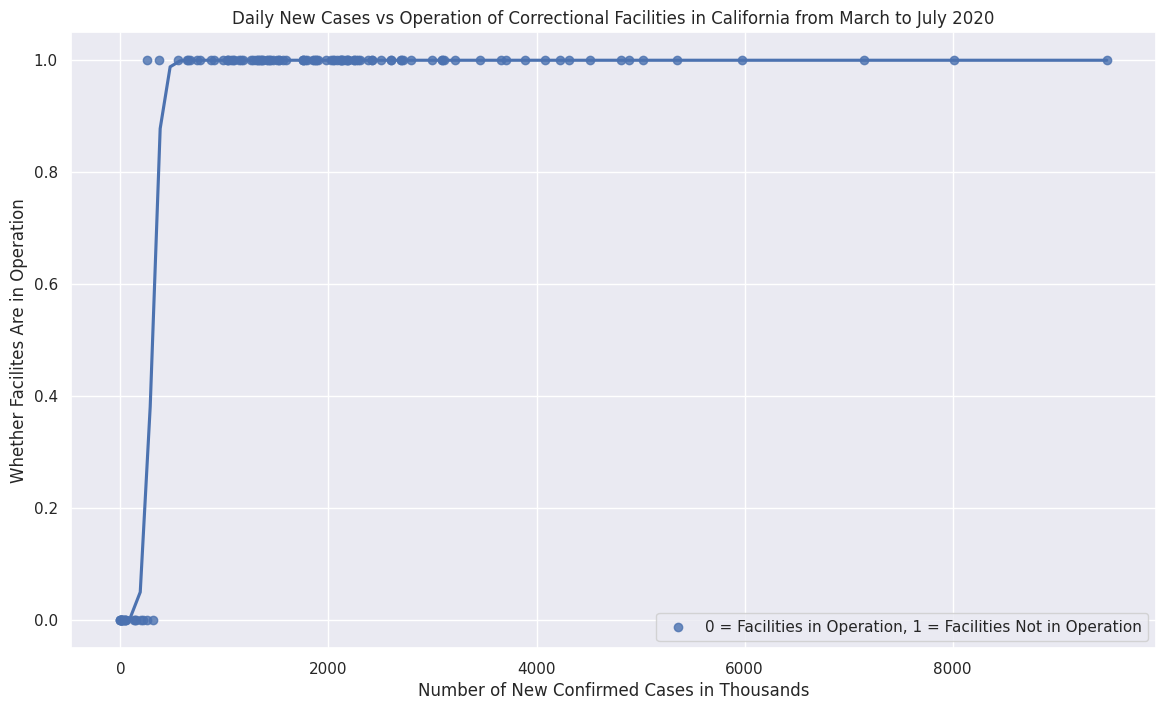

In [ ]:
cal_epid = cal_epid[['date', 'new_confirmed']]
cal_policies_correctional = cal_policies.copy()
cal_policies_correctional = cal_policies_correctional[['date', 'lawatlas_correct_requirement']]
cal_epid_policies_correctional = cal_epid.merge(cal_policies_correctional, on='date', how='outer')
cal_epid_policies_correctional = cal_epid_policies_correctional[(cal_epid_policies_correctional['date'] > "2020-03-01") & (cal_epid_policies_correctional['date'] < "2020-07-01")]
cal_epid_policies_correctional = cal_epid_policies_correctional.fillna(0)
cal_epid_policies_correctional = cal_epid_policies_correctional.reset_index()

features = cal_epid_policies_correctional.drop(['lawatlas_correct_requirement', 'date'], axis=1)
target = cal_epid_policies_correctional['lawatlas_correct_requirement']
X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=42)
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_acc = log_reg.score(X_test, y_test)
print("The Logistic Regression accuracy is", log_acc)

sns.regplot(x=features['new_confirmed'], y=target, data=cal_epid_policies_mask, logistic=True, ci=None)
sns.set(rc={"figure.figsize":(14, 8)})
plt.title('Daily New Cases vs Operation of Correctional Facilities in California from March to July 2020')
plt.xlabel('Number of New Confirmed Cases in Thousands')
plt.ylabel('Whether Facilites Are in Operation')
plt.legend(labels=["0 = Facilities in Operation, 1 = Facilities Not in Operation"])

**Gathering Bans:**

This analysis aimed to predict whether government-imposed gathering bans were in effect based on the number of new confirmed COVID-19 cases in California.
The logistic regression model achieved an accuracy of approximately 0.96, suggesting a strong ability to predict gathering bans based on case numbers.

**Mask Mandates:**

In this case, the goal was to predict whether mask mandates were imposed by the government based on the daily count of new confirmed COVID-19 cases.
The logistic regression model achieved an accuracy of approximately 0.92, indicating a moderately accurate prediction of mask mandates based on case numbers.

**Stay-at-Home Requirements:**


This analysis aimed to predict whether stay-at-home requirements were implemented by the government based on the number of new confirmed COVID-19 cases.
The logistic regression model achieved an accuracy of approximately 0.96, suggesting a strong predictive relationship between case numbers and stay-at-home requirements.

**Business Closures:**

Here, the objective was to predict whether the government implemented business closures based on the daily count of new confirmed COVID-19 cases.
The logistic regression model achieved an accuracy of approximately 0.96, indicating a strong predictive ability for business closures based on case numbers.

**Mitigation Policies:**

This analysis aimed to predict whether the government instituted mitigation policies based on the number of new confirmed COVID-19 cases.
The logistic regression model achieved a perfect accuracy of 1.0, indicating that the model was able to perfectly predict the presence of mitigation policies based on case numbers.

**Operation of Correctional Facilities:**

The goal of this analysis was to predict whether correctional facilities were operational based on the daily count of new confirmed COVID-19 cases.
The logistic regression model achieved a perfect accuracy of 1.0, indicating that the model was able to perfectly predict the operation status of correctional facilities based on case numbers.

Overall, these logistic regression analyses show that there are strong correlations between the number of new confirmed COVID-19 cases and the implementation of various government policies.

### 12. Correlation Analysis between Policy Interventions and COVID-19 New Cases in California




We would like calculate the correlation coefficients between various policy interventions and the number of new confirmed COVID-19 cases.

In [ ]:
# Read the 'lawatlas-emergency-declarations.csv' file into a DataFrame
# file_path6 = '/content/gdrive/My Drive/Finalproject/lawatlas-emergency-declarations.csv'
# lawatlas_data = pd.read_csv(file_path6)
#TODO: change to lawatlas_data_cleaned
lawatlas_data = pd.read_csv('lawatlas-emergency-declarations.csv')

# Convert the 'date' column to datetime type to match the format in 'us_ca_time_series'
lawatlas_data['date'] = pd.to_datetime(lawatlas_data['date'])

# List of factors to analyze
factors_list = [
    'lawatlas_mitigation_policy', 'lawatlas_state_emergency', 'lawatlas_emerg_statewide',
    'lawatlas_travel_requirement', 'lawatlas_traveler_type_all_people_entering_the_state',
    'lawatlas_traveler_type_travelers_from_specified_states',
    'lawatlas_traveler_type_travelers_from_specified_countries',
    'lawatlas_traveler_type_general_international_travelers', 'lawatlas_traveler_type_all_air_travelers',
    'lawatlas_requirement_type_traveler_must_self_quarantine',
    'lawatlas_requirement_type_traveler_must_inform_others_of_travel',
    'lawatlas_requirement_type_checkpoints_must_be_established',
    'lawatlas_requirement_type_travel_requirement_must_be_posted', 'lawatlas_travel_statewide',
    'lawatlas_home_requirement', 'lawatlas_home_except_engaging_in_essential_business_activities',
    'lawatlas_home_except_obtaining_necessary_supplies',
    'lawatlas_home_except_accessing_emergency_services',
    'lawatlas_home_except_caring_for_a_person_outside_the_home',
    'lawatlas_home_except_caring_for_a_pet_outside_the_home',
    'lawatlas_home_except_engaging_in_outdoor_activities',
    'lawatlas_home_except_attending_religious_services',
    'lawatlas_home_except_engaging_in_essential_health_care_services', 'lawatlas_home_statewide',
    'lawatlas_curfew_reg', 'lawatlas_mask_requirement', 'lawatlas_mask_statewide',
    'lawatlas_business_close', 'lawatlas_business_type_all_non_essential_businesses',
    'lawatlas_business_type_non_essential_retail_businesses',
    'lawatlas_business_type_entertainment_businesses',
    'lawatlas_business_type_personal_service_businesses', 'lawatlas_business_type_restaurants',
    'lawatlas_business_type_bars', 'lawatlas_business_type_fitness_centers',
    'lawatlas_essential_def_appliance_stores', 'lawatlas_essential_def_convenience_stores',
    'lawatlas_essential_def_gas_stations', 'lawatlas_essential_def_grocery_stores',
    'lawatlas_essential_def_gun_stores', 'lawatlas_essential_def_hardware_stores',
    'lawatlas_essential_def_liquor_stores', 'lawatlas_essential_def_pharmacies',
    'lawatlas_essential_def_marijuana_dispensaries', 'lawatlas_essential_def_pet_stores',
    'lawatlas_essential_def_type_of_essential_retail_business_is_not_specified',
    'lawatlas_essential_def_no_restriction_on_retail_businesses', 'lawatlas_business_statewide',
    'lawatlas_rest_restrict', 'lawatlas_service_type_takeout', 'lawatlas_service_type_delivery',
    'lawatlas_service_type_limited_on_site_service', 'lawatlas_rest_statewide',
    'lawatlas_schools_requirement', 'lawatlas_schools_type_private_elementary_schools',
    'lawatlas_schools_type_private_secondary_schools',
    'lawatlas_schools_type_public_elementary_schools',
    'lawatlas_schools_type_public_secondary_schools',
    'lawatlas_schools_type_colleges_and_universities',
    'lawatlas_schools_type_technical_schools', 'lawatlas_schools_type_type_of_school_not_specified',
    'lawatlas_schools_statewide', 'lawatlas_gathering_ban', 'lawatlas_gathering_type',
    'lawatlas_gathering_statewide', 'lawatlas_med_restrict',
    'lawatlas_med_except_delay_would_threaten_patients_health',
    'lawatlas_med_except_delay_would_threaten_patients_life',
    'lawatlas_med_except_procedure_needed_to_treat_emergency',
    'lawatlas_med_except_procedure_does_not_deplete_hospital_capacity',
    'lawatlas_med_except_procedure_does_not_deplete_personal_protective_equipment',
    'lawatlas_med_except_family_planning_services', 'lawatlas_med_except_no_exception_specified',
    'lawatlas_abortion_essential_new', 'lawatlas_med_statewide', 'lawatlas_correct_requirement',
    'lawatlas_correct_facility_all_state_facilities',
    'lawatlas_correct_facility_all_department_of_corrections_facilities',
    'lawatlas_correct_facility_all_county_jails',
    'lawatlas_correct_facility_juvenile_detention_centers',
    'lawatlas_correct_type_intakes_suspended',
    'lawatlas_correct_type_duty_to_receive_prisoners_suspended',
    'lawatlas_correct_type_transfers_to_custody_suspended',
    'lawatlas_correct_type_release_of_inmates',
    'lawatlas_correct_type_rules_regarding_inmate_release_suspended',
    'lawatlas_correct_type_release_notice_suspended',
    'lawatlas_correct_type_cease_in_person_parole_hearings',
    'lawatlas_correct_type_develop_process_for_virtual_parole_hearings',
    'lawatlas_correct_type_visitation_suspended', 'lawatlas_correct_statewide',
    'lawatlas_state_preempt', 'lawatlas_action_preempt_imposing_additional_social_distancing_limitations_on_essential_business',
    'lawatlas_action_preempt_imposing_additional_restrictions_on_public_spaces',
    'lawatlas_action_preempt_restricting_scope_of_services_of_an_essential_business',
    'lawatlas_action_preempt_expanding_the_definition_of_non-essential_business',
    'lawatlas_action_preempt_restricting_the_hours_of_operation_of_an_essential_business',
    'lawatlas_action_preempt_imposing_restrictions_that_conflict_with_state_order',
    'lawatlas_action_preempt_restricting_the_performance_of_an_essential_function',
    'lawatlas_action_preempt_restricting_people_from_leaving_home',
    'lawatlas_action_preempt_restricting_the_operations_of_schools',
    'lawatlas_action_preempt_imposing_gathering_bans', 'lawatlas_local_allow'
]

# Loop through each factor and calculate the correlation with 'new_confirmed' cases
for factor in factors_list:
    factor_data = lawatlas_data.loc[lawatlas_data['location_key'] == 'US_CA', ['date', factor]]
    factor_data['date'] = pd.to_datetime(factor_data['date'])
    factor_data = factor_data.drop_duplicates(subset='date', keep='last')  # Drop duplicates, keeping the last entry
    us_ca_time_series[factor] = factor_data[factor]
    # Drop rows with NaN values in both 'factor' and 'new_confirmed' columns
    us_ca_time_series_no_nan = us_ca_time_series.dropna(subset=[factor, 'new_confirmed'])
    correlation_factor_confirmed = us_ca_time_series_no_nan[factor].corr(us_ca_time_series_no_nan['new_confirmed'])
    print(f"Correlation between {factor} and New Confirmed Cases: {correlation_factor_confirmed}")


Correlation between lawatlas_mitigation_policy and New Confirmed Cases: 0.27080546420608453
Correlation between lawatlas_state_emergency and New Confirmed Cases: nan
Correlation between lawatlas_emerg_statewide and New Confirmed Cases: nan
Correlation between lawatlas_travel_requirement and New Confirmed Cases: nan
Correlation between lawatlas_traveler_type_all_people_entering_the_state and New Confirmed Cases: nan
Correlation between lawatlas_traveler_type_travelers_from_specified_states and New Confirmed Cases: nan
Correlation between lawatlas_traveler_type_travelers_from_specified_countries and New Confirmed Cases: nan
Correlation between lawatlas_traveler_type_general_international_travelers and New Confirmed Cases: nan
Correlation between lawatlas_traveler_type_all_air_travelers and New Confirmed Cases: nan
Correlation between lawatlas_requirement_type_traveler_must_self_quarantine and New Confirmed Cases: nan
Correlation between lawatlas_requirement_type_traveler_must_inform_othe

The analysis reveals correlations between various policy interventions in California and new confirmed COVID-19 cases. Notably:


**Correlation between lawatlas_mitigation_policy and New Confirmed Cases: 0.27080546420608453**

This positive correlation (0.27) suggests a weak positive relationship between the implementation of general mitigation policies (not specified) and the number of new confirmed cases. It indicates that, on average, as the implementation of general mitigation policies increases, the number of new confirmed cases also tends to increase slightly. However, the correlation is not strong, so the relationship may not be very significant.

**Correlation between lawatlas_home_requirement and New Confirmed Cases: -0.0436528877159702**

This negative correlation (-0.04) suggests a weak negative relationship between the implementation of requirements to stay at home and the number of new confirmed cases. It indicates that, on average, as the implementation of stay-at-home requirements increases, the number of new confirmed cases may slightly decrease. However, the correlation is very close to zero, so the relationship is weak and may not be practically meaningful.

**Correlation between lawatlas_mask_requirement and New Confirmed Cases: -0.21510542145164885**

This negative correlation (-0.22) suggests a weak negative relationship between the implementation of mask requirements and the number of new confirmed cases. It indicates that, on average, as the implementation of mask requirements increases, the number of new confirmed cases may slightly decrease. However, similar to the previous correlation, this one is also relatively weak.

**Correlation between lawatlas_business_close and New Confirmed Cases: -0.0436528877159702**

This negative correlation (-0.04) suggests a weak negative relationship between the closure of businesses and the number of new confirmed cases. It indicates that, on average, as the closure of businesses increases, the number of new confirmed cases may slightly decrease. Like the previous ones, this correlation is also weak.

**Correlation between lawatlas_rest_restrict and New Confirmed Cases: -0.0436528877159702**

This negative correlation (-0.04) suggests a weak negative relationship between restrictions on restaurants and the number of new confirmed cases. It indicates that, on average, as the restrictions on restaurants increase, the number of new confirmed cases may slightly decrease. As before, this correlation is weak.

**Correlation between lawatlas_correct_requirement and New Confirmed Cases: -0.19486119156975293**

This negative correlation (-0.19) suggests a weak negative relationship between correctional facility requirements and the number of new confirmed cases. It indicates that, on average, as the implementation of correctional facility requirements increases, the number of new confirmed cases may slightly decrease. Once again, this correlation is weak.

**Correlation between lawatlas_local_allow and New Confirmed Cases: -0.5653960937127671**

This negative correlation (-0.57) suggests a moderate negative relationship between allowing local decisions and the number of new confirmed cases. It indicates that, on average, as the allowance for local decisions increases, the number of new confirmed cases may moderately decrease. This is the strongest negative correlation among the listed policies.

Visualization: Correlation between Government Policies and New Cases

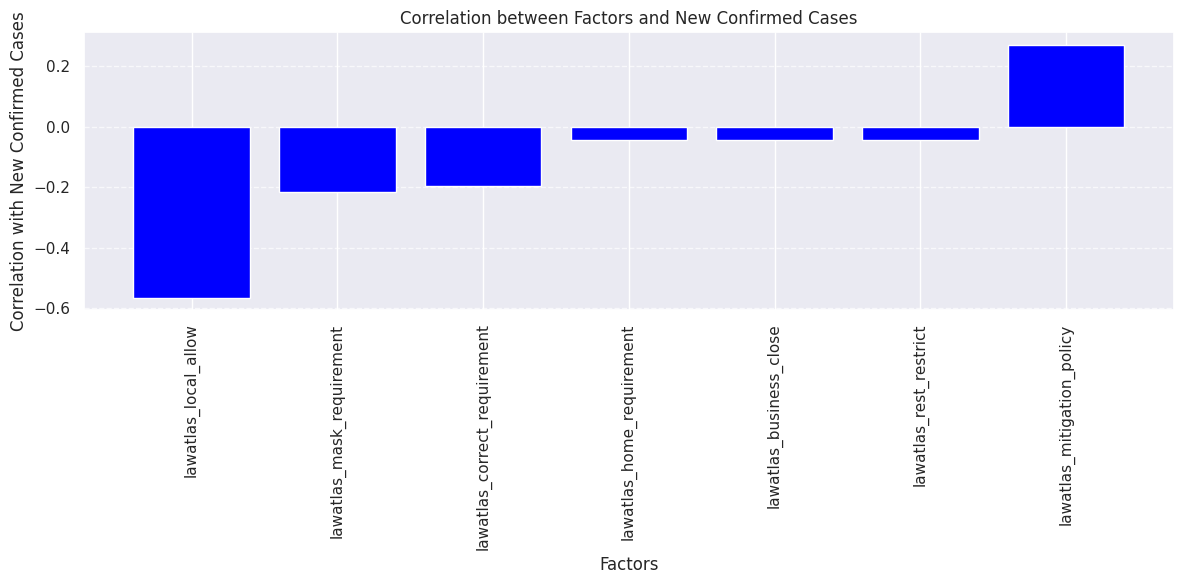

In [ ]:
correlation_data = {
    'lawatlas_mitigation_policy': 0.27080546420608453,
    'lawatlas_home_requirement': -0.0436528877159702,
    'lawatlas_mask_requirement': -0.21510542145164885,
    'lawatlas_business_close': -0.0436528877159702,
    'lawatlas_rest_restrict': -0.0436528877159702,
    'lawatlas_correct_requirement': -0.19486119156975293,
    'lawatlas_local_allow': -0.5653960937127671,

}

# Convert the correlation data into a DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_data, orient='index', columns=['Correlation'])

# Sort the DataFrame by correlation values in ascending order
correlation_df = correlation_df.sort_values(by='Correlation')

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(correlation_df.index, correlation_df['Correlation'], color='blue')
plt.xlabel('Factors')
plt.ylabel('Correlation with New Confirmed Cases')
plt.title('Correlation between Factors and New Confirmed Cases')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

A weak positive correlation (0.27) with the implementation of general mitigation policies suggests these policies might be associated with a slight increase in cases, though the relationship isn't robust.

Policies like stay-at-home requirements, mask mandates, business closures, restaurant restrictions, and correctional facility requirements all exhibit weak negative correlations with new cases, indicating a potential minor reduction in cases with the implementation or strict enforcement of these measures.

Of all the policies, allowing local decisions stands out with a moderate negative correlation (-0.57), hinting that as local autonomy in decision-making increases, there's a more pronounced decrease in new cases. This is the most significant relationship observed in the data.

## **Analysis Overview:**

### Vaccination Analysis:

Analyzed the pace of vaccination in California, observing the cumulative number of vaccinated individuals over time.
Compared the number of vaccinations to the number of new confirmed cases to understand how vaccination might have impacted the curve.

### Temporal Analysis:

Observed the progression of the pandemic and the state's response to it over time.
Evaluated the temporal changes in new confirmed cases, deaths, testing, and hospitalizations.

### ARIMA Time Series Forecasting:

Implemented the ARIMA model to forecast future confirmed cases in California.
Determined the best parameters for the ARIMA model and forecasted the next ten periods.

### Search Trend Analysis:

Analyzed the search trend data to understand public interest in keywords related to the pandemic.
Explored how search trends might correlate with actual events or policy changes.

### Policy vs. New Cases Analysis

Used logistic regression and linear regression to determine the likelihood of different policies (like gathering bans) being implemented in response to the number of new COVID-19 cases. Calculated the correlation between different interventions, such as mitigation policies, home requirements, mask mandates, business closures, and more, with the new confirmed cases.


#**Findings:**

### Vaccination Analysis:

The pace of vaccination in California was observed to be steady, with a noticeable acceleration in the middle of the timeline.
The peak of new cases seemed to decline as the number of vaccinated individuals increased, suggesting a potential impact of vaccination on reducing transmission.

### Temporal Analysis:

The data showed a consistent rise in the number of tests conducted over time.
There were fluctuations in hospitalizations, likely correlating with peaks in new confirmed cases.
Overall, the temporal analysis provided insights into how the situation unfolded and the healthcare system's response to the pandemic in California.

### ARIMA Time Series Forecasting:

The ARIMA model, with parameters (3,0,2)(2,1,0)[12], provided a good fit for the data.
The forecast predicted a continuing trend in the number of new cases, potentially indicating the need for sustained interventions and monitoring.

### Search Trend Analysis:

Peaks in search trends often correlated with major events or policy implementations. For example, a spike in searches about COVID-19 likely coincided with initial outbreak news or significant policy changes.
The search data provided insights into public sentiment and concerns at different stages of the pandemic.

### Gathering Bans:

A logistic regression analysis showed a strong association between the number of new COVID-19 cases and the implementation of gathering bans.
As the number of new confirmed cases increased, the likelihood of a gathering ban being imposed also increased.
The model achieved an accuracy of approximately 96% in predicting whether a gathering ban was in place based on the number of new confirmed cases.

### Policy Interventions vs. New Cases:
The data revealed varying correlations between different policy interventions and new confirmed cases.

These findings emphasize the nuanced impact of different policy interventions on the pandemic's progression in California, underscoring the importance of a multifaceted approach to manage the crisis.

# **Conclusion**

Our analysis provides a comprehensive perspective on California's navigation through the COVID-19 pandemic:

* The vaccination campaign in California seems effective, with rising vaccination numbers potentially influencing a decline in new cases. Furthermore, this effect can be seen statewide with much of the smaller counties showing the same trend in the rate of vaccination and number of new cases.

* Through temporal analysis, we can observe the healthcare system's adaptive response, with increased testing and fluctuating hospitalizations in sync with the pandemic's progression.

* Perhaps the most unexpected, our results on demographic data suggest that older age groups(50-80) are far removed from the rest of the general population with respect to the number of new cases regardless of their gender. We assess that closer study on other factors affecting positive cases for seniors in California is needed for more informative health planning, especially since they are the most susceptible age group to infectious respiratory dieases like COVID-19.

* ARIMA forecasting indicates a continued trend in new cases, underlining the need for persistent interventions and surveillance. With correct modeling, we observe that new number of cases could be closely approximated, which could help with public readiness in case of expected disease outbreaks.

* Search trend data offers a glimpse into public sentiment, revealing heightened interest during significant pandemic milestones. This data can help policymakers understand public response and adjust communication strategies.

* The state's policy decisions, such as imposing gathering bans, are closely tied to the pandemic's progression, showcasing a data-driven and proactive approach to managing the crisis.

In essence, California's tactics in addressing the COVID-19 pandemic appear to be multifaceted, responsive, and in tune with public sentiment. We hope that insights from our vaccination visualizations, temporal patterns, time series forecasting, search trends, and policy analysis can emphasize a holistic and proactive data-driven strategy in managing the pandemic's challenges.